In [1]:
!pip install prince
!pip install xgboost
!pip install --upgrade numpy
!pip install flask pandas.
from flask import Flask, send_file
import numpy as np
import warnings
import pandas as pd
import pandas as pd
import seaborn as sns
import math as mat
import matplotlib.pyplot as plt
import prince
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from scipy.stats import chi2_contingency, chi2
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import r2_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from factor_analyzer import FactorAnalyzer
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.ensemble import RUSBoostClassifier, BalancedRandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from prince import ca

ERROR: Invalid requirement: 'pandas.'


In [2]:
# Disable all warnings. There is one warning about the balanced random forest.
warnings.filterwarnings("ignore")

In [3]:
#Here are the auxiliary functions

## defines a function that plots multiple box plots
def plot_multiple_boxplots(data, feats, title="Box Plots"):

    # Prepare figure. Create individual axes where each histogram will be placed
    fig, axes = plt.subplots(2, ceil(len(feats) / 2), figsize=(20, 11))

    # Plot data
    # Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
    for ax, feat in zip(axes.flatten(), feats): # Notice the zip() function and flatten() method
      sns.boxplot(x=data[feat], ax=ax)
    
    # Layout
    # Add a centered title to the figure:
    plt.suptitle(title)

    plt.show()

    return


def remove_outliers_zscore(data, threshold=3):
    z_scores = (data - data.mean()) / data.std()
    filtered_data = data[abs(z_scores) <= threshold]
    return filtered_data


#Calculates weights for the variables based on their spearman correlation value with a target variable.
def weighted_categories_merge(df, var_list, new_var_name=None, weights_list=None, save=None):
    # Calculate Spearman correlation coefficients and p-values
    corr, pval = spearmanr(df[expl_vars + [target_var]], nan_policy='omit')
    
    # Extract correlation coefficients for target variable
    corr_target = corr[-1, :-1]
    
    # Calculate absolute values of correlation coefficients
    abs_corr = abs(corr_target)
    
    # Normalize correlation coefficients to get weights
    weights = abs_corr / sum(abs_corr)
    
    # Round weights to 3 decimal places and adjust for rounding errors
    weights = [round(w, 3) for w in weights]
    weights[-1] = round(1 - sum(weights[:-1]), 3)
    
    # Print weights
    for var, weight in zip(expl_vars, weights):
        print(f"{var}: {weight}")
        
        

def evaluate_model(true_labels, predicted_labels):
    """Function to evaluate the performance of a classification model"""
    accuracy = accuracy_score(true_labels, predicted_labels)
    auc = roc_auc_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return accuracy, auc, f1, sensitivity, specificity, cm



#Calculates weights for the variables based on their spearman correlation value with a target variable.
def calculate_spearman_corr_weights(df, expl_vars, target_var):
    # Calculate Spearman correlation coefficients and p-values
    corr, pval = spearmanr(df[expl_vars + [target_var]], nan_policy='omit')
    
    # Extract correlation coefficients for target variable
    corr_target = corr[-1, :-1]
    
    # Calculate absolute values of correlation coefficients
    abs_corr = abs(corr_target)
    
    # Normalize correlation coefficients to get weights
    weights = abs_corr / sum(abs_corr)
    
    # Round weights to 3 decimal places and adjust for rounding errors
    weights = [round(w, 3) for w in weights]
    weights[-1] = round(1 - sum(weights[:-1]), 3)
    
    # Print weights
    for var, weight in zip(expl_vars, weights):
        print(f"{var}: {weight}")




In [4]:
campaign = pd.read_excel('MEA.xlsx')
campaign.describe().T

count          mean           std     min       25%       50%  \
CustID       9000.0   4500.500000   2598.220545    1.00   2250.75   4500.50   
Age          9000.0     48.938222     17.295911   19.00     34.00     49.00   
Dependents   9000.0      0.685111      0.464497    0.00      0.00      1.00   
Income       8982.0  46480.140392  18888.011359   36.20  31467.25  46566.40   
Frequency    8995.0     20.853585     11.215599    1.00     12.00     18.00   
Recency      8985.0     60.965721     58.087536    1.00     27.00     53.00   
Perishables  9000.0   2118.618871   2165.338142 -363.36    354.67   1382.66   
Beverages    9000.0    825.844107    996.577273 -190.00    165.40    388.96   
Frozen       9000.0    577.109422    803.063389 -354.04    154.00    269.08   
Canned       9000.0    500.962751    814.436925 -578.80     67.83    187.36   
Others       9000.0    524.782267    782.893816 -498.72    112.80    234.42   
Internet     9000.0     57.584333     18.807244   10.00     42.00     55.00   
NPS          9000.0      3.433000      1.017876    1.00      3.00      4.00   

                   75%        max  
CustID        6750.250    9000.00  
Age             64.000      79.00  
Dependents       1.000       1.00  
Income       61382.700  191402.00  
Frequency       29.000      61.00  
Recency         79.000     365.00  
Perishables   3324.655   20073.34  
Beverages     1139.330   12524.92  
Frozen         660.160    9120.12  
Canned         588.130   19656.28  
Others         610.110   13074.08  
Internet        73.000     101.00  
NPS              4.000       5.00

In [5]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustID          9000 non-null   int64  
 1   Education       8950 non-null   object 
 2   Marital_Status  8816 non-null   object 
 3   Age             9000 non-null   int64  
 4   Gender          8987 non-null   object 
 5   Dependents      9000 non-null   int64  
 6   Income          8982 non-null   float64
 7   Frequency       8995 non-null   float64
 8   Recency         8985 non-null   float64
 9   Perishables     9000 non-null   float64
 10  Beverages       9000 non-null   float64
 11  Frozen          9000 non-null   float64
 12  Canned          9000 non-null   float64
 13  Others          9000 non-null   float64
 14  Internet        9000 non-null   int64  
 15  NPS             9000 non-null   int64  
 16  Target          9000 non-null   object 
dtypes: float64(8), int64(5), object(4

In [6]:
#Setting the customer ID as Index
campaign = campaign.set_index('CustID')

In [7]:
# Show top rows
pd.set_option('display.max_columns', None)
campaign.head()

Education Marital_Status  Age Gender  Dependents   Income  Frequency  \
CustID                                                                        
1            MSc       Together   67      F           0  67696.2       33.0   
2            BSc       Together   40      M           1  43446.0       15.0   
3            MSc         Single   75      M           0  64193.2       37.0   
4            BSc         Single   40      M           1  55898.2       28.0   
5            BSc        Married   26      F           1  14414.4       13.0   

        Recency  Perishables  Beverages   Frozen   Canned  Others  Internet  \
CustID                                                                        
1          74.0      4865.80    2649.32  2152.80  1715.64  244.08        96   
2          17.0       323.76     215.24   170.24   107.68   72.84        52   
3          93.0      5467.00    3218.00  1736.40  1460.20  614.40        92   
4          31.0      3598.00     958.20   259.80   147.80  121.80        59   
5          84.0       263.52     161.52   228.56    57.32  407.52        45   

        NPS Target  
CustID              
1         5      ?  
2         3      ?  
3         5      ?  
4         4      ?  
5         2      ?

In [8]:
numeric_variables = ['Income','Recency','Frozen','Canned','Age','Frequency','Perishables','Beverages','Frozen','Canned','Others','Internet','NPS']
categorical_variables = [['Dependents']]

In [9]:
campaign.isnull().sum()

Education          50
Marital_Status    184
Age                 0
Gender             13
Dependents          0
Income             18
Frequency           5
Recency            15
Perishables         0
Beverages           0
Frozen              0
Canned              0
Others              0
Internet            0
NPS                 0
Target              0
dtype: int64

In [10]:
campaign[['Income','Recency','Frozen','Canned','Age','Frequency','Perishables','Beverages']].describe().T

count          mean           std     min       25%       50%  \
Income       8982.0  46480.140392  18888.011359   36.20  31467.25  46566.40   
Recency      8985.0     60.965721     58.087536    1.00     27.00     53.00   
Frozen       9000.0    577.109422    803.063389 -354.04    154.00    269.08   
Canned       9000.0    500.962751    814.436925 -578.80     67.83    187.36   
Age          9000.0     48.938222     17.295911   19.00     34.00     49.00   
Frequency    8995.0     20.853585     11.215599    1.00     12.00     18.00   
Perishables  9000.0   2118.618871   2165.338142 -363.36    354.67   1382.66   
Beverages    9000.0    825.844107    996.577273 -190.00    165.40    388.96   

                   75%        max  
Income       61382.700  191402.00  
Recency         79.000     365.00  
Frozen         660.160    9120.12  
Canned         588.130   19656.28  
Age             64.000      79.00  
Frequency       29.000      61.00  
Perishables   3324.655   20073.34  
Beverages     1139.330   12524.92

In [11]:
campaign[['Frozen','Canned','Others','Internet','NPS']].describe()

Frozen        Canned        Others     Internet          NPS
count  9000.000000   9000.000000   9000.000000  9000.000000  9000.000000
mean    577.109422    500.962751    524.782267    57.584333     3.433000
std     803.063389    814.436925    782.893816    18.807244     1.017876
min    -354.040000   -578.800000   -498.720000    10.000000     1.000000
25%     154.000000     67.830000    112.800000    42.000000     3.000000
50%     269.080000    187.360000    234.420000    55.000000     4.000000
75%     660.160000    588.130000    610.110000    73.000000     4.000000
max    9120.120000  19656.280000  13074.080000   101.000000     5.000000

In [12]:
campaign[['Education','Marital_Status']].describe()

Education Marital_Status
count       8950           8816
unique         5              5
top          BSc        Married
freq        4430           3271

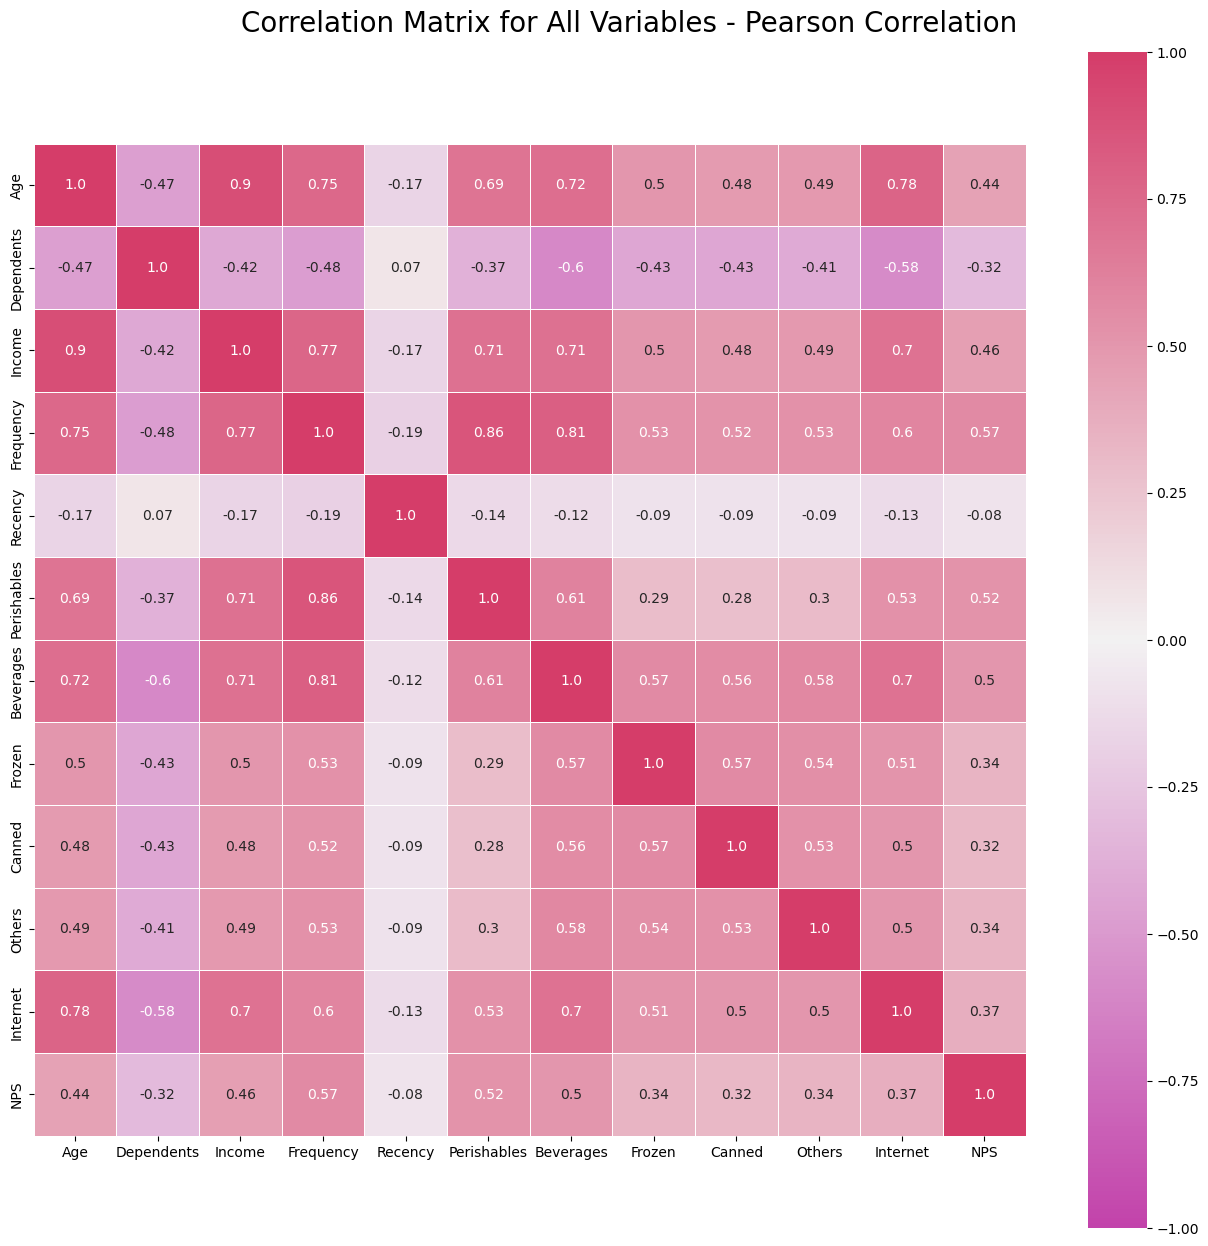

In [13]:
#ploting Pearson's Correlation Matrix for all variables
fig = plt.figure(figsize=(16, 14))

corr = np.round(campaign.corr(method="pearson"), decimals=2)

mask_annot = np.absolute(corr.values) >= 0.01
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(320, 360, as_cmap=True), 
fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=0.5)
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix for All Variables - Pearson Correlation ", fontsize=20)

plt.show()

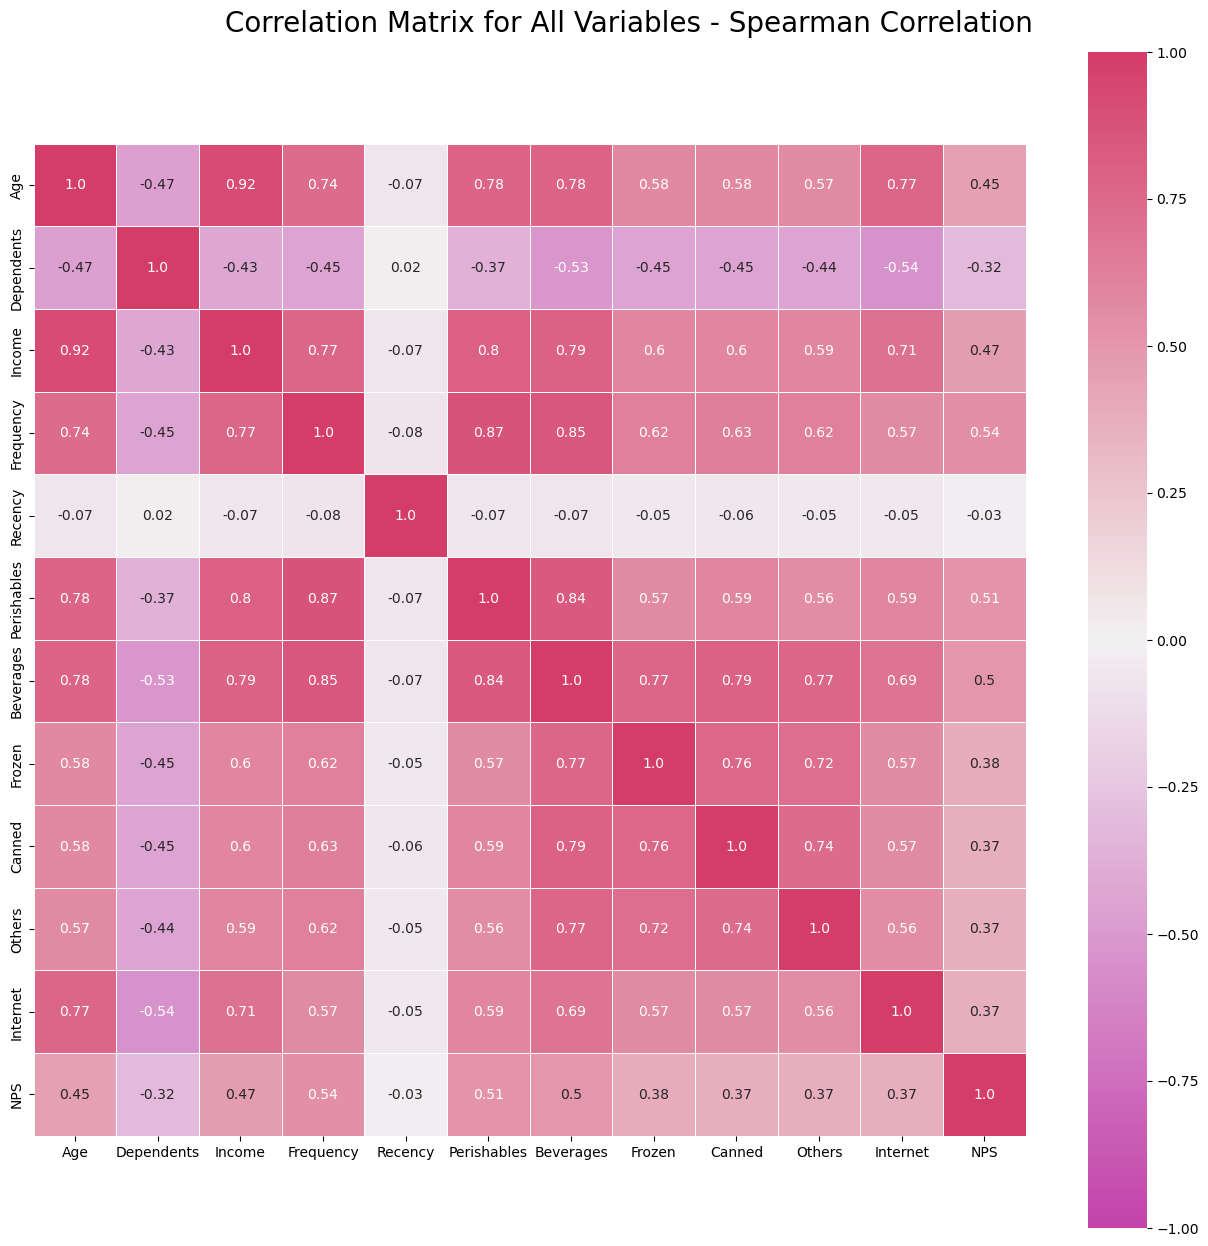

In [14]:
#ploting Spearman's Correlation Matrix for all variables
fig = plt.figure(figsize=(16, 14))

corr = np.round(campaign.corr(method="spearman"), decimals=2)

mask_annot = np.absolute(corr.values) >= 0.01
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(320, 360, as_cmap=True), 
fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=0.5)
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix for All Variables - Spearman Correlation ", fontsize=20)

plt.show()

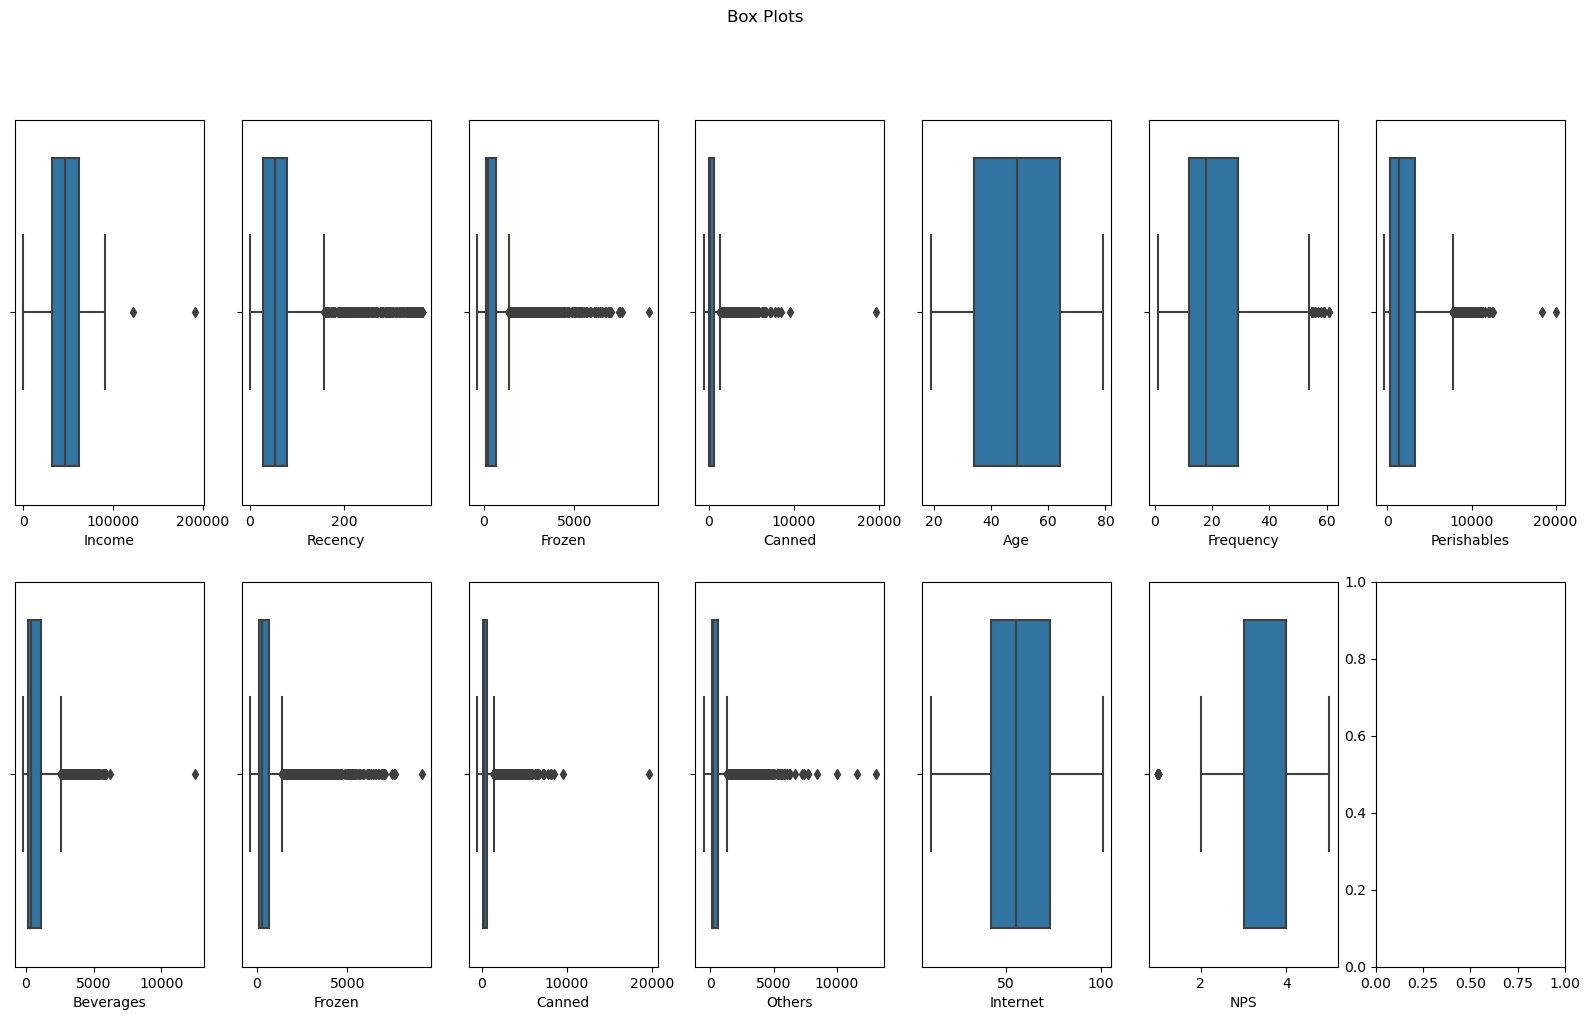

In [15]:
plot_multiple_boxplots(campaign, numeric_variables)

Married     3271
Single      2300
Together    2119
Divorced     679
Widow        447
Name: Marital_Status, dtype: int64


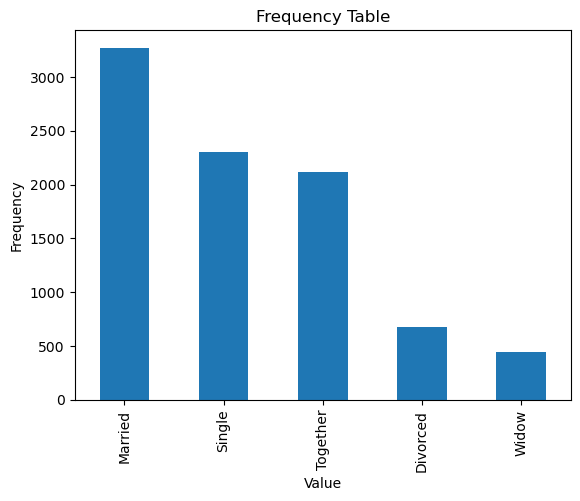

In [16]:
frequency_table_MS = campaign['Marital_Status'].value_counts()

# Print the frequency table
print(frequency_table_MS)

frequency_table_MS.plot(kind='bar')

# Set the axis labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency Table')

# Display the plot
plt.show()

BSc            4430
High School    1505
MSc            1305
Primary        1116
PhD             594
Name: Education, dtype: int64


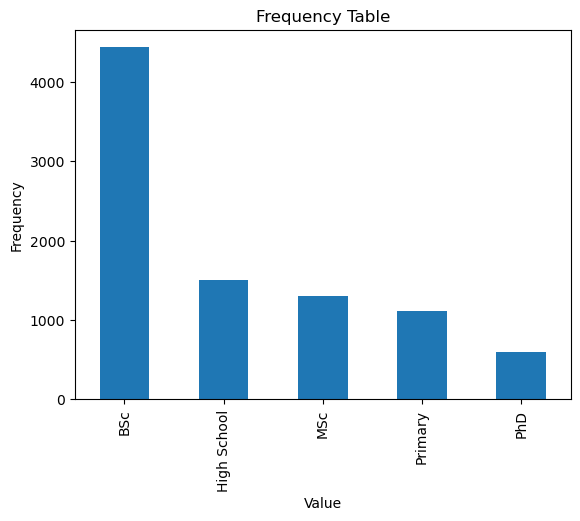

In [17]:
frequency_table_E = campaign['Education'].value_counts()

# Print the frequency table
print(frequency_table_E)

frequency_table_E.plot(kind='bar')

# Set the axis labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency Table')

# Display the plot
plt.show()

M        5757
F        3203
Other      27
Name: Gender, dtype: int64


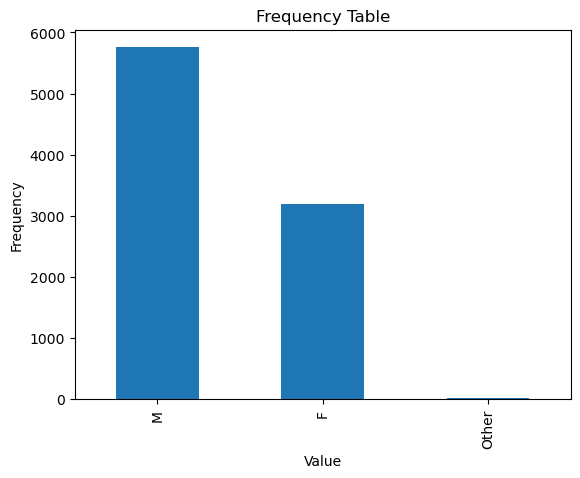

In [18]:
frequency_table_G = campaign['Gender'].value_counts()

# Print the frequency table
print(frequency_table_G)

frequency_table_G.plot(kind='bar')

# Set the axis labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency Table')

# Display the plot
plt.show()

?    7000
0    1792
1     208
Name: Target, dtype: int64


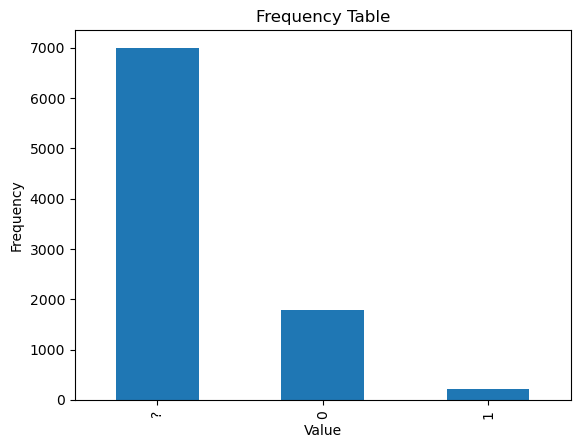

In [19]:
frequency_table_E = campaign['Target'].value_counts()

# Print the frequency table
print(frequency_table_E)

frequency_table_E.plot(kind='bar')

# Set the axis labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency Table')

# Display the plot
plt.show()

In [20]:
#The Categorical Variables look very good. We keep it as it is.

In [21]:
#making a backup before treating the outliers

In [22]:
campaign_backup = campaign.copy()

In [23]:
campaign_outliers = campaign.copy()

In [24]:
#dropping all variables so that we can store the outliers in this df now.
campaign_outliers.drop(campaign_outliers.index)

Empty DataFrame
Columns: [Education, Marital_Status, Age, Gender, Dependents, Income, Frequency, Recency, Perishables, Beverages, Frozen, Canned, Others, Internet, NPS, Target]
Index: []

In [25]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9000 entries, 1 to 9000
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Education       8950 non-null   object 
 1   Marital_Status  8816 non-null   object 
 2   Age             9000 non-null   int64  
 3   Gender          8987 non-null   object 
 4   Dependents      9000 non-null   int64  
 5   Income          8982 non-null   float64
 6   Frequency       8995 non-null   float64
 7   Recency         8985 non-null   float64
 8   Perishables     9000 non-null   float64
 9   Beverages       9000 non-null   float64
 10  Frozen          9000 non-null   float64
 11  Canned          9000 non-null   float64
 12  Others          9000 non-null   float64
 13  Internet        9000 non-null   int64  
 14  NPS             9000 non-null   int64  
 15  Target          9000 non-null   object 
dtypes: float64(8), int64(4), object(4)
memory usage: 1.4+ MB


In [26]:
# What to do with the negative values?
#Since the variable is measuring the amount spent, there cant be negative values. The effective amount spent can 
# be only 0. Strong negative outliers we will delete, the other we will clip to 0

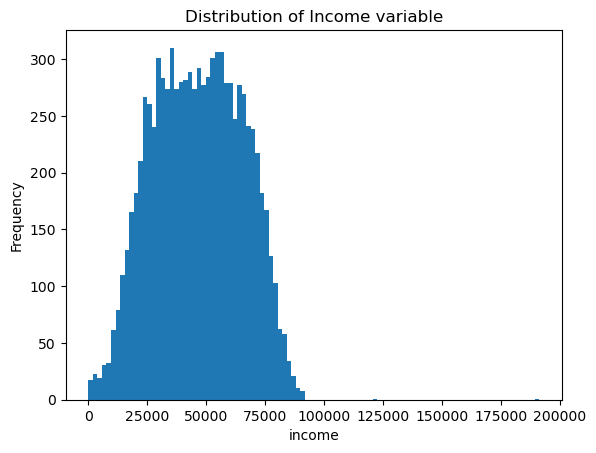

In [27]:
# create a histogram of the DaysSinceCreation variable
plt.hist(campaign['Income'], bins=100)
plt.xlabel('income')
plt.ylabel('Frequency')
plt.title('Distribution of Income variable')
plt.show()

In [28]:
data = campaign['Income']

# Using Z-score method with a threshold of 3
filtered_zscore = remove_outliers_zscore(data, threshold=3)
print("Filtered (Z-score) range:", filtered_zscore.min(), "-", filtered_zscore.max())


Filtered (Z-score) range: 36.200000000000045 - 90770.8


In [29]:
campaign['Income'].describe()

count      8982.000000
mean      46480.140392
std       18888.011359
min          36.200000
25%       31467.250000
50%       46566.400000
75%       61382.700000
max      191402.000000
Name: Income, dtype: float64

In [30]:
sorted_data = pd.DataFrame(campaign.sort_values(by='Income', ascending=True))

# Print the first 15 records
sorted_data.head(15)

Education Marital_Status  Age Gender  Dependents  Income  Frequency  \
CustID                                                                          
3620            BSc       Divorced   63      F           1    36.2       29.0   
2574            BSc         Single   35      M           1   111.2       20.0   
8374            BSc         Single   24      M           1   115.8       17.0   
2139            MSc        Married   56      F           1   203.6       14.0   
2461            BSc       Together   41      F           1   408.6       21.0   
5671            PhD       Together   77      M           0   467.6       43.0   
1621            NaN         Single   39      M           1   511.2        8.0   
3011        Primary       Together   66      F           0   674.4       32.0   
7665    High School        Married   47      F           1  1213.8       17.0   
2498            BSc         Single   72      F           0  1331.2       33.0   
8751            MSc         Single   31      M           1  1394.4        8.0   
1806            BSc       Together   33      M           0  1480.0       11.0   
4299        Primary         Single   21      M           0  1498.6        9.0   
5476            BSc        Married   56      M           0  1545.2       22.0   
8258    High School       Together   70      M           0  1723.8       23.0   

        Recency  Perishables  Beverages   Frozen   Canned  Others  Internet  \
CustID                                                                        
3620        7.0      4334.44     588.40   271.48   357.44   36.00        63   
2574       26.0       667.00     347.60   368.20   179.00  405.60        34   
8374       40.0       274.06     270.04   110.48   316.08  553.20        40   
2139       46.0      1237.76     492.20   376.60   339.64  470.64        73   
2461        5.0      1244.30     379.80   201.80   121.60  231.60        47   
5671        9.0      8639.22    1611.04   293.72    52.00  243.72        76   
1621       33.0        14.44     -23.44   111.04    34.12  -36.72        52   
3011       31.0      4073.50    1798.00  1280.00    58.00  660.00        89   
7665       91.0      1757.20     111.12   214.12    88.12   72.00        40   
2498       63.0      4912.16    1364.68   502.56   335.04  467.04        83   
8751       72.0       218.30      97.72   195.32    61.96  134.64        50   
1806       50.0       -68.90     -14.20    25.20   -35.80   42.00        51   
4299       67.0       256.48     287.40   747.72   325.80  241.20        45   
5476       76.0      3230.16     831.00   621.80   327.88  102.96        71   
8258       76.0      1421.00    1699.80   974.40  1146.60  741.60        81   

        NPS Target  
CustID              
3620      3      ?  
2574      2      ?  
8374      3      0  
2139      3      ?  
2461      2      0  
5671      4      0  
1621      4      ?  
3011      4      ?  
7665      2      0  
2498      5      ?  
8751      2      ?  
1806      2      ?  
4299      2      ?  
5476      2      ?  
8258      4      0

In [31]:
#We can see, that the first 10 rows make no sense. How can the income be 36€ and the expenditures be 
# 4334€ only on perishables.

#We decide to drop the first 10 rows.

In [32]:
# Delete records with a certain value in a column
campaign = campaign[campaign['Income'] >= 1350]

In [33]:
# Filter records based on a filtered Z-score condition (e.g., Income >= 90770.8)
filtered_income = campaign.loc[campaign['Income'] >= 90770.8]

# Remove filtered records from the campaign DataFrame
campaign = campaign.loc[campaign['Income'] < 90770.8]

# Append filtered records to the campaign_outliers DataFrame
campaign_outliers = campaign_outliers.append(filtered_income)

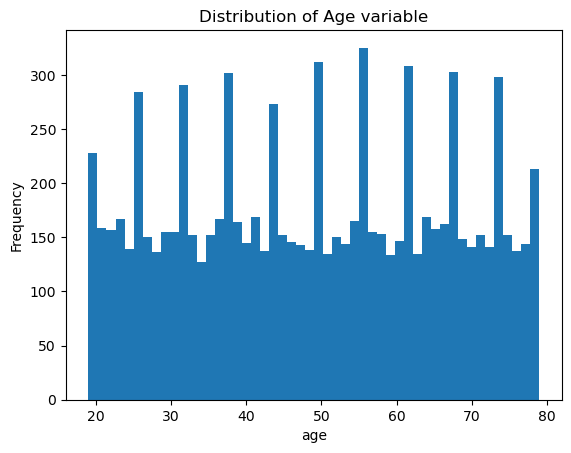

In [34]:
# create a histogram of the DaysSinceCreation variable
plt.hist(campaign['Age'], bins=50)
plt.xlabel('age')
plt.ylabel('Frequency')
plt.title('Distribution of Age variable')
plt.show()

In [35]:
data = campaign['Age']

# Using Z-score method with a threshold of 3
filtered_zscore = remove_outliers_zscore(data, threshold=3)
print("Filtered (Z-score) range:", filtered_zscore.min(), "-", filtered_zscore.max())


Filtered (Z-score) range: 19 - 79


In [36]:
campaign['Age'].describe()

count    8969.000000
mean       48.928755
std        17.293994
min        19.000000
25%        34.000000
50%        49.000000
75%        64.000000
max        79.000000
Name: Age, dtype: float64

In [37]:
#So we don't have to change anything for Age.

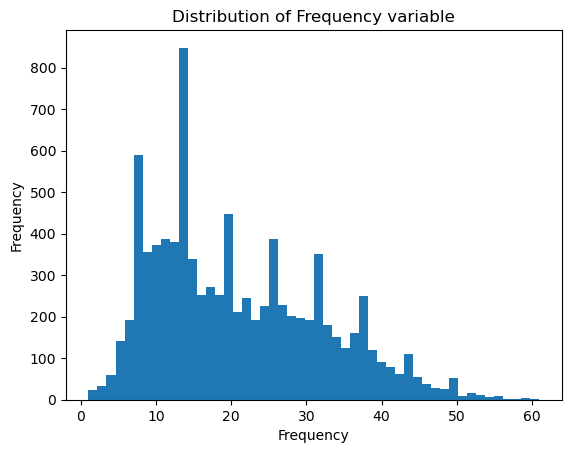

In [38]:
# create a histogram of the DaysSinceCreation variable
plt.hist(campaign['Frequency'], bins=50)
plt.xlabel('Frequency')
plt.ylabel('Frequency')
plt.title('Distribution of Frequency variable')
plt.show()

In [39]:
data = campaign['Frequency']

# Using Z-score method with a threshold of 3
filtered_zscore = remove_outliers_zscore(data, threshold=3)
print("Filtered (Z-score) range:", filtered_zscore.min(), "-", filtered_zscore.max())

Filtered (Z-score) range: 1.0 - 54.0


In [40]:
campaign['Frequency'].describe()

count    8964.000000
mean       20.842146
std        11.206109
min         1.000000
25%        12.000000
50%        18.000000
75%        29.000000
max        61.000000
Name: Frequency, dtype: float64

In [41]:
#We believe that Frequency has a fine distribution and we can keep it, as it is.
#We have to be careful with the outlier removal, because of the predictive part of the project.
#We need to keep as many records that contain a target value.

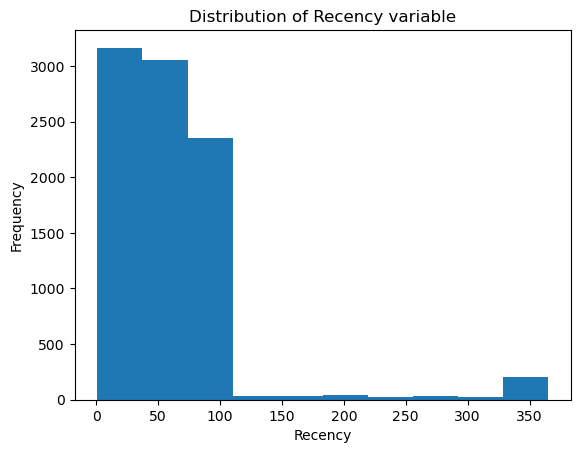

In [42]:
# create a histogram of the DaysSinceCreation variable
plt.hist(campaign['Recency'], bins=10)
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Distribution of Recency variable')
plt.show()

In [43]:
data = campaign['Recency']

# Using Z-score method with a threshold of 3
filtered_zscore = remove_outliers_zscore(data, threshold=3)
print("Filtered (Z-score) range:", filtered_zscore.min(), "-", filtered_zscore.max())

Filtered (Z-score) range: 1.0 - 234.0


In [44]:
#We believe we should not erase these otliers, since they can be regarded as "True Outliers". These are influencial
#Observation. Without more context it is hard to make a conclusion, but we think, these are the people, that 
#responded positively to the campaign last year.

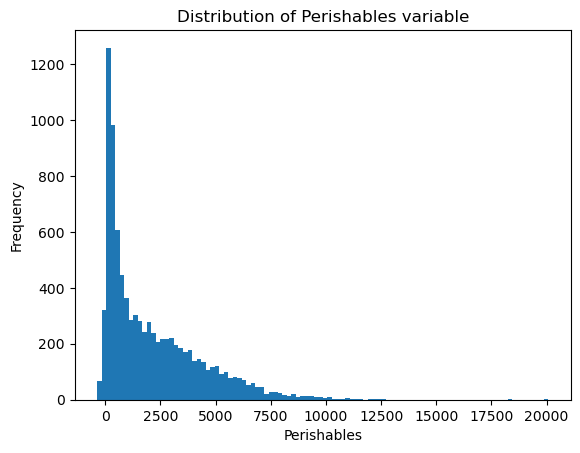

In [45]:
# create a histogram of the DaysSinceCreation variable
plt.hist(campaign['Perishables'], bins=100)
plt.xlabel('Perishables')
plt.ylabel('Frequency')
plt.title('Distribution of Perishables variable')
plt.show()

In [46]:
campaign['Perishables'].describe()

count     8969.000000
mean      2115.131555
std       2161.136220
min       -363.360000
25%        354.280000
50%       1382.300000
75%       3316.880000
max      20073.340000
Name: Perishables, dtype: float64

In [47]:
# Clip the minimum value to 0 since there can't be a negative amount spent. If it was revenue or profit 
# there could have been a negative amount, but since it is the amount the customer spent, the min 
# should be clipped to 0
campaign['Perishables'] = campaign['Perishables'].clip(lower=0)

In [48]:
data = campaign['Perishables']

# Using Z-score method with a threshold of 3
filtered_zscore = remove_outliers_zscore(data, threshold=3)
print("Filtered (Z-score) range:", filtered_zscore.min(), "-", filtered_zscore.max())

Filtered (Z-score) range: 0.0 - 8590.4


In [49]:
# Filter records based on a certain condition (e.g., Perishables >= 12500)
#We believe 8470 is a too hard cut
filtered_perishables = campaign.loc[campaign['Perishables'] >= 12500]

# Remove filtered records from the campaign DataFrame
campaign = campaign.loc[campaign['Perishables'] < 12500]

# Append filtered records to the campaign_outliers DataFrame
campaign_outliers = campaign_outliers.append(filtered_perishables)

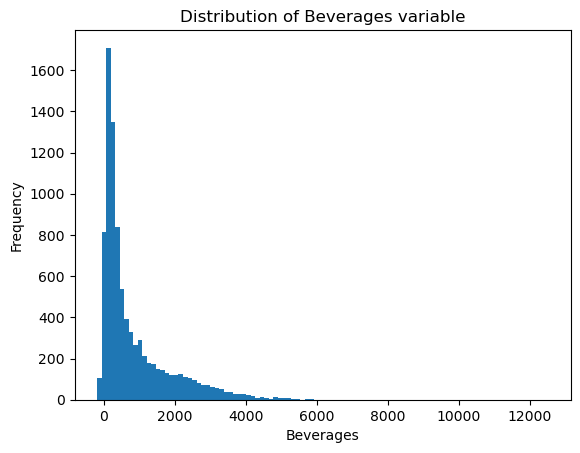

In [50]:
# create a histogram of the DaysSinceCreation variable
plt.hist(campaign['Beverages'], bins=100)
plt.xlabel('Beverages')
plt.ylabel('Frequency')
plt.title('Distribution of Beverages variable')
plt.show()

In [51]:
campaign['Beverages'].describe()

count     8966.000000
mean       825.687348
std        996.937507
min       -190.000000
25%        165.400000
50%        388.660000
75%       1138.980000
max      12524.920000
Name: Beverages, dtype: float64

In [52]:
# Clip the minimum value to 0
campaign['Beverages'] = campaign['Beverages'].clip(lower=0)

In [53]:
data = campaign['Beverages']

# Using Z-score method with a threshold of 3
filtered_zscore = remove_outliers_zscore(data, threshold=3)
print("Filtered (Z-score) range:", filtered_zscore.min(), "-", filtered_zscore.max())

Filtered (Z-score) range: 0.0 - 3809.3599999999997


In [54]:
# Filter records based on a certain condition (Beverages >= 3714) We believe 3714 is too much of a cut. 
#The Distribution towards the end looks good, so we keep more records
filtered_beverages = campaign.loc[campaign['Beverages'] >= 6000]

# Remove filtered records from the campaign DataFrame
campaign = campaign.loc[campaign['Beverages'] < 6000]

# Append filtered records to the campaign_outliers DataFrame
campaign_outliers = campaign_outliers.append(filtered_beverages)

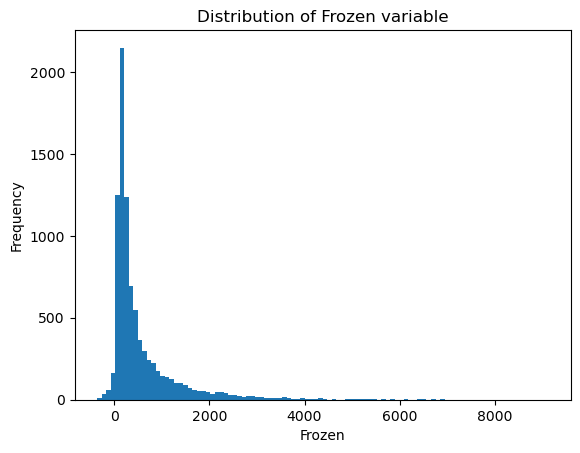

In [55]:
# create a histogram of the DaysSinceCreation variable
plt.hist(campaign['Frozen'], bins=100)
plt.xlabel('Frozen')
plt.ylabel('Frequency')
plt.title('Distribution of Frozen variable')
plt.show()

In [56]:
campaign['Frozen'].describe()

count    8964.000000
mean      577.302316
std       803.185258
min      -354.040000
25%       154.000000
50%       269.080000
75%       660.670000
max      9120.120000
Name: Frozen, dtype: float64

In [57]:
# Clip the minimum value to 0
campaign['Frozen'] = campaign['Frozen'].clip(lower=0)

In [58]:
data = campaign['Frozen']

# Using Z-score method with a threshold of 3
filtered_zscore = remove_outliers_zscore(data, threshold=3)
print("Filtered (Z-score) range:", filtered_zscore.min(), "-", filtered_zscore.max())

Filtered (Z-score) range: 0.0 - 2981.84


In [59]:
# Filter records based on a certain condition (Frozen >= 3600)
#Also here we believe we should keep more variables
filtered_frozen = campaign.loc[campaign['Frozen'] >= 3600]

# Remove filtered records from the campaign DataFrame
campaign = campaign.loc[campaign['Frozen'] < 3600]

# Append filtered records to the campaign_outliers DataFrame
campaign_outliers = campaign_outliers.append(filtered_frozen)

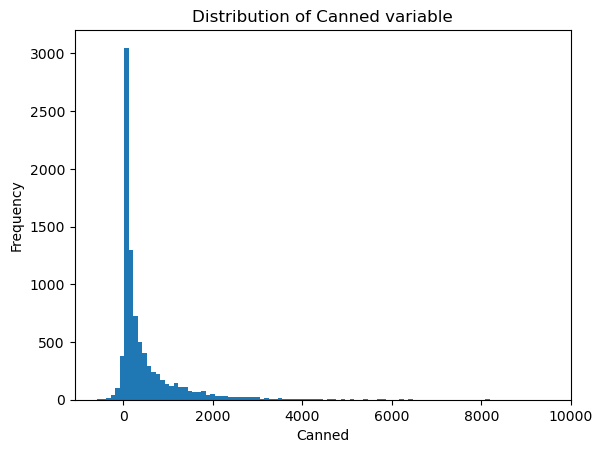

In [60]:
# create a histogram of the DaysSinceCreation variable
plt.hist(campaign['Canned'], bins=100)
plt.xlabel('Canned')
plt.ylabel('Frequency')
plt.title('Distribution of Canned variable')
plt.show()

In [61]:
campaign['Canned'].describe()

count    8846.000000
mean      479.130527
std       755.170524
min      -578.800000
25%        67.040000
50%       182.960000
75%       563.070000
max      9496.400000
Name: Canned, dtype: float64

In [62]:
# Clip the minimum value to 0
campaign['Canned'] = campaign['Canned'].clip(lower=0)

In [63]:
data = campaign['Canned']

# Using Z-score method with a threshold of 3
filtered_zscore = remove_outliers_zscore(data, threshold=3)
print("Filtered (Z-score) range:", filtered_zscore.min(), "-", filtered_zscore.max())

Filtered (Z-score) range: 0.0 - 2730.64


In [64]:
# Filter records based on a certain condition (Canned >= 5000)
#We believe 2419 is a too strong cut. 
filtered_canned = campaign.loc[campaign['Canned'] >= 5000]

# Remove filtered records from the campaign DataFrame
campaign = campaign.loc[campaign['Canned'] < 5000]

# Append filtered records to the campaign_outliers DataFrame
campaign_outliers = campaign_outliers.append(filtered_canned)

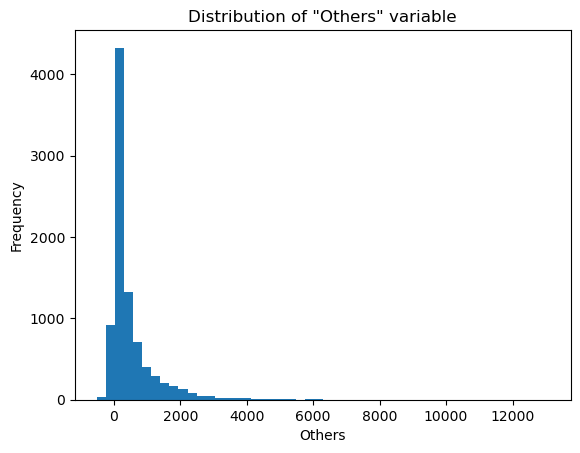

In [65]:
# create a histogram of the DaysSinceCreation variable
plt.hist(campaign['Others'], bins=50)
plt.xlabel('Others')
plt.ylabel('Frequency')
plt.title('Distribution of "Others" variable')
plt.show()

In [66]:
campaign['Canned'].describe()

count    8821.000000
mean      466.706559
std       680.551044
min         0.000000
25%        66.880000
50%       181.400000
75%       558.400000
max      4998.760000
Name: Canned, dtype: float64

In [67]:
# Clip the minimum value to 0
campaign['Others'] = campaign['Others'].clip(lower=0)

In [68]:
data = campaign['Others']

# Using Z-score method with a threshold of 3
filtered_zscore = remove_outliers_zscore(data, threshold=3)
print("Filtered (Z-score) range:", filtered_zscore.min(), "-", filtered_zscore.max())

Filtered (Z-score) range: 0.0 - 2721.6000000000004


In [69]:
# Filter records based on a certain condition (Others >= 4309)
#We believe the distribution looks good and there is no need for a that strong cut like 2700.
filtered_others = campaign.loc[campaign['Others'] >= 4309]

# Remove filtered records from the campaign DataFrame
campaign = campaign.loc[campaign['Others'] < 4309]

# Append filtered records to the campaign_outliers DataFrame
campaign_outliers = campaign_outliers.append(filtered_others)

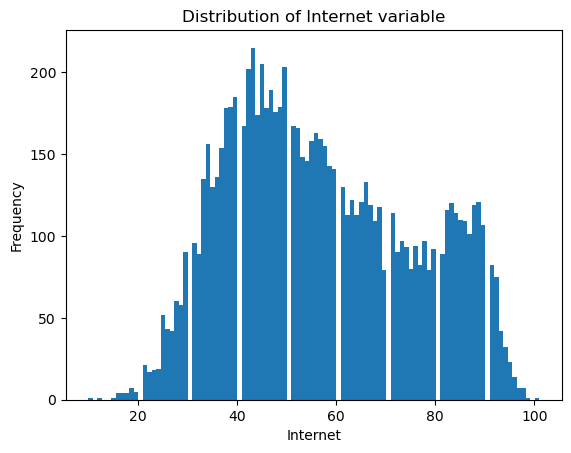

In [70]:
# create a histogram of the DaysSinceCreation variable
plt.hist(campaign['Internet'], bins=100)
plt.xlabel('Internet')
plt.ylabel('Frequency')
plt.title('Distribution of Internet variable')
plt.show()

In [71]:
data = campaign['Internet']

# Using Z-score method with a threshold of 3
filtered_zscore = remove_outliers_zscore(data, threshold=3)
print("Filtered (Z-score) range:", filtered_zscore.min(), "-", filtered_zscore.max())

Filtered (Z-score) range: 10 - 101


In [72]:
campaign['Internet'].describe()

count    8784.000000
mean       57.025501
std        18.579009
min        10.000000
25%        42.000000
50%        54.000000
75%        71.000000
max       101.000000
Name: Internet, dtype: float64

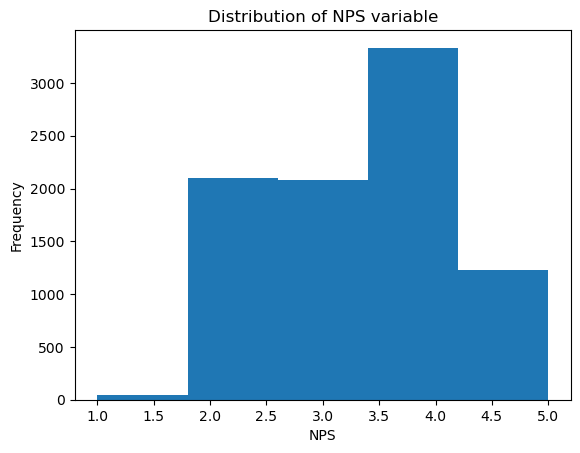

In [73]:
# create a histogram of the DaysSinceCreation variable
plt.hist(campaign['NPS'], bins=5)
plt.xlabel('NPS')
plt.ylabel('Frequency')
plt.title('Distribution of NPS variable')
plt.show()

In [74]:
#Calculate the percentage of data that we kept after removing the outliers
percentage_kept = len(campaign) / len(campaign_backup) * 100

print(f"We kept {percentage_kept:.2f}% of the original data after removing the outliers.")

We kept 97.60% of the original data after removing the outliers.


# Missing Values

In [75]:
#First of all we need to find out, if there is a pattern. Is it missing 
#completely at random (MCAR)
#Missing at random (MAR)
#Missing not at random (MNAR)

#For Recency we can perform KNN, but for the categorical data we need to find a different approach

In [76]:
campaign.isnull().sum()

Education          49
Marital_Status    178
Age                 0
Gender             12
Dependents          0
Income              0
Frequency           5
Recency            15
Perishables         0
Beverages           0
Frozen              0
Canned              0
Others              0
Internet            0
NPS                 0
Target              0
dtype: int64

Now we are going to perform indepence test, to see, if the values are missing completely at random.
This Test explores if missing values are related to the missing of the other variables. 

In [77]:
# Extract the 'Education' variable with missing values
education = campaign['Education']

# Create a binary mask indicating missing values (True) and non-missing values (False)
missing_mask = education.isnull()

# Create a binary matrix indicating missingness patterns in other variables
other_variables = campaign.drop('Education', axis=1)
other_missing_matrix = other_variables.isnull()

# Calculate the contingency table for missingness patterns
contingency_table = pd.crosstab(missing_mask, other_missing_matrix.any(axis=1))

# Calculate the chi-square test statistic
chi2_statistic, p_value = chi2_contingency(contingency_table)[0:2]

# Calculate the degrees of freedom
degrees_of_freedom = (contingency_table.shape[0] - 1) * (contingency_table.shape[1] - 1)

# Select the significance level
significance_level = 0.05

# Calculate the critical chi-square value based on the significance level
critical_value = chi2.ppf(1 - significance_level, degrees_of_freedom)

# Compare the test statistic with the critical value and make a decision
if chi2_statistic > critical_value:
    print("Reject H0: The missing values are not MCAR.")
else:
    print("Fail to reject H0: The missing values are MCAR.")

Fail to reject H0: The missing values are MCAR.


In [78]:
# Extract the 'Marital_Status' variable with missing values
marital_status = campaign['Marital_Status']

# Create a binary mask indicating missing values (True) and non-missing values (False)
missing_mask = marital_status.isnull()

# Create a binary matrix indicating missingness patterns in other variables
other_variables = campaign.drop('Marital_Status', axis=1)
other_missing_matrix = other_variables.isnull()

# Calculate the contingency table for missingness patterns
contingency_table = pd.crosstab(missing_mask, other_missing_matrix.any(axis=1))

# Calculate the chi-square test statistic
chi2_statistic, p_value = chi2_contingency(contingency_table)[0:2]

# Calculate the degrees of freedom
degrees_of_freedom = (contingency_table.shape[0] - 1) * (contingency_table.shape[1] - 1)

# Select the significance level
significance_level = 0.05

# Calculate the critical chi-square value based on the significance level
critical_value = chi2.ppf(1 - significance_level, degrees_of_freedom)

# Compare the test statistic with the critical value and make a decision
if chi2_statistic > critical_value:
    print("Reject H0: The missing values are not MCAR.")
else:
    print("Fail to reject H0: The missing values are MCAR.")

Fail to reject H0: The missing values are MCAR.


We see that both test shows that the variables are missing at complete random. There is no pattern between the missing of marital status and education and the missing of other variables. We can also see that 
Even though it would need more tests to be sure that the variables are missing completely at random, they only show a small fraction of the whole dataset. We will drop the missing records.

In [79]:
campaign = campaign.dropna(subset=['Marital_Status'])
campaign = campaign.dropna(subset=['Education'])

In [80]:
campaign.isnull().sum()

Education          0
Marital_Status     0
Age                0
Gender            12
Dependents         0
Income             0
Frequency          5
Recency           15
Perishables        0
Beverages          0
Frozen             0
Canned             0
Others             0
Internet           0
NPS                0
Target             0
dtype: int64

In [81]:
#Gender has only 12 missing values, we will drop these, too
campaign = campaign.dropna(subset=['Gender'])

In [82]:
campaign.isnull().sum()

Education          0
Marital_Status     0
Age                0
Gender             0
Dependents         0
Income             0
Frequency          5
Recency           15
Perishables        0
Beverages          0
Frozen             0
Canned             0
Others             0
Internet           0
NPS                0
Target             0
dtype: int64

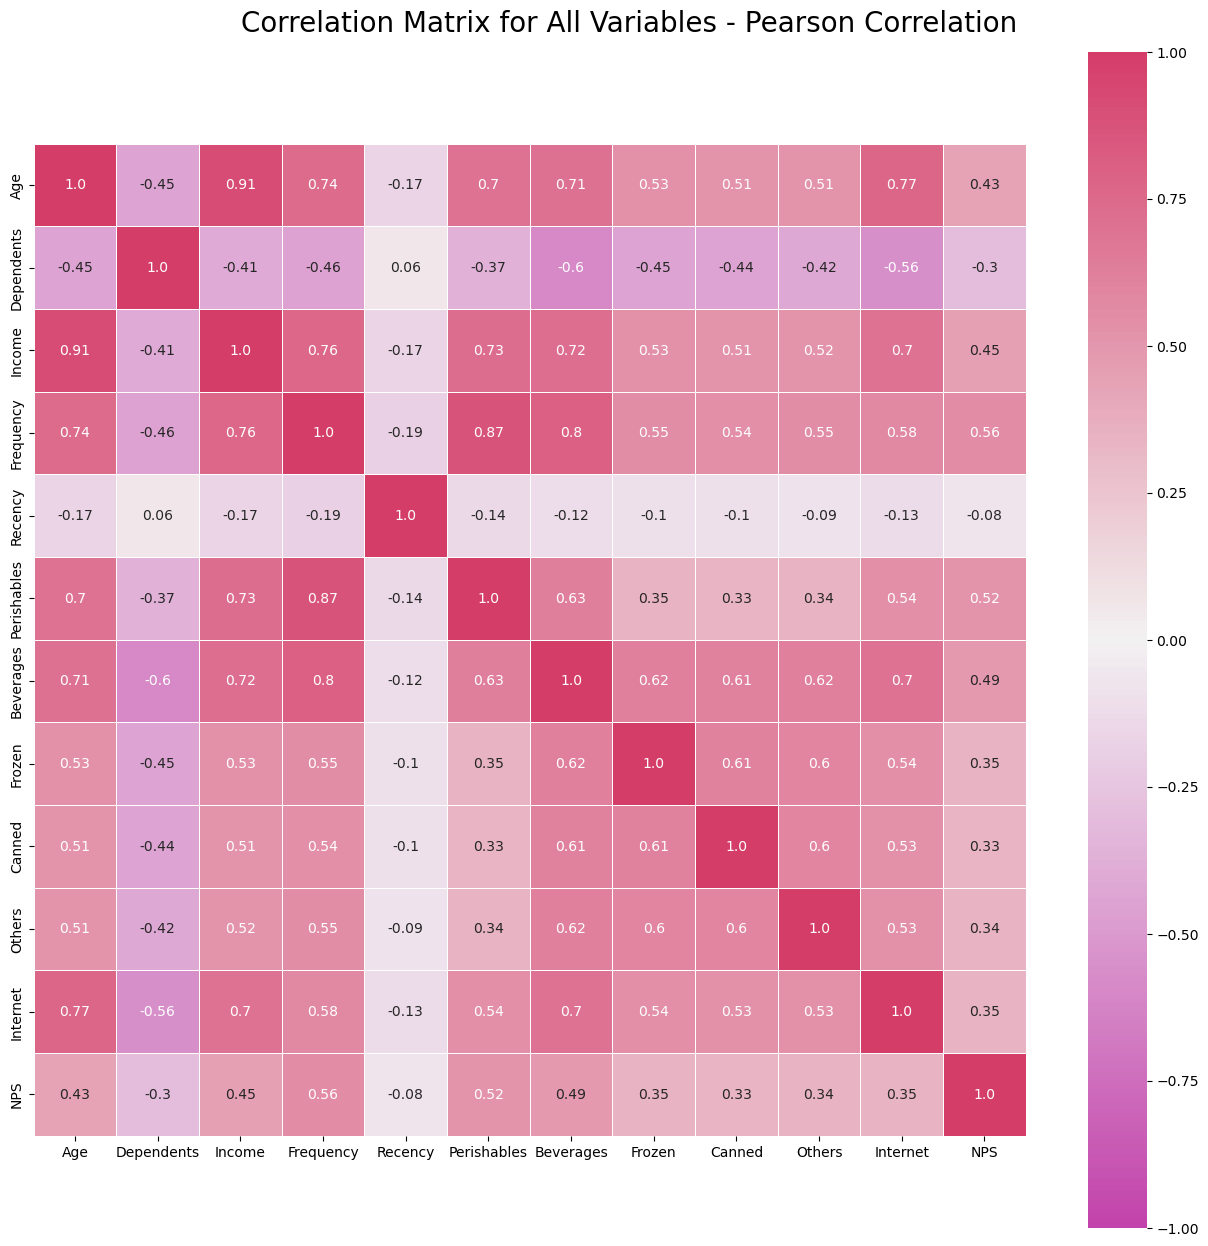

In [83]:
#ploting Pearson's Correlation Matrix for all variables
fig = plt.figure(figsize=(16, 14))

corr = np.round(campaign.corr(method="pearson"), decimals=2)

mask_annot = np.absolute(corr.values) >= 0.01
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(320, 360, as_cmap=True), 
fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=0.5)
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix for All Variables - Pearson Correlation ", fontsize=20)

plt.show()

In [84]:
#We can see that Recency has very weak correlations to all the other variables. This means that performing KNN
#Can be very imprecise

In [85]:
#For the 5 missing values for Frequency we decice to drop them as well, since KNN seems like a very inefficient method
#for these 5 missing values.

In [86]:
campaign = campaign.dropna(subset=['Frequency'])
campaign = campaign.dropna(subset=['Recency'])

In [87]:
campaign.isnull().sum()

Education         0
Marital_Status    0
Age               0
Gender            0
Dependents        0
Income            0
Frequency         0
Recency           0
Perishables       0
Beverages         0
Frozen            0
Canned            0
Others            0
Internet          0
NPS               0
Target            0
dtype: int64

In [88]:
#After cleaning up all the missing values, we now want to look at feature engineering.

# feature engineering

In [89]:
#Total amount of Money spent

In [90]:
# Create a new column 'Total Amount Spent' by summing specific columns
campaign['Total_Amount_Spent'] = campaign[['Perishables', 'Beverages', 'Frozen', 'Canned', 'Others']].sum(axis=1)

# Print the updated DataFrame with the new column
campaign.head()

Education Marital_Status  Age Gender  Dependents   Income  Frequency  \
CustID                                                                        
1            MSc       Together   67      F           0  67696.2       33.0   
2            BSc       Together   40      M           1  43446.0       15.0   
3            MSc         Single   75      M           0  64193.2       37.0   
4            BSc         Single   40      M           1  55898.2       28.0   
5            BSc        Married   26      F           1  14414.4       13.0   

        Recency  Perishables  Beverages   Frozen   Canned  Others  Internet  \
CustID                                                                        
1          74.0      4865.80    2649.32  2152.80  1715.64  244.08        96   
2          17.0       323.76     215.24   170.24   107.68   72.84        52   
3          93.0      5467.00    3218.00  1736.40  1460.20  614.40        92   
4          31.0      3598.00     958.20   259.80   147.80  121.80        59   
5          84.0       263.52     161.52   228.56    57.32  407.52        45   

        NPS Target  Total_Amount_Spent  
CustID                                  
1         5      ?            11627.64  
2         3      ?              889.76  
3         5      ?            12496.00  
4         4      ?             5085.60  
5         2      ?             1118.44

In [91]:
# Now we can see where the income is smaller than the total amount spent, we treat these as imputation errors 
count = (campaign['Income'] < campaign['Total_Amount_Spent']).sum()

print(f"Number of rows where Income is less than Total_Amount_Spent: {count}")


# Drop rows where Income is less than Total_Amount_Spent
campaign.drop(campaign[campaign['Income'] < campaign['Total_Amount_Spent']].index, inplace=True)

# Verify that rows have been dropped
count_after_drop = (campaign['Income'] < campaign['Total_Amount_Spent']).sum()
print(f"Number of rows after dropping: {count_after_drop}")

Number of rows where Income is less than Total_Amount_Spent: 18
Number of rows after dropping: 0


In [92]:
#calculating the ratio income and total amount spent
#Now where we have cleaned income to the full extend, we can create this new variable.

campaign['total_amount_spent_divided_by_income'] = campaign['Total_Amount_Spent'] / campaign['Income']

In [93]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8508 entries, 1 to 9000
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             8508 non-null   object 
 1   Marital_Status                        8508 non-null   object 
 2   Age                                   8508 non-null   int64  
 3   Gender                                8508 non-null   object 
 4   Dependents                            8508 non-null   int64  
 5   Income                                8508 non-null   float64
 6   Frequency                             8508 non-null   float64
 7   Recency                               8508 non-null   float64
 8   Perishables                           8508 non-null   float64
 9   Beverages                             8508 non-null   float64
 10  Frozen                                8508 non-null   float64
 11  Canned           

In [94]:
# Filter the DataFrame to select rows with total_amount_spent equal to 0
zero_amount_spent_rows = campaign[campaign['Total_Amount_Spent'] == 0]

zero_amount_spent_rows.head()

Education Marital_Status  Age Gender  Dependents   Income  Frequency  \
CustID                                                                        
916          BSc         Single   24      M           1  24799.0       12.0   
3377         BSc         Single   24      M           1  18408.0        3.0   
8194         PhD         Single   22      M           1  27782.8       12.0   
8340         BSc         Single   30      F           1  27598.8       16.0   

        Recency  Perishables  Beverages  Frozen  Canned  Others  Internet  \
CustID                                                                      
916         8.0          0.0        0.0     0.0     0.0     0.0        26   
3377       41.0          0.0        0.0     0.0     0.0     0.0        53   
8194       93.0          0.0        0.0     0.0     0.0     0.0        62   
8340       45.0          0.0        0.0     0.0     0.0     0.0        21   

        NPS Target  Total_Amount_Spent  total_amount_spent_divided_by_income  
CustID                                                                        
916       4      ?                 0.0                                   0.0  
3377      3      ?                 0.0                                   0.0  
8194      4      0                 0.0                                   0.0  
8340      2      ?                 0.0                                   0.0

In [95]:
#We found that some records didn't spend any amount of money, so we delete these 4 rows

In [96]:
campaign.drop(campaign[campaign['Total_Amount_Spent'] == 0].index, inplace=True)

In [97]:
# Filter the DataFrame to select rows with total_amount_spent equal to 0
zero_amount_spent_rows = campaign[campaign['Total_Amount_Spent'] == 0]

zero_amount_spent_rows

Empty DataFrame
Columns: [Education, Marital_Status, Age, Gender, Dependents, Income, Frequency, Recency, Perishables, Beverages, Frozen, Canned, Others, Internet, NPS, Target, Total_Amount_Spent, total_amount_spent_divided_by_income]
Index: []

In [98]:
campaign.head()

Education Marital_Status  Age Gender  Dependents   Income  Frequency  \
CustID                                                                        
1            MSc       Together   67      F           0  67696.2       33.0   
2            BSc       Together   40      M           1  43446.0       15.0   
3            MSc         Single   75      M           0  64193.2       37.0   
4            BSc         Single   40      M           1  55898.2       28.0   
5            BSc        Married   26      F           1  14414.4       13.0   

        Recency  Perishables  Beverages   Frozen   Canned  Others  Internet  \
CustID                                                                        
1          74.0      4865.80    2649.32  2152.80  1715.64  244.08        96   
2          17.0       323.76     215.24   170.24   107.68   72.84        52   
3          93.0      5467.00    3218.00  1736.40  1460.20  614.40        92   
4          31.0      3598.00     958.20   259.80   147.80  121.80        59   
5          84.0       263.52     161.52   228.56    57.32  407.52        45   

        NPS Target  Total_Amount_Spent  total_amount_spent_divided_by_income  
CustID                                                                        
1         5      ?            11627.64                              0.171762  
2         3      ?              889.76                              0.020480  
3         5      ?            12496.00                              0.194662  
4         4      ?             5085.60                              0.090980  
5         2      ?             1118.44                              0.077592

# Preparing the Cluster analysis, copying the data set, deleting categorical data

In [99]:
campaign.head()

Education Marital_Status  Age Gender  Dependents   Income  Frequency  \
CustID                                                                        
1            MSc       Together   67      F           0  67696.2       33.0   
2            BSc       Together   40      M           1  43446.0       15.0   
3            MSc         Single   75      M           0  64193.2       37.0   
4            BSc         Single   40      M           1  55898.2       28.0   
5            BSc        Married   26      F           1  14414.4       13.0   

        Recency  Perishables  Beverages   Frozen   Canned  Others  Internet  \
CustID                                                                        
1          74.0      4865.80    2649.32  2152.80  1715.64  244.08        96   
2          17.0       323.76     215.24   170.24   107.68   72.84        52   
3          93.0      5467.00    3218.00  1736.40  1460.20  614.40        92   
4          31.0      3598.00     958.20   259.80   147.80  121.80        59   
5          84.0       263.52     161.52   228.56    57.32  407.52        45   

        NPS Target  Total_Amount_Spent  total_amount_spent_divided_by_income  
CustID                                                                        
1         5      ?            11627.64                              0.171762  
2         3      ?              889.76                              0.020480  
3         5      ?            12496.00                              0.194662  
4         4      ?             5085.60                              0.090980  
5         2      ?             1118.44                              0.077592

In [100]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             8504 non-null   object 
 1   Marital_Status                        8504 non-null   object 
 2   Age                                   8504 non-null   int64  
 3   Gender                                8504 non-null   object 
 4   Dependents                            8504 non-null   int64  
 5   Income                                8504 non-null   float64
 6   Frequency                             8504 non-null   float64
 7   Recency                               8504 non-null   float64
 8   Perishables                           8504 non-null   float64
 9   Beverages                             8504 non-null   float64
 10  Frozen                                8504 non-null   float64
 11  Canned           

In [101]:
#We need different datatypes for clustering and predictive analysis. This is why we create a new data set and a backup.
campaign_cluster = campaign.copy()
campaign_cluster2 = campaign.copy()
campaign_cluster3 = campaign.copy()
campaign_backup = campaign.copy()
campaign_categorical = campaign.copy()
campaign_cluster_second_order = campaign.copy()
campaign_predictive = campaign.copy()
#campaign_cluster = campaign_backup

In [102]:
campaign_cluster_second_order = campaign.copy()

# Cluster Approach 1 (Not Final) product and customer mixed

In [103]:
#First we need to drop all the categorical variables and all customer based variables
#we only want product based variables for now, since we add the customer based variabels later in the correspondence 
#analysis

#Mixed approach

In [104]:
campaign_cluster.drop('Education', axis=1, inplace= True)
campaign_cluster.drop('Gender', axis=1, inplace= True)
campaign_cluster.drop('Marital_Status', axis=1, inplace= True)
campaign_cluster.drop('Dependents', axis=1, inplace= True)
campaign_cluster.drop('NPS', axis=1, inplace= True)

In [105]:
campaign_cluster.drop('Target', axis=1, inplace= True)

In [106]:
#Now we have 8508 Records left. Which are 8508/9000 = 0.945 or 94,5% of the total amount of records.

In [107]:
campaign_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age                                   8504 non-null   int64  
 1   Income                                8504 non-null   float64
 2   Frequency                             8504 non-null   float64
 3   Recency                               8504 non-null   float64
 4   Perishables                           8504 non-null   float64
 5   Beverages                             8504 non-null   float64
 6   Frozen                                8504 non-null   float64
 7   Canned                                8504 non-null   float64
 8   Others                                8504 non-null   float64
 9   Internet                              8504 non-null   int64  
 10  Total_Amount_Spent                    8504 non-null   float64
 11  total_amount_spen

In [108]:
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Scale the values while preserving the index
scaled_values = scaler.fit_transform(campaign_cluster)

# Create a new DataFrame with the scaled values and the original index
campaign_cluster_scaled = pd.DataFrame(scaled_values, index=campaign_cluster.index, columns=campaign_cluster.columns)


In [109]:
campaign_cluster.head()

Age   Income  Frequency  Recency  Perishables  Beverages   Frozen  \
CustID                                                                      
1        67  67696.2       33.0     74.0      4865.80    2649.32  2152.80   
2        40  43446.0       15.0     17.0       323.76     215.24   170.24   
3        75  64193.2       37.0     93.0      5467.00    3218.00  1736.40   
4        40  55898.2       28.0     31.0      3598.00     958.20   259.80   
5        26  14414.4       13.0     84.0       263.52     161.52   228.56   

         Canned  Others  Internet  Total_Amount_Spent  \
CustID                                                  
1       1715.64  244.08        96            11627.64   
2        107.68   72.84        52              889.76   
3       1460.20  614.40        92            12496.00   
4        147.80  121.80        59             5085.60   
5         57.32  407.52        45             1118.44   

        total_amount_spent_divided_by_income  
CustID                                        
1                                   0.171762  
2                                   0.020480  
3                                   0.194662  
4                                   0.090980  
5                                   0.077592

In [110]:
campaign_cluster_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age                                   8504 non-null   float64
 1   Income                                8504 non-null   float64
 2   Frequency                             8504 non-null   float64
 3   Recency                               8504 non-null   float64
 4   Perishables                           8504 non-null   float64
 5   Beverages                             8504 non-null   float64
 6   Frozen                                8504 non-null   float64
 7   Canned                                8504 non-null   float64
 8   Others                                8504 non-null   float64
 9   Internet                              8504 non-null   float64
 10  Total_Amount_Spent                    8504 non-null   float64
 11  total_amount_spen

In [111]:
#Now the dataset is ready for clustering. We don't need a factor analysis before, since we don't have so many variabels

In [112]:
#Cluster Preparation, how many clusters?

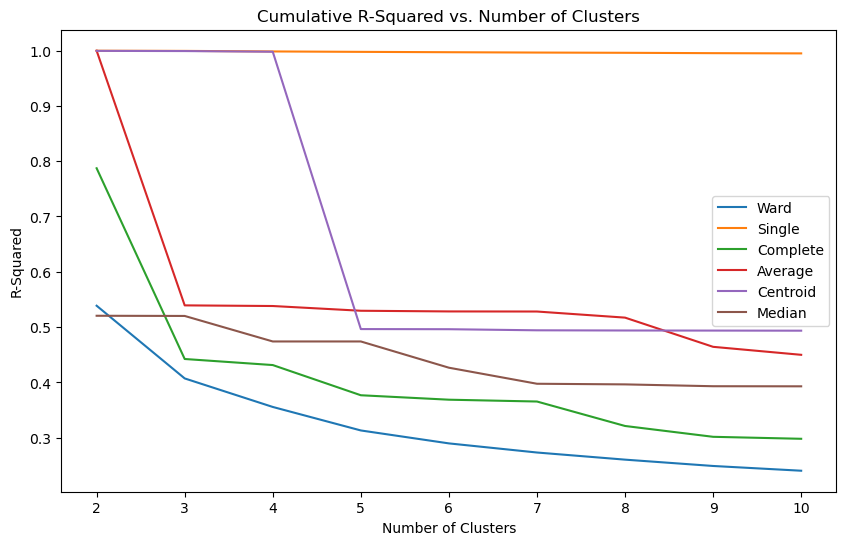

In [113]:
# Define linkage methods
ward_linkage = linkage(campaign_cluster_scaled, method='ward')
single_linkage = linkage(campaign_cluster_scaled, method='single')
complete_linkage = linkage(campaign_cluster_scaled, method='complete')
average_linkage = linkage(campaign_cluster_scaled, method='average')
centroid_linkage = linkage(campaign_cluster_scaled, method='centroid')
median_linkage = linkage(campaign_cluster_scaled, method='median')

# Define dictionary of linkage methods
linkage_methods = {
    'Ward': ward_linkage,
    'Single': single_linkage,
    'Complete': complete_linkage,
    'Average': average_linkage,
    'Centroid': centroid_linkage,
    'Median': median_linkage
}

# Calculate R^2 for each linkage method
r2_scores = {}
for name, linkage_matrix in linkage_methods.items():
    r2_scores[name] = []
    for k in range(2, 11):
        clusters = fcluster(linkage_matrix, k, criterion='maxclust')
        cluster_centers = np.array([campaign_cluster_scaled[clusters == i].mean(axis=0) for i in range(1, k + 1)])
        ss_distances = np.sum((campaign_cluster_scaled - cluster_centers[clusters - 1]) ** 2, axis=1)
        ss_total = np.sum((campaign_cluster_scaled - np.mean(campaign_cluster_scaled, axis=0)) ** 2, axis=1)
        r2_scores[name].append(np.sum(ss_distances) / np.sum(ss_total))

# Plot R^2 for each linkage method
plt.figure(figsize=(10, 6))
for name, scores in r2_scores.items():
    plt.plot(range(2, 11), scores, label=name)
plt.xlabel('Number of Clusters')
plt.ylabel('R-Squared')
plt.title('Cumulative R-Squared vs. Number of Clusters')
plt.legend()
plt.show()

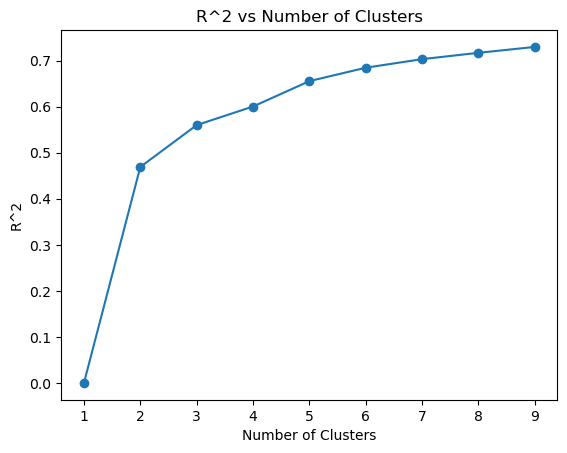

In [114]:
#Comparison R^2 and number of clusters
# Define the range of cluster numbers to test
cluster_range = range(1, 10)

# Create an empty list to store the R^2 values
r2_values = []

# Fit the K-means model for each number of clusters and calculate the R^2
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(campaign_cluster_scaled)
    cluster_labels = kmeans.predict(campaign_cluster_scaled)
    r2 = r2_score(campaign_cluster_scaled, kmeans.cluster_centers_[cluster_labels])
    r2_values.append(r2)

# Plot the R^2 values against the number of clusters
plt.plot(cluster_range, r2_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('R^2')
plt.title('R^2 vs Number of Clusters')
plt.show()

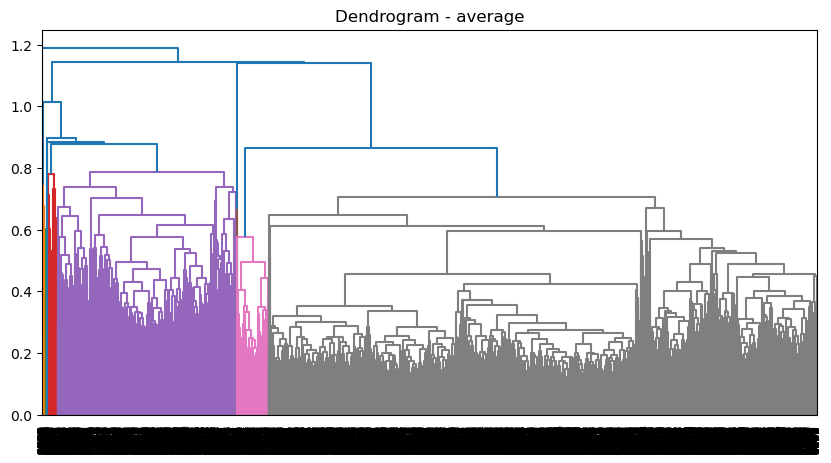

In [115]:
# Hierarchical Approach - centroid
Z = linkage(campaign_cluster_scaled, method='average', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
plt.title("Dendrogram - average")
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
plt.show()

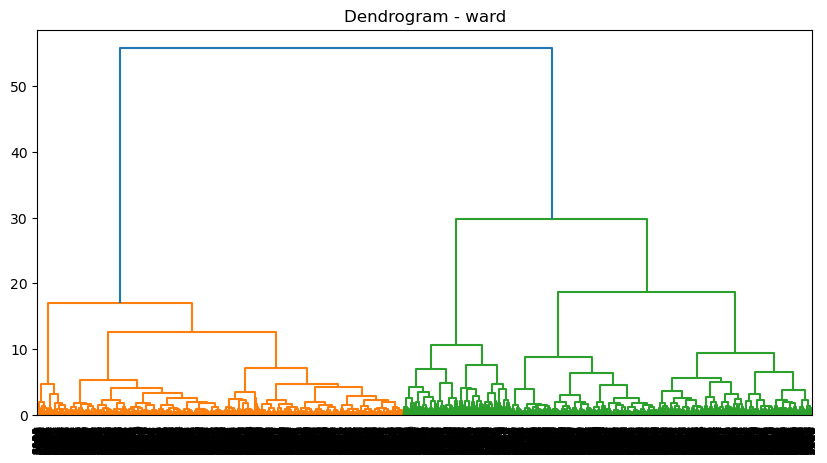

In [116]:
# Hierarchical Approach - centroid
Z = linkage(campaign_cluster_scaled, method='ward', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
plt.title("Dendrogram - ward")
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
plt.show()

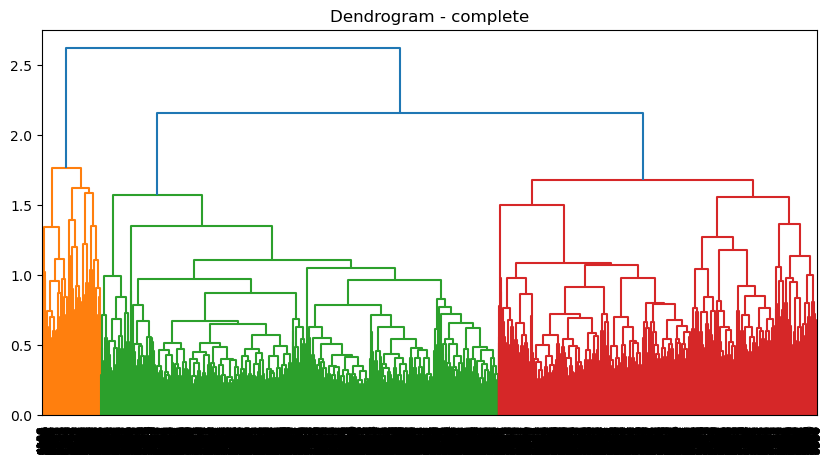

In [117]:
# Hierarchical Approach - centroid
Z = linkage(campaign_cluster_scaled, method='complete', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
plt.title("Dendrogram - complete")
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
plt.show()

In [118]:
#Above is the Dendogram for the Clustering Method Complete. It shows three very nice cluster. 
# This is interesting, even though the other methods would rather suggest to take 2 cluster.

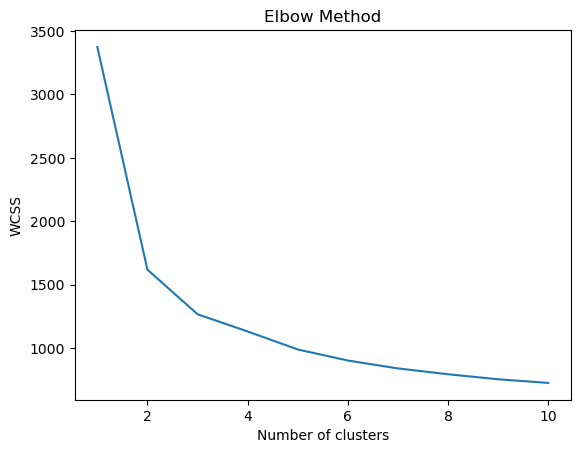

In [119]:
# Initialize empty list to store the WCSS values for each k
wcss = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(campaign_cluster_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(k_range, wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [120]:
#Calculating the optimal number of clusters with the silhouette method
X = campaign_cluster_scaled

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

best_k = silhouette_scores.index(max(silhouette_scores)) + 2  # add 2 because we started with k=2
print("Best number of clusters according to silhouette method:", best_k)

Best number of clusters according to silhouette method: 2


In [121]:
#We proceed with 2 clusters.

In [122]:
campaign_cluster_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age                                   8504 non-null   float64
 1   Income                                8504 non-null   float64
 2   Frequency                             8504 non-null   float64
 3   Recency                               8504 non-null   float64
 4   Perishables                           8504 non-null   float64
 5   Beverages                             8504 non-null   float64
 6   Frozen                                8504 non-null   float64
 7   Canned                                8504 non-null   float64
 8   Others                                8504 non-null   float64
 9   Internet                              8504 non-null   float64
 10  Total_Amount_Spent                    8504 non-null   float64
 11  total_amount_spen

In [123]:
# Set a random seed for reproducibility
random_seed = 42

# Set the number of clusters
n_clusters = 2

# Set the number of initial random seeds
n_init = 2

# Create a KMeans object
kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed, n_init=n_init)

# Perform clustering on campaign_cluster_scaled DataFrame
labels = kmeans.fit_predict(campaign_cluster_scaled)

# Create df_cluster_loadings DataFrame
df_cluster_loadings_all = pd.DataFrame(kmeans.cluster_centers_, columns=campaign_cluster_scaled.columns)

# Create df_with_clusters DataFrame
df_with_clusters_all = campaign_cluster_scaled.copy()
df_with_clusters_all['Cluster'] = labels

# Print df_cluster_loadings DataFrame
df_cluster_loadings_all.head().T


0         1
Age                                   0.789828  0.315684
Income                                0.711654  0.376481
Frequency                             0.509006  0.215849
Recency                               0.136436  0.181586
Perishables                           0.330982  0.073758
Beverages                             0.288145  0.043516
Frozen                                0.276468  0.064641
Canned                                0.194133  0.033368
Others                                0.223761  0.046283
Internet                              0.711240  0.402473
Total_Amount_Spent                    0.451871  0.091219
total_amount_spent_divided_by_income  0.138057  0.053899

Here we see the problem. If the goal is a product segmentation, the data doesn't give so detailed results.
Perishables, Beverages, Frozen, Canned and Others are all bought more by cluster 0. We can see that the cluster with a higher income, will buy more products, in a higher frequency and they buy more on the internet. We can extract some information, but we believe at this point we should try to perform a cluster analysis with only the product variables.

In [124]:
campaign_cluster_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age                                   8504 non-null   float64
 1   Income                                8504 non-null   float64
 2   Frequency                             8504 non-null   float64
 3   Recency                               8504 non-null   float64
 4   Perishables                           8504 non-null   float64
 5   Beverages                             8504 non-null   float64
 6   Frozen                                8504 non-null   float64
 7   Canned                                8504 non-null   float64
 8   Others                                8504 non-null   float64
 9   Internet                              8504 non-null   float64
 10  Total_Amount_Spent                    8504 non-null   float64
 11  total_amount_spen

# Cluster Approach 2 (We did not proceed with that) Only Products

This approach will only do a customer segmentation. We decided for this one, because we want to make a double layer cluster Analysis. First we segment the customer and then we do a second segmentation to cluster the products inside of the Bronze, Silver, Gold Customer

For the Customer groups, we will also perform a correspondence Analysis

In [125]:
campaign_cluster_scaled_products = campaign_cluster_scaled.copy()

In [126]:
campaign_cluster_scaled_products

Age    Income  Frequency   Recency  Perishables  Beverages  \
CustID                                                                    
1       0.800000  0.742122   0.533333  0.200549     0.392938   0.448202   
2       0.350000  0.470688   0.233333  0.043956     0.026145   0.036413   
3       0.933333  0.702913   0.600000  0.252747     0.441488   0.544409   
4       0.350000  0.610066   0.450000  0.082418     0.290557   0.162105   
5       0.116667  0.145734   0.200000  0.228022     0.021281   0.027325   
...          ...       ...        ...       ...          ...        ...   
8996    0.083333  0.230974   0.133333  0.173077     0.009978   0.001671   
8997    0.750000  0.661436   0.483333  0.005495     0.316599   0.121793   
8998    0.483333  0.273382   0.133333  0.159341     0.005596   0.003553   
8999    0.266667  0.332435   0.283333  0.192308     0.070183   0.077645   
9000    0.616667  0.526248   0.266667  0.107143     0.158393   0.059651   

          Frozen    Canned    Others  Internet  Total_Amount_Spent  \
CustID                                                               
1       0.598612  0.345825  0.056670  0.945055            0.602495   
2       0.047337  0.021705  0.016912  0.461538            0.045682   
3       0.482827  0.294336  0.142650  0.901099            0.647524   
4       0.072241  0.029792  0.028279  0.538462            0.263258   
5       0.063554  0.011554  0.094617  0.384615            0.057540   
...          ...       ...       ...       ...                 ...   
8996    0.000000  0.003693  0.000000  0.219780            0.007413   
8997    0.067302  0.030849  0.122869  0.560440            0.288100   
8998    0.000000  0.000000  0.022568  0.604396            0.009266   
8999    0.062731  0.051288  0.015073  0.219780            0.096668   
9000    0.208324  0.010683  0.128274  0.615385            0.189783   

        total_amount_spent_divided_by_income  
CustID                                        
1                                   0.178180  
2                                   0.021084  
3                                   0.201960  
4                                   0.094293  
5                                   0.080391  
...                                      ...  
8996                                0.006971  
8997                                0.095350  
8998                                0.007359  
8999                                0.062368  
9000                                0.078514  

[8504 rows x 12 columns]

In [127]:
campaign_cluster_scaled_products.drop('Income', axis=1, inplace =True)
campaign_cluster_scaled_products.drop('Age', axis=1, inplace =True)

In [128]:
campaign_cluster_scaled_products.drop('Frequency', axis=1, inplace =True)

In [129]:
campaign_cluster_scaled_products.drop('Recency', axis=1, inplace =True)

In [130]:
campaign_cluster_scaled_products.drop('Internet', axis=1, inplace =True)

In [131]:
campaign_cluster_scaled_products.drop('Total_Amount_Spent', axis=1, inplace =True)

In [132]:
campaign_cluster_scaled_products.drop('total_amount_spent_divided_by_income', axis=1, inplace =True)

In [133]:
# Set a random seed for reproducibility
random_seed = 42

# Set the number of clusters
n_clusters = 2

# Set the number of initial random seeds
n_init = 2

# Create a KMeans object
kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed, n_init=n_init)

# Perform clustering on campaign_cluster_scaled DataFrame
labels = kmeans.fit_predict(campaign_cluster_scaled_products)

# Create df_cluster_loadings DataFrame
df_cluster_loadings_products = pd.DataFrame(kmeans.cluster_centers_, columns=campaign_cluster_scaled_products.columns)

# Create df_with_clusters DataFrame
df_with_clusters_products = campaign_cluster_scaled_products.copy()
df_with_clusters_products['Cluster'] = labels

# Print df_cluster_loadings DataFrame
df_cluster_loadings_products.head().T


0         1
Perishables  0.347255  0.101653
Beverages    0.342844  0.055251
Frozen       0.332197  0.071648
Canned       0.235525  0.039026
Others       0.268869  0.052752

In [134]:
#It seems like the buying behaviour variables alone are not ideal for clustering.
#It will just seperate in people who spend money and people who don't spend money. 

In [135]:
#Now we will add customer variables

# Cluster Approach 3 (We decide to proceed with that)

In [136]:
campaign_cluster2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             8504 non-null   object 
 1   Marital_Status                        8504 non-null   object 
 2   Age                                   8504 non-null   int64  
 3   Gender                                8504 non-null   object 
 4   Dependents                            8504 non-null   int64  
 5   Income                                8504 non-null   float64
 6   Frequency                             8504 non-null   float64
 7   Recency                               8504 non-null   float64
 8   Perishables                           8504 non-null   float64
 9   Beverages                             8504 non-null   float64
 10  Frozen                                8504 non-null   float64
 11  Canned           

In [137]:
#We drop all the categorical variables
campaign_cluster2.drop('Dependents', axis=1, inplace= True)
campaign_cluster2.drop('NPS', axis=1, inplace= True)
campaign_cluster2.drop('Target', axis=1, inplace= True)
campaign_cluster2.drop('Marital_Status', axis=1, inplace= True)
campaign_cluster2.drop('Gender', axis=1, inplace= True)

In [138]:
campaign_cluster2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             8504 non-null   object 
 1   Age                                   8504 non-null   int64  
 2   Income                                8504 non-null   float64
 3   Frequency                             8504 non-null   float64
 4   Recency                               8504 non-null   float64
 5   Perishables                           8504 non-null   float64
 6   Beverages                             8504 non-null   float64
 7   Frozen                                8504 non-null   float64
 8   Canned                                8504 non-null   float64
 9   Others                                8504 non-null   float64
 10  Internet                              8504 non-null   int64  
 11  Total_Amount_Spen

In [139]:
campaign_cluster2['Education'].unique()

array(['MSc', 'BSc', 'PhD', 'High School', 'Primary'], dtype=object)

In [140]:
mapping = {
     'PhD' : 21,
     'MSc': 17,
     'BSc': 15,
     'High School': 12,
     'Primary': 9
}

campaign_cluster2['Education'] = campaign_cluster2['Education'].replace(mapping)

In [141]:
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Scale the values while preserving the index
scaled_values = scaler.fit_transform(campaign_cluster2)

# Create a new DataFrame with the scaled values and the original index
campaign_cluster_scaled2 = pd.DataFrame(scaled_values, index=campaign_cluster2.index, columns=campaign_cluster2.columns)

In [142]:
#We drop all the product based variables
campaign_cluster_scaled2.drop('Perishables', axis=1, inplace =True)
campaign_cluster_scaled2.drop('Beverages', axis=1, inplace =True)
campaign_cluster_scaled2.drop('Frozen', axis=1, inplace =True)
campaign_cluster_scaled2.drop('Canned', axis=1, inplace =True)
campaign_cluster_scaled2.drop('Others', axis=1, inplace =True)

In [143]:
campaign_cluster_scaled2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             8504 non-null   float64
 1   Age                                   8504 non-null   float64
 2   Income                                8504 non-null   float64
 3   Frequency                             8504 non-null   float64
 4   Recency                               8504 non-null   float64
 5   Internet                              8504 non-null   float64
 6   Total_Amount_Spent                    8504 non-null   float64
 7   total_amount_spent_divided_by_income  8504 non-null   float64
dtypes: float64(8)
memory usage: 597.9 KB


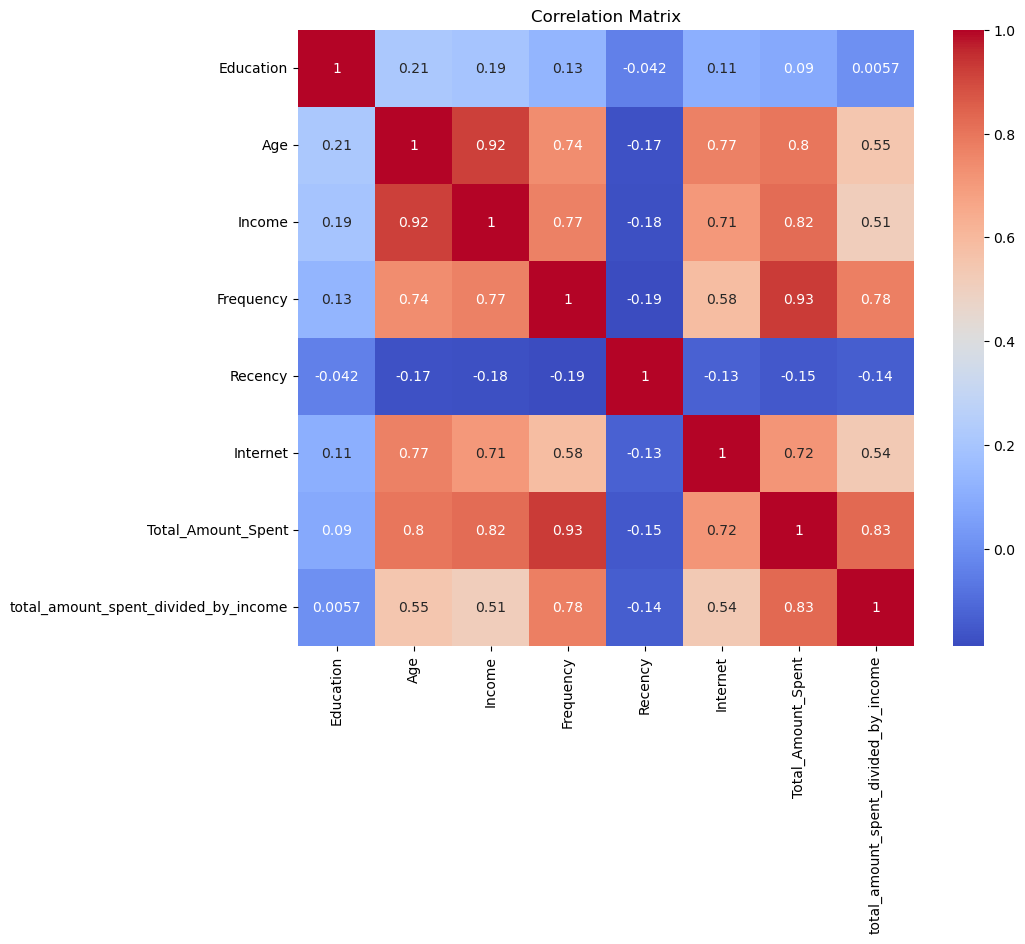

In [144]:
# Create a correlation matrix
correlation_matrix = campaign_cluster_scaled2.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [145]:
#we decide to drop Education, and to associate it later with the correspondence analysis

In [146]:
campaign_cluster_scaled2.drop('Education', axis=1, inplace= True)

In [147]:
#Cluster Preparation PART 2, how many clusters?

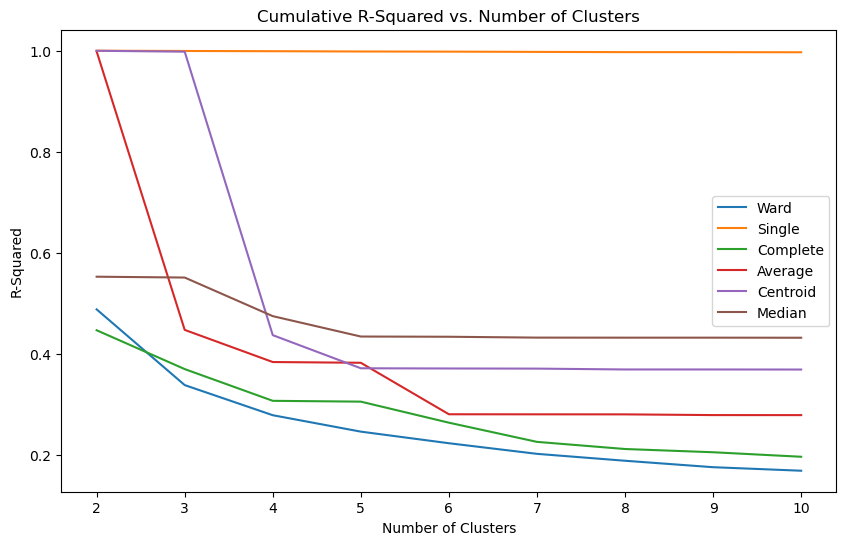

In [148]:
# Define linkage methods
ward_linkage = linkage(campaign_cluster_scaled2, method='ward')
single_linkage = linkage(campaign_cluster_scaled2, method='single')
complete_linkage = linkage(campaign_cluster_scaled2, method='complete')
average_linkage = linkage(campaign_cluster_scaled2, method='average')
centroid_linkage = linkage(campaign_cluster_scaled2, method='centroid')
median_linkage = linkage(campaign_cluster_scaled2, method='median')

# Define dictionary of linkage methods
linkage_methods = {
    'Ward': ward_linkage,
    'Single': single_linkage,
    'Complete': complete_linkage,
    'Average': average_linkage,
    'Centroid': centroid_linkage,
    'Median': median_linkage
}

# Calculate R^2 for each linkage method
r2_scores = {}
for name, linkage_matrix in linkage_methods.items():
    r2_scores[name] = []
    for k in range(2, 11):
        clusters = fcluster(linkage_matrix, k, criterion='maxclust')
        cluster_centers = np.array([campaign_cluster_scaled2[clusters == i].mean(axis=0) for i in range(1, k + 1)])
        ss_distances = np.sum((campaign_cluster_scaled2 - cluster_centers[clusters - 1]) ** 2, axis=1)
        ss_total = np.sum((campaign_cluster_scaled2 - np.mean(campaign_cluster_scaled2, axis=0)) ** 2, axis=1)
        r2_scores[name].append(np.sum(ss_distances) / np.sum(ss_total))

# Plot R^2 for each linkage method
plt.figure(figsize=(10, 6))
for name, scores in r2_scores.items():
    plt.plot(range(2, 11), scores, label=name)
plt.xlabel('Number of Clusters')
plt.ylabel('R-Squared')
plt.title('Cumulative R-Squared vs. Number of Clusters')
plt.legend()
plt.show()

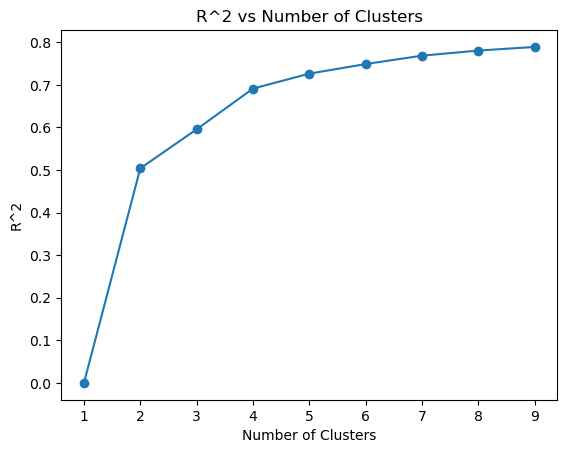

In [149]:
#Comparison R^2 and number of clusters
# Define the range of cluster numbers to test
cluster_range = range(1, 10)

# Create an empty list to store the R^2 values
r2_values = []

# Fit the K-means model for each number of clusters and calculate the R^2
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(campaign_cluster_scaled2)
    cluster_labels = kmeans.predict(campaign_cluster_scaled2)
    r2 = r2_score(campaign_cluster_scaled2, kmeans.cluster_centers_[cluster_labels])
    r2_values.append(r2)

# Plot the R^2 values against the number of clusters
plt.plot(cluster_range, r2_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('R^2')
plt.title('R^2 vs Number of Clusters')
plt.show()

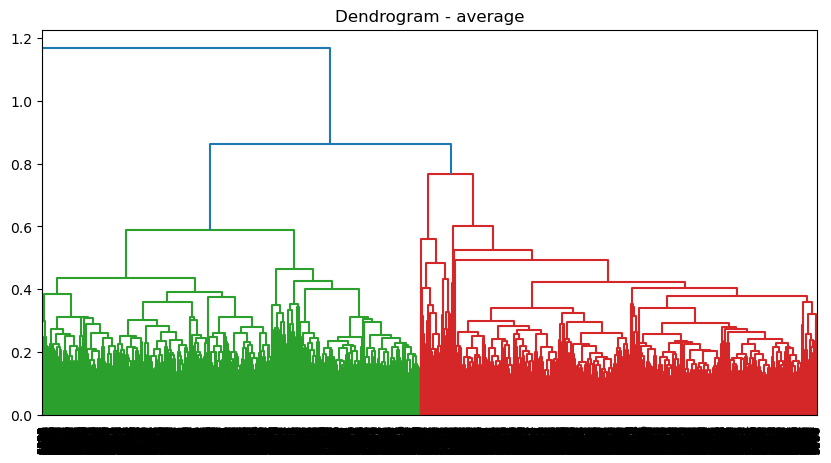

In [150]:
# Hierarchical Approach - centroid
Z = linkage(campaign_cluster_scaled2, method='average', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
plt.title("Dendrogram - average")
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
plt.show()



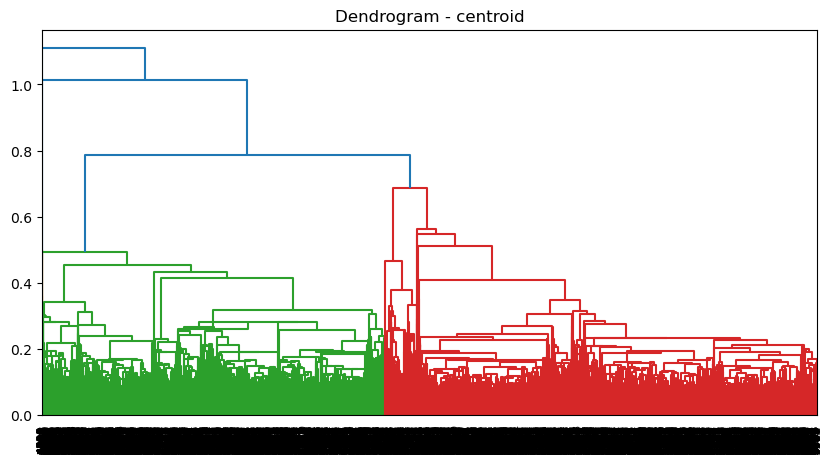

In [151]:
# Hierarchical Approach - centroid
Z = linkage(campaign_cluster_scaled2, method='centroid', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
plt.title("Dendrogram - centroid")
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
plt.show()

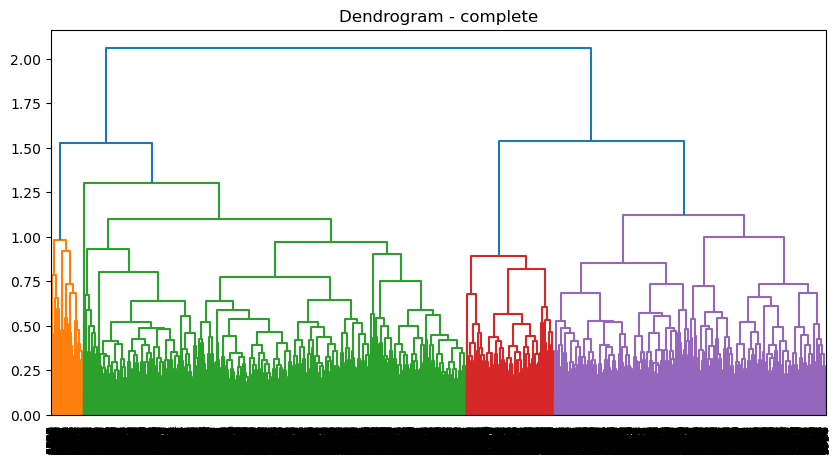

In [152]:
# Hierarchical Approach - complete
Z = linkage(campaign_cluster_scaled2, method='complete', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
plt.title("Dendrogram - complete")
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
plt.show()

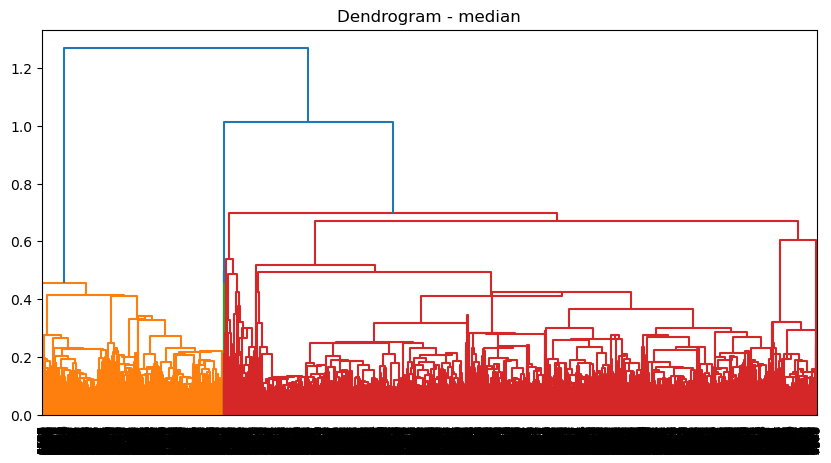

In [153]:
# Hierarchical Approach - median
Z = linkage(campaign_cluster_scaled2, method='median', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
plt.title("Dendrogram - median")
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
plt.show()

In [154]:
#Also testing a second Distance, to see if we get new insights

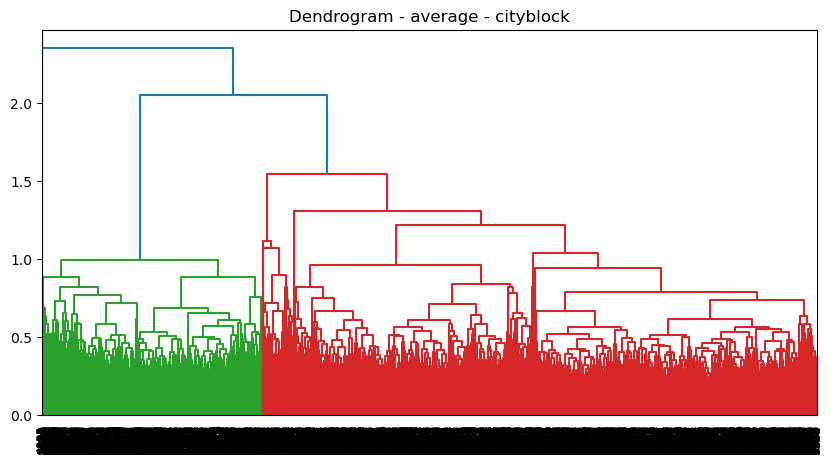

In [155]:
# Hierarchical Approach - average
Z = linkage(campaign_cluster_scaled2, method='average', metric='cityblock')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
plt.title("Dendrogram - average - cityblock")
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
plt.show()

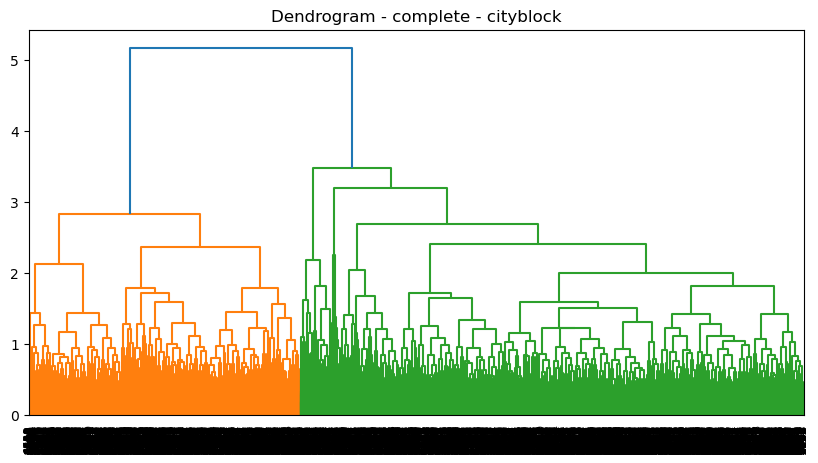

In [156]:
# Hierarchical Approach - average - cityblock
Z = linkage(campaign_cluster_scaled2, method='complete', metric='cityblock')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
plt.title("Dendrogram - complete - cityblock")
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
plt.show()

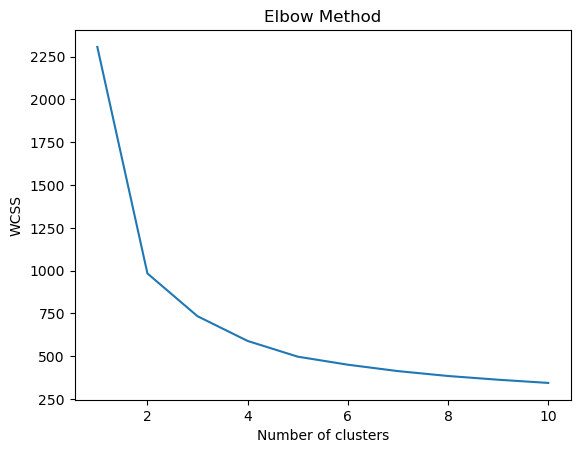

In [157]:
# Initialize empty list to store the WCSS values for each k
wcss = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(campaign_cluster_scaled2)
    wcss.append(kmeans.inertia_)

plt.plot(k_range, wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [158]:
#Calculating the optimal number of clusters with the silhouette method
X = campaign_cluster_scaled2

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

best_k = silhouette_scores.index(max(silhouette_scores)) + 2  # add 2 because we started with k=2
print("Best number of clusters according to silhouette method:", best_k)

Best number of clusters according to silhouette method: 2


In [159]:
#We proceed with 2 clusters.

In [160]:
# Set a random seed for reproducibility
random_seed = 42

# Set the number of clusters
n_clusters = 2

# Set the number of initial random seeds
n_init = 2

# Create a KMeans object
kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed, n_init=n_init)

# Perform clustering on campaign_cluster_scaled2 DataFrame
labels = kmeans.fit_predict(campaign_cluster_scaled2)

# Create df_cluster_loadings DataFrame
df_cluster_loadings_all2 = pd.DataFrame(kmeans.cluster_centers_, columns=campaign_cluster_scaled2.columns)

# Create df_with_clusters DataFrame
df_with_clusters_all2 = campaign_cluster_scaled2.copy()
df_with_clusters_all2['Cluster'] = labels

# Print df_cluster_loadings DataFrame
df_cluster_loadings_all2.head().T


0         1
Age                                   0.773559  0.291981
Income                                0.698336  0.361006
Frequency                             0.488671  0.208437
Recency                               0.136320  0.185018
Internet                              0.695864  0.390407
Total_Amount_Spent                    0.424137  0.084016
total_amount_spent_divided_by_income  0.131035  0.052606

In [161]:
#We tried it with two clusters. It basically gives us a gold and silver segment

In [162]:
campaign_cluster_scaled2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age                                   8504 non-null   float64
 1   Income                                8504 non-null   float64
 2   Frequency                             8504 non-null   float64
 3   Recency                               8504 non-null   float64
 4   Internet                              8504 non-null   float64
 5   Total_Amount_Spent                    8504 non-null   float64
 6   total_amount_spent_divided_by_income  8504 non-null   float64
dtypes: float64(7)
memory usage: 531.5 KB


In [163]:
# Set a random seed for reproducibility
random_seed = 1

# Set the number of clusters
n_clusters = 3

# Set the number of initial random seeds
n_init = 3

# Create a KMeans object
kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed, n_init=n_init)

# Perform clustering on campaign_cluster_scaled2 DataFrame
labels = kmeans.fit_predict(campaign_cluster_scaled2)

# Create df_cluster_loadings DataFrame
df_cluster_loadings_all = pd.DataFrame(kmeans.cluster_centers_, columns=campaign_cluster_scaled2.columns)

# Create df_with_clusters DataFrame
df_with_clusters_all = campaign_cluster_scaled2.copy()
df_with_clusters_all['Cluster'] = labels

# Print df_cluster_loadings DataFrame
df_cluster_loadings_all.head().T


0         1         2
Age                                   0.559374  0.204061  0.837906
Income                                0.545609  0.300066  0.745594
Frequency                             0.317790  0.178950  0.547825
Recency                               0.135168  0.206305  0.137987
Internet                              0.507263  0.363539  0.755236
Total_Amount_Spent                    0.192214  0.059724  0.507442
total_amount_spent_divided_by_income  0.076818  0.048257  0.149244

We decide to go for three clusters, to have a gold, silver and bronze Segment. It is very evenly cut. We believe, that even though the statistical methods tell us to take 2 clusters, that three clusters will give us more insights, especially with further correspondence analysis.
We can see that three clusters almost evenly split the data into a Bronze, Silver and Gold segment.

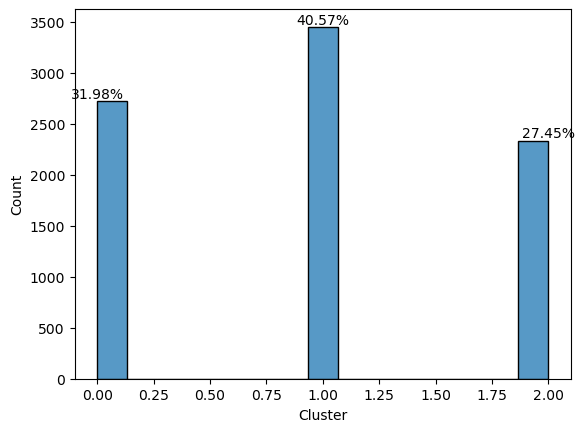

In [164]:
# Plot the histogram
sns.histplot(data=df_with_clusters_all, x='Cluster')

# Calculate percentage distribution
total_count = len(df_with_clusters_all['Cluster'])
counts = df_with_clusters_all['Cluster'].value_counts()
percentages = counts / total_count * 100

# Add text with percentage distribution on top of bars
for category, percentage in percentages.iteritems():
    plt.text(category, counts[category], f"{percentage:.2f}%", ha='center', va='bottom')

# Display the plot
plt.show()


It is quite evenly distributed in the three clusters.

In [165]:
df_with_clusters_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age                                   8504 non-null   float64
 1   Income                                8504 non-null   float64
 2   Frequency                             8504 non-null   float64
 3   Recency                               8504 non-null   float64
 4   Internet                              8504 non-null   float64
 5   Total_Amount_Spent                    8504 non-null   float64
 6   total_amount_spent_divided_by_income  8504 non-null   float64
 7   Cluster                               8504 non-null   int32  
dtypes: float64(7), int32(1)
memory usage: 822.8 KB


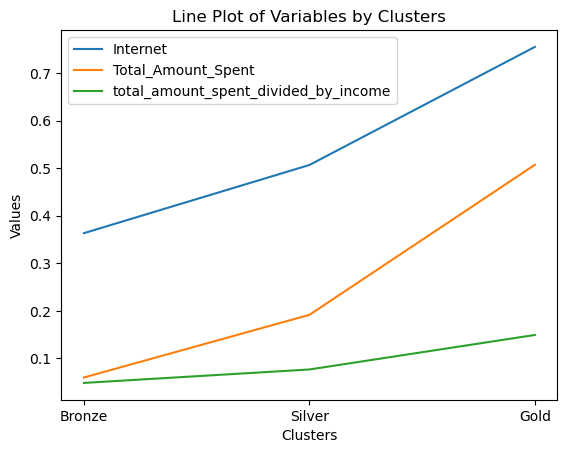

In [166]:
x = [0, 1, 2]
cluster_order = [1, 0, 2]  # Updated cluster order

variables = ['Internet', 'Total_Amount_Spent', 'total_amount_spent_divided_by_income']

for var in variables:
    plt.plot(x, df_with_clusters_all.groupby('Cluster')[var].mean()[cluster_order], label=var)

plt.xlabel('Clusters')
plt.ylabel('Values')
plt.title('Line Plot of Variables by Clusters')
plt.legend()
plt.xticks(x, ['Bronze', 'Silver', 'Gold'])
plt.show()


We can conclude that cluster 2 is the gold segment, cluster 0 is the silver segment and cluster 1 is the bronze segment

Even though the statistical methods showed the ideal number clusters to be 2, we believe for practical reasons it is good to implement a third cluster. This third cluster represents a middle class. In general it can be said, that the clusters actually segment into income classes. 

In [167]:
# Print df_with_clusters DataFrame
df_with_clusters_all.head()

Age    Income  Frequency   Recency  Internet  Total_Amount_Spent  \
CustID                                                                          
1       0.800000  0.742122   0.533333  0.200549  0.945055            0.602495   
2       0.350000  0.470688   0.233333  0.043956  0.461538            0.045682   
3       0.933333  0.702913   0.600000  0.252747  0.901099            0.647524   
4       0.350000  0.610066   0.450000  0.082418  0.538462            0.263258   
5       0.116667  0.145734   0.200000  0.228022  0.384615            0.057540   

        total_amount_spent_divided_by_income  Cluster  
CustID                                                 
1                                   0.178180        2  
2                                   0.021084        1  
3                                   0.201960        2  
4                                   0.094293        0  
5                                   0.080391        1

In [168]:
df_with_clusters_all['Cluster'].unique()

array([2, 1, 0], dtype=int32)

In [169]:
#Dropping all Columns, except for Cluster
df_with_clusters_all = df_with_clusters_all[['Cluster']]

In [170]:
campaign_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             8504 non-null   object 
 1   Marital_Status                        8504 non-null   object 
 2   Age                                   8504 non-null   int64  
 3   Gender                                8504 non-null   object 
 4   Dependents                            8504 non-null   int64  
 5   Income                                8504 non-null   float64
 6   Frequency                             8504 non-null   float64
 7   Recency                               8504 non-null   float64
 8   Perishables                           8504 non-null   float64
 9   Beverages                             8504 non-null   float64
 10  Frozen                                8504 non-null   float64
 11  Canned           

In [171]:
campaign_cluster_scaled2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age                                   8504 non-null   float64
 1   Income                                8504 non-null   float64
 2   Frequency                             8504 non-null   float64
 3   Recency                               8504 non-null   float64
 4   Internet                              8504 non-null   float64
 5   Total_Amount_Spent                    8504 non-null   float64
 6   total_amount_spent_divided_by_income  8504 non-null   float64
dtypes: float64(7)
memory usage: 789.5 KB


In [172]:
df_with_clusters_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Cluster  8504 non-null   int32
dtypes: int32(1)
memory usage: 357.7 KB


In [173]:
campaign_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             8504 non-null   object 
 1   Marital_Status                        8504 non-null   object 
 2   Age                                   8504 non-null   int64  
 3   Gender                                8504 non-null   object 
 4   Dependents                            8504 non-null   int64  
 5   Income                                8504 non-null   float64
 6   Frequency                             8504 non-null   float64
 7   Recency                               8504 non-null   float64
 8   Perishables                           8504 non-null   float64
 9   Beverages                             8504 non-null   float64
 10  Frozen                                8504 non-null   float64
 11  Canned           

In [174]:
# Join the datasets using the index
ds_ca_concat = campaign_categorical.join(df_with_clusters_all, how='inner')

In [175]:
ds_ca_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             8504 non-null   object 
 1   Marital_Status                        8504 non-null   object 
 2   Age                                   8504 non-null   int64  
 3   Gender                                8504 non-null   object 
 4   Dependents                            8504 non-null   int64  
 5   Income                                8504 non-null   float64
 6   Frequency                             8504 non-null   float64
 7   Recency                               8504 non-null   float64
 8   Perishables                           8504 non-null   float64
 9   Beverages                             8504 non-null   float64
 10  Frozen                                8504 non-null   float64
 11  Canned           

In [176]:
#Now that we have a product based segmentation, we can add the categorical variables and the customer based 
#variables

In [177]:
#In order to do this, we need to transform the data and drop target.

In [178]:
ds_ca_concat.drop('Perishables', axis=1, inplace =True)
ds_ca_concat.drop('Beverages', axis=1, inplace =True)
ds_ca_concat.drop('Frozen', axis=1, inplace =True)
ds_ca_concat.drop('Canned', axis=1, inplace =True)
ds_ca_concat.drop('Others', axis=1, inplace =True)
ds_ca_concat.drop('Total_Amount_Spent', axis=1, inplace =True)
ds_ca_concat.drop('total_amount_spent_divided_by_income', axis=1, inplace =True)
ds_ca_concat.drop('Target', axis=1, inplace =True)
ds_ca_concat.drop('Internet', axis=1, inplace =True)
ds_ca_concat.drop('Frequency', axis=1, inplace =True)
ds_ca_concat.drop('Recency', axis=1, inplace =True)

In [179]:
ds_ca_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Education       8504 non-null   object 
 1   Marital_Status  8504 non-null   object 
 2   Age             8504 non-null   int64  
 3   Gender          8504 non-null   object 
 4   Dependents      8504 non-null   int64  
 5   Income          8504 non-null   float64
 6   NPS             8504 non-null   int64  
 7   Cluster         8504 non-null   int32  
dtypes: float64(1), int32(1), int64(3), object(3)
memory usage: 822.8+ KB


In [180]:
#Now we need to transform Age and Income into bins

In [181]:
ds_ca_concat['Age'].describe()

count    8504.000000
mean       48.465428
std        17.144054
min        19.000000
25%        34.000000
50%        48.500000
75%        63.000000
max        79.000000
Name: Age, dtype: float64

In [182]:
#Putting Age in Brackets

# Define the step size
step_size = 10

# Define the start and end values for Age
age_start = 18
age_end = 79

# Create a copy of the DataFrame
ds_ca_concat_segmented = ds_ca_concat.copy()

# Segment the 'Age' variable and create a new column 'Age_brackets'
ds_ca_concat_segmented['Age_brackets'] = pd.cut(ds_ca_concat_segmented['Age'], bins=range(age_start, age_end+step_size, step_size))

# Convert the 'Age_brackets' column to object type
ds_ca_concat_segmented['Age_brackets'] = ds_ca_concat_segmented['Age_brackets'].astype(str)

# Print the updated DataFrame
ds_ca_concat_segmented.describe()


Age   Dependents        Income          NPS      Cluster
count  8504.000000  8504.000000   8504.000000  8504.000000  8504.000000
mean     48.465428     0.698142  46107.304892     3.410748     0.954610
std      17.144054     0.459091  18475.302759     1.013159     0.769622
min      19.000000     0.000000   1394.400000     1.000000     0.000000
25%      34.000000     0.000000  31338.600000     3.000000     0.000000
50%      48.500000     1.000000  46158.100000     4.000000     1.000000
75%      63.000000     1.000000  60594.100000     4.000000     2.000000
max      79.000000     1.000000  90735.200000     5.000000     2.000000

In [183]:
ds_ca_concat_segmented.isna().sum()

Education         0
Marital_Status    0
Age               0
Gender            0
Dependents        0
Income            0
NPS               0
Cluster           0
Age_brackets      0
dtype: int64

In [184]:
ds_ca_concat_segmented.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Education       8504 non-null   object 
 1   Marital_Status  8504 non-null   object 
 2   Age             8504 non-null   int64  
 3   Gender          8504 non-null   object 
 4   Dependents      8504 non-null   int64  
 5   Income          8504 non-null   float64
 6   NPS             8504 non-null   int64  
 7   Cluster         8504 non-null   int32  
 8   Age_brackets    8504 non-null   object 
dtypes: float64(1), int32(1), int64(3), object(4)
memory usage: 889.2+ KB


<AxesSubplot:xlabel='Age_brackets', ylabel='Count'>

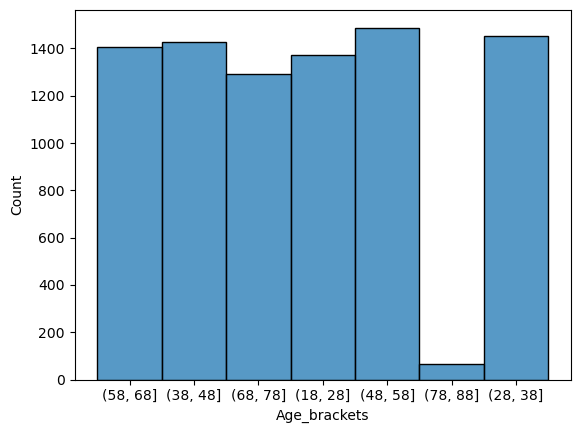

In [185]:
# Plot the histogram
sns.histplot(data=ds_ca_concat_segmented, x='Age_brackets')

In [186]:
ds_ca_concat_segmented.head()

Education Marital_Status  Age Gender  Dependents   Income  NPS  \
CustID                                                                  
1            MSc       Together   67      F           0  67696.2    5   
2            BSc       Together   40      M           1  43446.0    3   
3            MSc         Single   75      M           0  64193.2    5   
4            BSc         Single   40      M           1  55898.2    4   
5            BSc        Married   26      F           1  14414.4    2   

        Cluster Age_brackets  
CustID                        
1             2     (58, 68]  
2             1     (38, 48]  
3             2     (68, 78]  
4             0     (38, 48]  
5             1     (18, 28]

In [187]:
#Now we can drop the Age variable
#ds_ca_concat_segmented.drop('Age', axis=1, inplace= True)

In [188]:
ds_ca_concat_segmented['Income'].describe()

count     8504.000000
mean     46107.304892
std      18475.302759
min       1394.400000
25%      31338.600000
50%      46158.100000
75%      60594.100000
max      90735.200000
Name: Income, dtype: float64

In [189]:
#Putting Income in Brackets

# Define the step size
step_size_income = 10000

# Define the start and end values for Income
income_start = 0
income_end = 100000

# Create a copy of the DataFrame
ds_ca_concat_segmented_income = ds_ca_concat.copy()

# Segment the 'Income' variable and create a new column 'Income_brackets'
ds_ca_concat_segmented_income['Income_brackets'] = pd.cut(ds_ca_concat_segmented_income['Income'], bins=range(income_start, income_end+step_size_income, step_size_income))

# Convert the 'Income_brackets' column to object type
ds_ca_concat_segmented_income['Income_brackets'] = ds_ca_concat_segmented_income['Income_brackets'].astype(str)

# Print the updated DataFrame
ds_ca_concat_segmented_income.describe()


Age   Dependents        Income          NPS      Cluster
count  8504.000000  8504.000000   8504.000000  8504.000000  8504.000000
mean     48.465428     0.698142  46107.304892     3.410748     0.954610
std      17.144054     0.459091  18475.302759     1.013159     0.769622
min      19.000000     0.000000   1394.400000     1.000000     0.000000
25%      34.000000     0.000000  31338.600000     3.000000     0.000000
50%      48.500000     1.000000  46158.100000     4.000000     1.000000
75%      63.000000     1.000000  60594.100000     4.000000     2.000000
max      79.000000     1.000000  90735.200000     5.000000     2.000000

In [190]:
#Now we can drop Income
ds_ca_concat_segmented.drop('Income', axis=1, inplace= True)

In [191]:
ds_ca_concat_segmented.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Education       8504 non-null   object
 1   Marital_Status  8504 non-null   object
 2   Age             8504 non-null   int64 
 3   Gender          8504 non-null   object
 4   Dependents      8504 non-null   int64 
 5   NPS             8504 non-null   int64 
 6   Cluster         8504 non-null   int32 
 7   Age_brackets    8504 non-null   object
dtypes: int32(1), int64(3), object(4)
memory usage: 822.8+ KB


Quick exploration of the variable "Dependents".

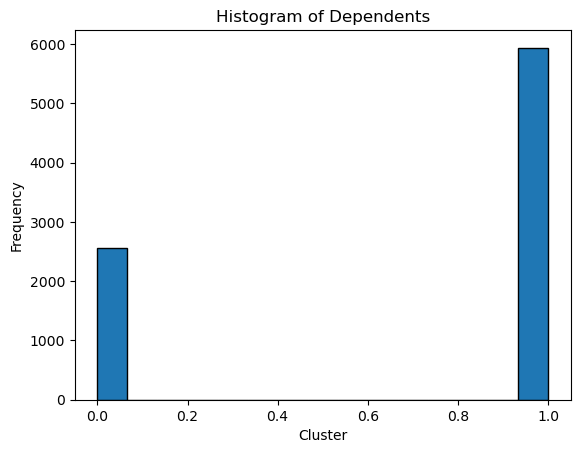

In [192]:
# Plot histogram
plt.hist(ds_ca_concat_segmented['Dependents'], bins='auto', edgecolor='black')

# Add labels and title
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Histogram of Dependents')

# Show the plot
plt.show()

In [193]:
ds_ca_concat_segmented.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Education       8504 non-null   object
 1   Marital_Status  8504 non-null   object
 2   Age             8504 non-null   int64 
 3   Gender          8504 non-null   object
 4   Dependents      8504 non-null   int64 
 5   NPS             8504 non-null   int64 
 6   Cluster         8504 non-null   int32 
 7   Age_brackets    8504 non-null   object
dtypes: int32(1), int64(3), object(4)
memory usage: 822.8+ KB


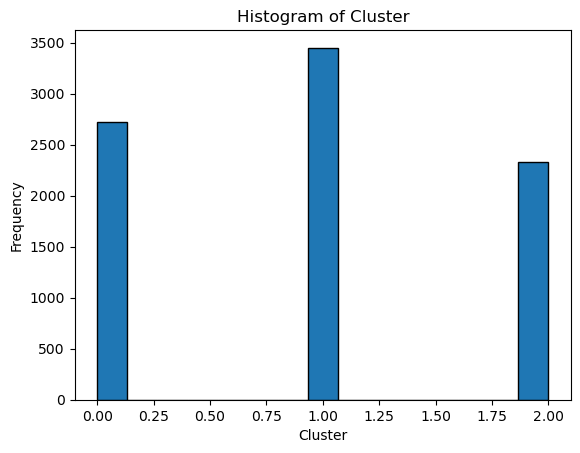

In [194]:
# Plot histogram
plt.hist(ds_ca_concat_segmented['Cluster'], bins='auto', edgecolor='black')

# Add labels and title
plt.xlabel('Cluster')
plt.ylabel('Frequency') 
plt.title('Histogram of Cluster')

# Show the plot
plt.show()

In [195]:
ds_ca_concat_segmented.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Education       8504 non-null   object
 1   Marital_Status  8504 non-null   object
 2   Age             8504 non-null   int64 
 3   Gender          8504 non-null   object
 4   Dependents      8504 non-null   int64 
 5   NPS             8504 non-null   int64 
 6   Cluster         8504 non-null   int32 
 7   Age_brackets    8504 non-null   object
dtypes: int32(1), int64(3), object(4)
memory usage: 822.8+ KB


In [196]:
ds_ca_concat_segmented.isna().sum()

Education         0
Marital_Status    0
Age               0
Gender            0
Dependents        0
NPS               0
Cluster           0
Age_brackets      0
dtype: int64

In [197]:
ds_ca_concat_segmented.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Education       8504 non-null   object
 1   Marital_Status  8504 non-null   object
 2   Age             8504 non-null   int64 
 3   Gender          8504 non-null   object
 4   Dependents      8504 non-null   int64 
 5   NPS             8504 non-null   int64 
 6   Cluster         8504 non-null   int32 
 7   Age_brackets    8504 non-null   object
dtypes: int32(1), int64(3), object(4)
memory usage: 822.8+ KB


# Correspondence Analysis

Cluster         0     1     2
Education                    
BSc          1399  1628  1214
High School   454   578   368
MSc           446   401   410
PhD           209   187   175
Primary       212   656   167


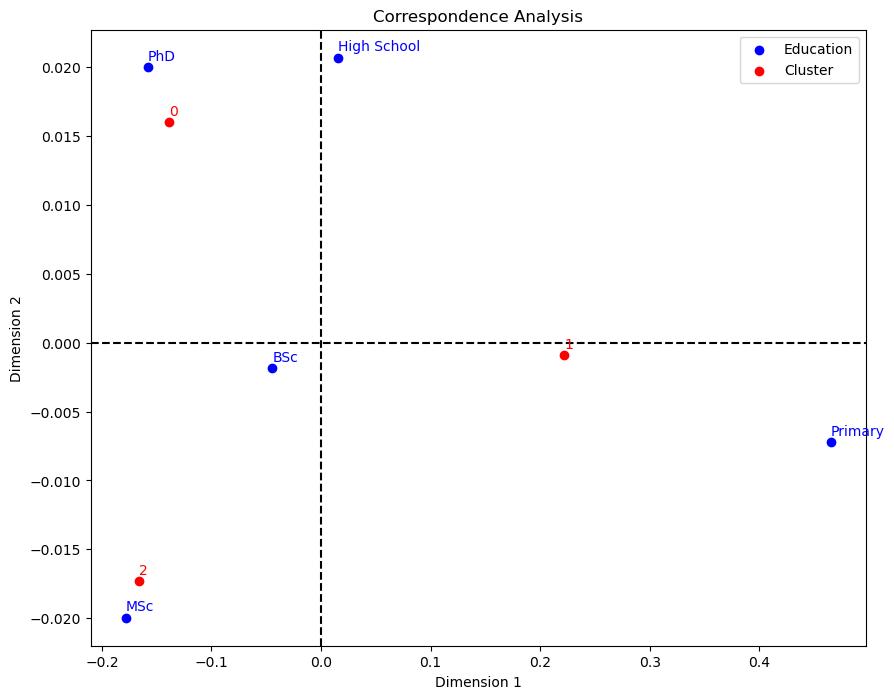

In [198]:
# Step 2: Create a contingency table
contingency_table_G = pd.crosstab(ds_ca_concat_segmented["Education"], ds_ca_concat_segmented['Cluster'])

# Step 3: Perform correspondence analysis
ca_g = prince.CA(n_components=2, random_state=42)
ca_g.fit(contingency_table_G)

print(contingency_table_G)

# Step 4: Get the row and column coordinates
row_coords_g = ca_g.row_coordinates(contingency_table_G)
column_coords_g = ca_g.column_coordinates(contingency_table_G)

# Step 5: Plot the correspondence analysis
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(row_coords_g.iloc[:,0], row_coords_g.iloc[:, 1], c='blue', label='Education')
ax.scatter(column_coords_g.iloc[:, 0], column_coords_g.iloc[:,1], c='red', label='Cluster')
ax.legend()

# Add labels to data points
label_shift = -0.0005  # Adjust this value to control the label positioning
for i, txt in enumerate(row_coords_g.index):
    ax.annotate(txt, (row_coords_g.iloc[i, 0], row_coords_g.iloc[i, 1] - label_shift), color='blue')
for i, txt in enumerate(column_coords_g.index):
    ax.annotate(txt, (column_coords_g.iloc[i, 0], column_coords_g.iloc[i, 1] - label_shift), color='red')

# Add a line through the coordinate (0, 0)
ax.axhline(0, color='black', linestyle='--')
ax.axvline(0, color='black', linestyle='--')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Correspondence Analysis')
plt.legend()
plt.show()


Cluster            0     1    2
Marital_Status                 
Divorced         292   128  230
Married         1076  1123  941
Single           550  1406  294
Together         702   764  580
Widow            100    29  289


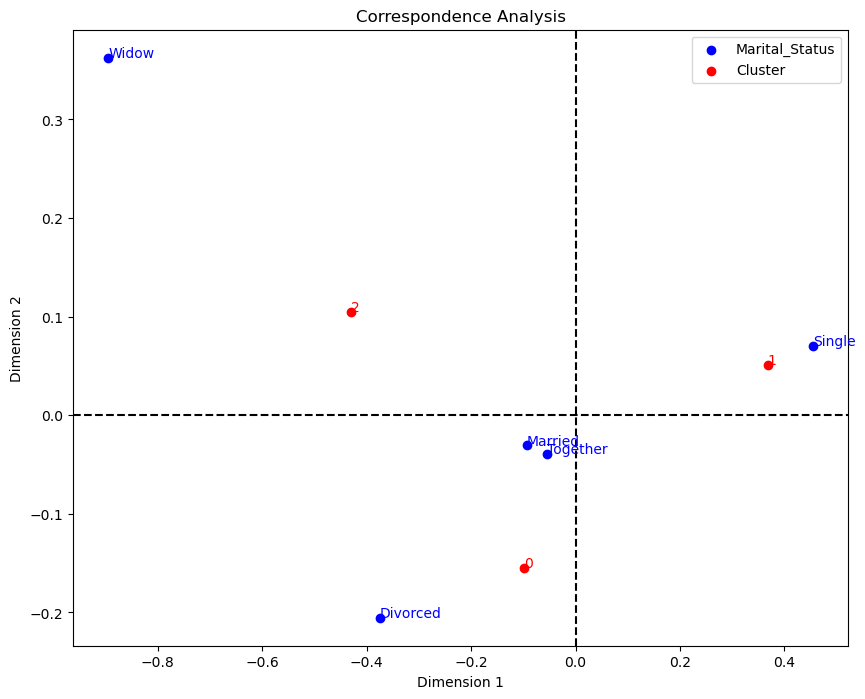

In [199]:
# Step 2: Create a contingency table
contingency_table_G = pd.crosstab(ds_ca_concat_segmented["Marital_Status"], ds_ca_concat_segmented['Cluster'])

# Step 3: Perform correspondence analysis
ca_g = prince.CA(n_components=2, random_state=42)
ca_g.fit(contingency_table_G)

print(contingency_table_G)

# Step 4: Get the row and column coordinates
row_coords_g = ca_g.row_coordinates(contingency_table_G)
column_coords_g = ca_g.column_coordinates(contingency_table_G)

# Step 5: Plot the correspondence analysis
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(row_coords_g.iloc[:,0], row_coords_g.iloc[:, 1], c='blue', label='Marital_Status')
ax.scatter(column_coords_g.iloc[:, 0], column_coords_g.iloc[:,1], c='red', label='Cluster')
ax.legend()

# Add labels to data points
label_shift = -0.0005  # Adjust this value to control the label positioning
for i, txt in enumerate(row_coords_g.index):
    ax.annotate(txt, (row_coords_g.iloc[i, 0], row_coords_g.iloc[i, 1] - label_shift), color='blue')
for i, txt in enumerate(column_coords_g.index):
    ax.annotate(txt, (column_coords_g.iloc[i, 0], column_coords_g.iloc[i, 1] - label_shift), color='red')

# Add a line through the coordinate (0, 0)
ax.axhline(0, color='black', linestyle='--')
ax.axvline(0, color='black', linestyle='--')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Correspondence Analysis')
plt.legend()
plt.show()


Cluster     0     1     2
Gender                   
F         954  1221   841
M        1754  2217  1490
Other      12    12     3


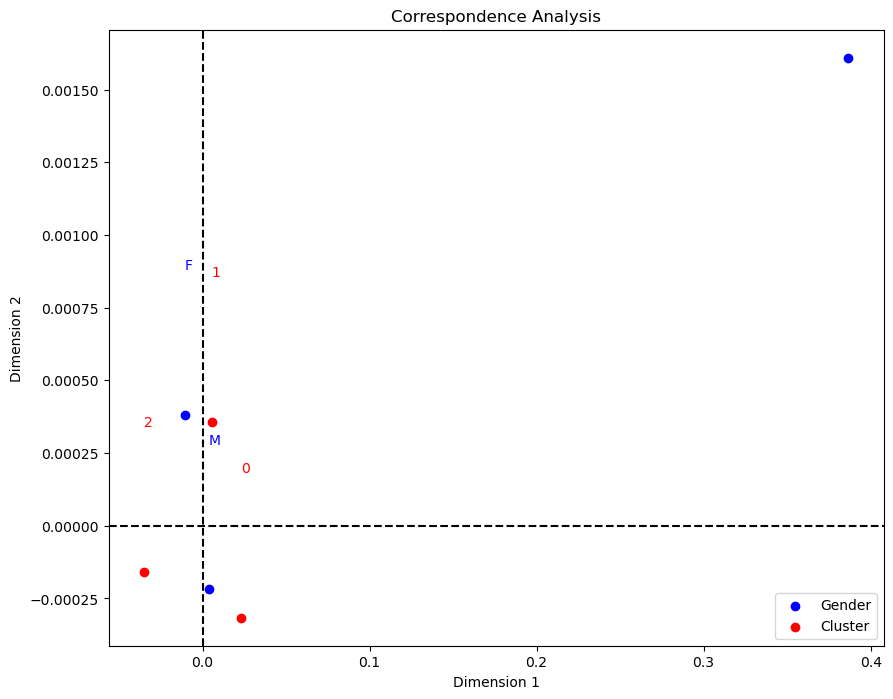

In [200]:
# Step 2: Create a contingency table
contingency_table_G = pd.crosstab(ds_ca_concat_segmented["Gender"], ds_ca_concat_segmented['Cluster'])

# Step 3: Perform correspondence analysis
ca_g = prince.CA(n_components=2, random_state=42)
ca_g.fit(contingency_table_G)

print(contingency_table_G)

# Step 4: Get the row and column coordinates
row_coords_g = ca_g.row_coordinates(contingency_table_G)
column_coords_g = ca_g.column_coordinates(contingency_table_G)

# Step 5: Plot the correspondence analysis
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(row_coords_g.iloc[:,0], row_coords_g.iloc[:, 1], c='blue', label='Gender')
ax.scatter(column_coords_g.iloc[:, 0], column_coords_g.iloc[:,1], c='red', label='Cluster')
ax.legend()

# Add labels to data points
label_shift = -0.0005  # Adjust this value to control the label positioning
for i, txt in enumerate(row_coords_g.index):
    ax.annotate(txt, (row_coords_g.iloc[i, 0], row_coords_g.iloc[i, 1] - label_shift), color='blue')
for i, txt in enumerate(column_coords_g.index):
    ax.annotate(txt, (column_coords_g.iloc[i, 0], column_coords_g.iloc[i, 1] - label_shift), color='red')

# Add a line through the coordinate (0, 0)
ax.axhline(0, color='black', linestyle='--')
ax.axvline(0, color='black', linestyle='--')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Correspondence Analysis')
plt.legend()
plt.show()


Cluster        0     1     2
Dependents                  
0            382   475  1710
1           2338  2975   624


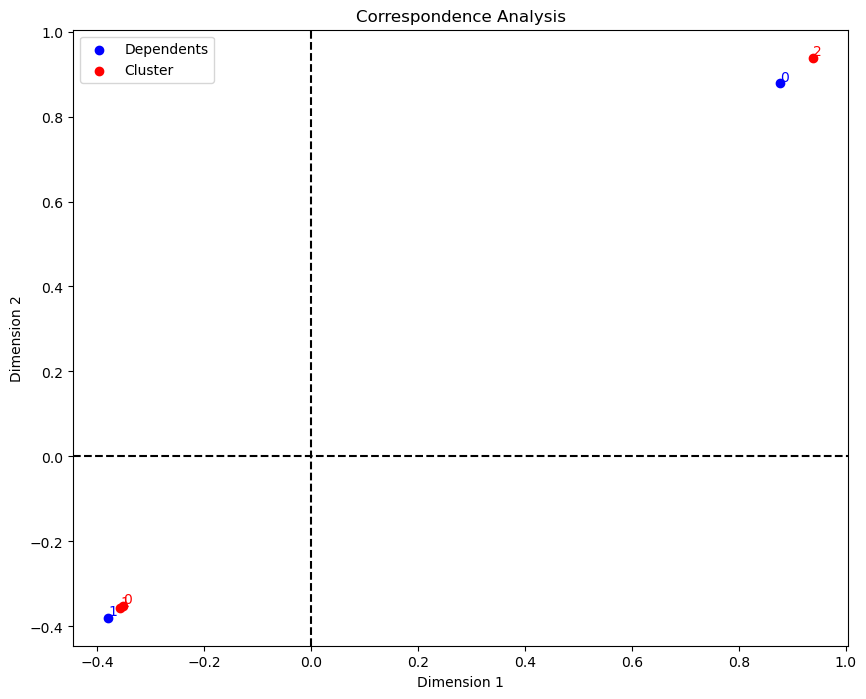

In [201]:
# Step 2: Create a contingency table
contingency_table_G = pd.crosstab(ds_ca_concat_segmented["Dependents"], ds_ca_concat_segmented['Cluster'])

# Step 3: Perform correspondence analysis
ca_g = prince.CA(n_components=2, random_state=42)
ca_g.fit(contingency_table_G)

print(contingency_table_G)

# Step 4: Get the row and column coordinates
row_coords_g = ca_g.row_coordinates(contingency_table_G)
column_coords_g = ca_g.column_coordinates(contingency_table_G)

# Step 5: Plot the correspondence analysis
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(row_coords_g.iloc[:,0], row_coords_g.iloc[:, 0], c='blue', label='Dependents')
ax.scatter(column_coords_g.iloc[:, 0], column_coords_g.iloc[:,0], c='red', label='Cluster')
ax.legend()

# Add labels to data points
label_shift = -0.005  # Adjust this value to control the label positioning
for i, txt in enumerate(row_coords_g.index):
    ax.annotate(txt, (row_coords_g.iloc[i, 0], row_coords_g.iloc[i, 0] - label_shift), color='blue')
for i, txt in enumerate(column_coords_g.index):
    ax.annotate(txt, (column_coords_g.iloc[i, 0], column_coords_g.iloc[i, 0] - label_shift), color='red')

# Add a line through the coordinate (0, 0)
ax.axhline(0, color='black', linestyle='--')
ax.axvline(0, color='black', linestyle='--')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Correspondence Analysis')
plt.legend()
plt.show()

Cluster    0     1     2
NPS                     
1          9    32     0
2        738  1145   142
3        765  1133   127
4        994  1130  1102
5        214    10   963


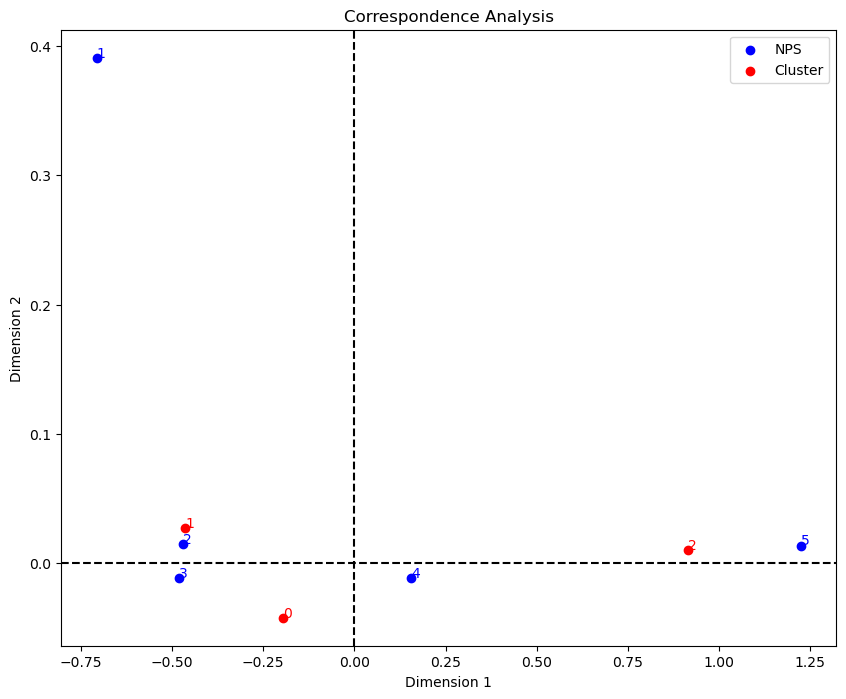

In [202]:
# Step 2: Create a contingency table
contingency_table_G = pd.crosstab(ds_ca_concat_segmented["NPS"], ds_ca_concat_segmented['Cluster'])

# Step 3: Perform correspondence analysis
ca_g = prince.CA(n_components=2, random_state=42)
ca_g.fit(contingency_table_G)

print(contingency_table_G)

# Step 4: Get the row and column coordinates
row_coords_g = ca_g.row_coordinates(contingency_table_G)
column_coords_g = ca_g.column_coordinates(contingency_table_G)

# Step 5: Plot the correspondence analysis
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(row_coords_g.iloc[:,0], row_coords_g.iloc[:, 1], c='blue', label='NPS')
ax.scatter(column_coords_g.iloc[:, 0], column_coords_g.iloc[:,1], c='red', label='Cluster')
ax.legend()

# Add labels to data points
label_shift = -0.0005  # Adjust this value to control the label positioning
for i, txt in enumerate(row_coords_g.index):
    ax.annotate(txt, (row_coords_g.iloc[i, 0], row_coords_g.iloc[i, 1] - label_shift), color='blue')
for i, txt in enumerate(column_coords_g.index):
    ax.annotate(txt, (column_coords_g.iloc[i, 0], column_coords_g.iloc[i, 1] - label_shift), color='red')

# Add a line through the coordinate (0, 0)
ax.axhline(0, color='black', linestyle='--')
ax.axvline(0, color='black', linestyle='--')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Correspondence Analysis')
plt.legend()
plt.show()


Cluster             0     1    2
Income_brackets                 
(0, 10000]          2    97    0
(10000, 20000]      0   604    0
(20000, 30000]     11  1196    0
(30000, 40000]    249  1217    0
(40000, 50000]   1092   323   16
(50000, 60000]   1063    13  413
(60000, 70000]    288     0  956
(70000, 80000]     15     0  763
(80000, 90000]      0     0  181
(90000, 100000]     0     0    5


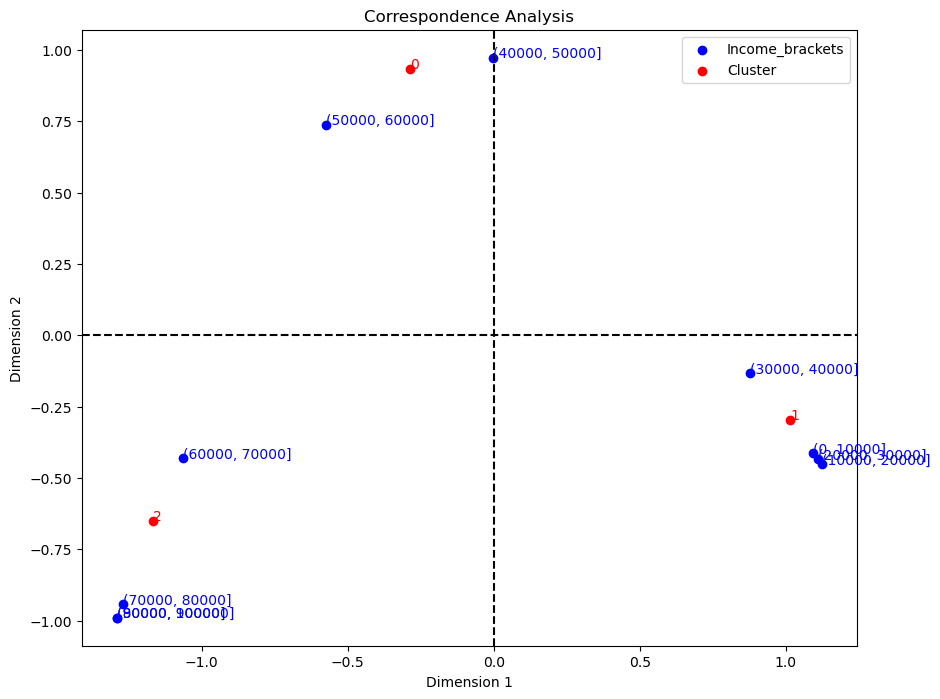

In [203]:
# Step 2: Create a contingency table
contingency_table_G = pd.crosstab(ds_ca_concat_segmented_income["Income_brackets"], ds_ca_concat_segmented_income['Cluster'])

# Step 3: Perform correspondence analysis
ca_g = prince.CA(n_components=2, random_state=42)
ca_g.fit(contingency_table_G)

print(contingency_table_G)

# Step 4: Get the row and column coordinates
row_coords_g = ca_g.row_coordinates(contingency_table_G)
column_coords_g = ca_g.column_coordinates(contingency_table_G)

# Step 5: Plot the correspondence analysis
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(row_coords_g.iloc[:,0], row_coords_g.iloc[:, 1], c='blue', label='Income_brackets')
ax.scatter(column_coords_g.iloc[:, 0], column_coords_g.iloc[:,1], c='red', label='Cluster')
ax.legend()

# Add labels to data points
label_shift = -0.0005  # Adjust this value to control the label positioning
for i, txt in enumerate(row_coords_g.index):
    ax.annotate(txt, (row_coords_g.iloc[i, 0], row_coords_g.iloc[i, 1] - label_shift), color='blue')
for i, txt in enumerate(column_coords_g.index):
    ax.annotate(txt, (column_coords_g.iloc[i, 0], column_coords_g.iloc[i, 1] - label_shift), color='red')

# Add a line through the coordinate (0, 0)
ax.axhline(0, color='black', linestyle='--')
ax.axvline(0, color='black', linestyle='--')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Correspondence Analysis')
plt.legend()
plt.show()


Cluster          0     1     2
Age_brackets                  
(18, 28]         0  1373     0
(28, 38]        47  1404     0
(38, 48]       772   656     0
(48, 58]      1335    17   136
(58, 68]       541     0   866
(68, 78]        25     0  1267
(78, 88]         0     0    65


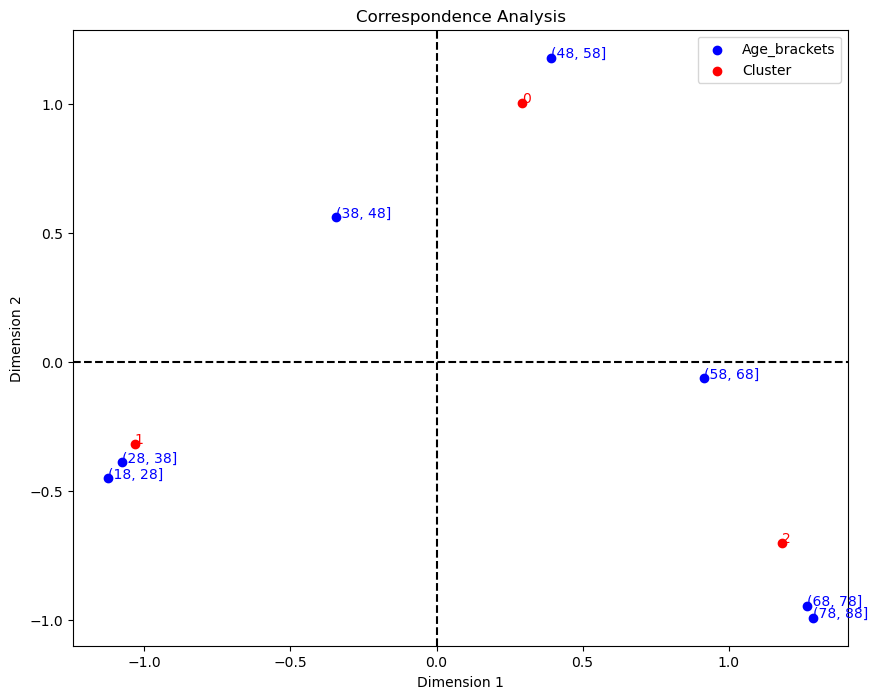

In [204]:
# Step 2: Create a contingency table
contingency_table_G = pd.crosstab(ds_ca_concat_segmented['Age_brackets'], ds_ca_concat_segmented['Cluster'])

# Step 3: Perform correspondence analysis
ca_g = prince.CA(n_components=2, random_state=42)
ca_g.fit(contingency_table_G)

print(contingency_table_G)

# Step 4: Get the row and column coordinates
row_coords_g = ca_g.row_coordinates(contingency_table_G)
column_coords_g = ca_g.column_coordinates(contingency_table_G)

# Step 5: Plot the correspondence analysis
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(row_coords_g.iloc[:,0], row_coords_g.iloc[:, 1], c='blue', label='Age_brackets')
ax.scatter(column_coords_g.iloc[:, 0], column_coords_g.iloc[:,1], c='red', label='Cluster')
ax.legend()

# Add labels to data points
label_shift = -0.0005  # Adjust this value to control the label positioning
for i, txt in enumerate(row_coords_g.index):
    ax.annotate(txt, (row_coords_g.iloc[i, 0], row_coords_g.iloc[i, 1] - label_shift), color='blue')
for i, txt in enumerate(column_coords_g.index):
    ax.annotate(txt, (column_coords_g.iloc[i, 0], column_coords_g.iloc[i, 1] - label_shift), color='red')

# Add a line through the coordinate (0, 0)
ax.axhline(0, color='black', linestyle='--')
ax.axvline(0, color='black', linestyle='--')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Correspondence Analysis')
plt.legend()
plt.show()


# Correspondence Analysis Interpretation

now we can add more information to each cluster

# Second Order Cluster Analysis

In [205]:
campaign_cluster_second_order.head()

Education Marital_Status  Age Gender  Dependents   Income  Frequency  \
CustID                                                                        
1            MSc       Together   67      F           0  67696.2       33.0   
2            BSc       Together   40      M           1  43446.0       15.0   
3            MSc         Single   75      M           0  64193.2       37.0   
4            BSc         Single   40      M           1  55898.2       28.0   
5            BSc        Married   26      F           1  14414.4       13.0   

        Recency  Perishables  Beverages   Frozen   Canned  Others  Internet  \
CustID                                                                        
1          74.0      4865.80    2649.32  2152.80  1715.64  244.08        96   
2          17.0       323.76     215.24   170.24   107.68   72.84        52   
3          93.0      5467.00    3218.00  1736.40  1460.20  614.40        92   
4          31.0      3598.00     958.20   259.80   147.80  121.80        59   
5          84.0       263.52     161.52   228.56    57.32  407.52        45   

        NPS Target  Total_Amount_Spent  total_amount_spent_divided_by_income  
CustID                                                                        
1         5      ?            11627.64                              0.171762  
2         3      ?              889.76                              0.020480  
3         5      ?            12496.00                              0.194662  
4         4      ?             5085.60                              0.090980  
5         2      ?             1118.44                              0.077592

In [206]:
campaign_cluster_second_order.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             8504 non-null   object 
 1   Marital_Status                        8504 non-null   object 
 2   Age                                   8504 non-null   int64  
 3   Gender                                8504 non-null   object 
 4   Dependents                            8504 non-null   int64  
 5   Income                                8504 non-null   float64
 6   Frequency                             8504 non-null   float64
 7   Recency                               8504 non-null   float64
 8   Perishables                           8504 non-null   float64
 9   Beverages                             8504 non-null   float64
 10  Frozen                                8504 non-null   float64
 11  Canned           

In [207]:
campaign_cluster_second_order.drop('Education', axis=1, inplace= True)
campaign_cluster_second_order.drop('Income', axis=1, inplace= True)
campaign_cluster_second_order.drop('Marital_Status', axis=1, inplace= True)
campaign_cluster_second_order.drop('Age', axis=1, inplace= True)
campaign_cluster_second_order.drop('Gender', axis=1, inplace= True)
campaign_cluster_second_order.drop('Dependents', axis=1, inplace= True)
campaign_cluster_second_order.drop('Frequency', axis=1, inplace= True)
campaign_cluster_second_order.drop('Recency', axis=1, inplace= True)
campaign_cluster_second_order.drop('Internet', axis=1, inplace= True)
campaign_cluster_second_order.drop('NPS', axis=1, inplace= True)
campaign_cluster_second_order.drop('Target', axis=1, inplace= True)

In [208]:
#Calculate the ratios for each product
campaign_cluster_second_order['Perishables_divided_by_total'] = campaign_cluster_second_order['Perishables'] / campaign_cluster_second_order['Total_Amount_Spent']
campaign_cluster_second_order['Beverages_divided_by_total'] = campaign_cluster_second_order['Beverages'] / campaign_cluster_second_order['Total_Amount_Spent']
campaign_cluster_second_order['Frozen_divided_by_total'] = campaign_cluster_second_order['Frozen'] / campaign_cluster_second_order['Total_Amount_Spent']
campaign_cluster_second_order['Canned_divided_by_total'] = campaign_cluster_second_order['Canned'] / campaign_cluster_second_order['Total_Amount_Spent']
campaign_cluster_second_order['Others_divided_by_total'] = campaign_cluster_second_order['Others'] / campaign_cluster_second_order['Total_Amount_Spent']

In [209]:
# Now we can drop these variables, since they are customer based and we want to do a product based segmentation.
campaign_cluster_second_order.drop('Total_Amount_Spent', axis=1, inplace= True)
campaign_cluster_second_order.drop('total_amount_spent_divided_by_income', axis=1, inplace= True)

In [210]:
campaign_cluster_second_order.head()

Perishables  Beverages   Frozen   Canned  Others  \
CustID                                                     
1           4865.80    2649.32  2152.80  1715.64  244.08   
2            323.76     215.24   170.24   107.68   72.84   
3           5467.00    3218.00  1736.40  1460.20  614.40   
4           3598.00     958.20   259.80   147.80  121.80   
5            263.52     161.52   228.56    57.32  407.52   

        Perishables_divided_by_total  Beverages_divided_by_total  \
CustID                                                             
1                           0.418468                    0.227847   
2                           0.363873                    0.241908   
3                           0.437500                    0.257522   
4                           0.707488                    0.188414   
5                           0.235614                    0.144415   

        Frozen_divided_by_total  Canned_divided_by_total  \
CustID                                                     
1                      0.185145                 0.147548   
2                      0.191332                 0.121021   
3                      0.138956                 0.116853   
4                      0.051085                 0.029062   
5                      0.204356                 0.051250   

        Others_divided_by_total  
CustID                           
1                      0.020991  
2                      0.081865  
3                      0.049168  
4                      0.023950  
5                      0.364365

In [211]:
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Scale the values while preserving the index
scaled_values = scaler.fit_transform(campaign_cluster_second_order)

# Create a new DataFrame with the scaled values and the original index
campaign_cluster_second_order_scaled = pd.DataFrame(scaled_values, index=campaign_cluster_second_order.index, columns=campaign_cluster_second_order.columns)

In [212]:
campaign_cluster_second_order_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Perishables                   8504 non-null   float64
 1   Beverages                     8504 non-null   float64
 2   Frozen                        8504 non-null   float64
 3   Canned                        8504 non-null   float64
 4   Others                        8504 non-null   float64
 5   Perishables_divided_by_total  8504 non-null   float64
 6   Beverages_divided_by_total    8504 non-null   float64
 7   Frozen_divided_by_total       8504 non-null   float64
 8   Canned_divided_by_total       8504 non-null   float64
 9   Others_divided_by_total       8504 non-null   float64
dtypes: float64(10)
memory usage: 988.9 KB


In [213]:
# Filter the DataFrame to select rows with missing values in the specified column
missing_rows = campaign_cluster_second_order[campaign_cluster_second_order['Perishables_divided_by_total'].isnull()]

# Print the rows with missing values
missing_rows.head()

Empty DataFrame
Columns: [Perishables, Beverages, Frozen, Canned, Others, Perishables_divided_by_total, Beverages_divided_by_total, Frozen_divided_by_total, Canned_divided_by_total, Others_divided_by_total]
Index: []

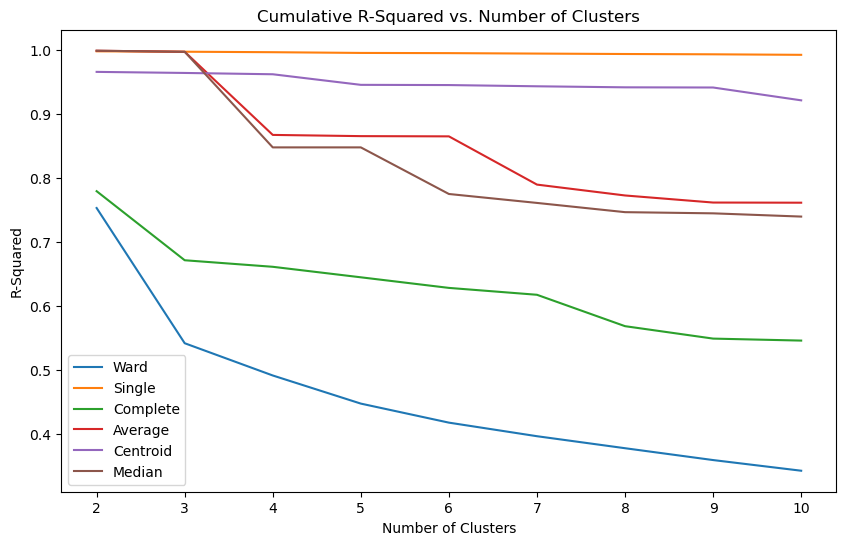

In [214]:
# Define linkage methods
ward_linkage = linkage(campaign_cluster_second_order_scaled, method='ward')
single_linkage = linkage(campaign_cluster_second_order_scaled, method='single')
complete_linkage = linkage(campaign_cluster_second_order_scaled, method='complete')
average_linkage = linkage(campaign_cluster_second_order_scaled, method='average')
centroid_linkage = linkage(campaign_cluster_second_order_scaled, method='centroid')
median_linkage = linkage(campaign_cluster_second_order_scaled, method='median')

# Define dictionary of linkage methods
linkage_methods = {
    'Ward': ward_linkage,
    'Single': single_linkage,
    'Complete': complete_linkage,
    'Average': average_linkage,
    'Centroid': centroid_linkage,
    'Median': median_linkage
}

# Calculate R^2 for each linkage method
r2_scores = {}
for name, linkage_matrix in linkage_methods.items():
    r2_scores[name] = []
    for k in range(2, 11):
        clusters = fcluster(linkage_matrix, k, criterion='maxclust')
        cluster_centers = np.array([campaign_cluster_second_order_scaled[clusters == i].mean(axis=0) for i in range(1, k + 1)])
        ss_distances = np.sum((campaign_cluster_second_order_scaled - cluster_centers[clusters - 1]) ** 2, axis=1)
        ss_total = np.sum((campaign_cluster_second_order_scaled - np.mean(campaign_cluster_second_order_scaled, axis=0)) ** 2, axis=1)
        r2_scores[name].append(np.sum(ss_distances) / np.sum(ss_total))

# Plot R^2 for each linkage method
plt.figure(figsize=(10, 6))
for name, scores in r2_scores.items():
    plt.plot(range(2, 11), scores, label=name)
plt.xlabel('Number of Clusters')
plt.ylabel('R-Squared')
plt.title('Cumulative R-Squared vs. Number of Clusters')
plt.legend()
plt.show()

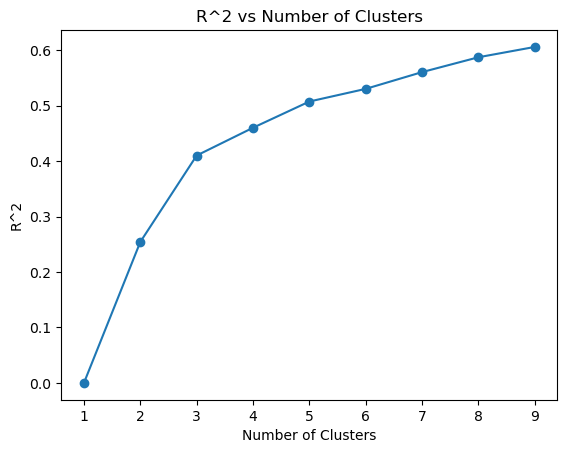

In [215]:
#Comparison R^2 and number of clusters
# Define the range of cluster numbers to test
cluster_range = range(1, 10)

# Create an empty list to store the R^2 values
r2_values = []

# Fit the K-means model for each number of clusters and calculate the R^2
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(campaign_cluster_second_order_scaled)
    cluster_labels = kmeans.predict(campaign_cluster_second_order_scaled)
    r2 = r2_score(campaign_cluster_second_order_scaled, kmeans.cluster_centers_[cluster_labels])
    r2_values.append(r2)

# Plot the R^2 values against the number of clusters
plt.plot(cluster_range, r2_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('R^2')
plt.title('R^2 vs Number of Clusters')
plt.show()

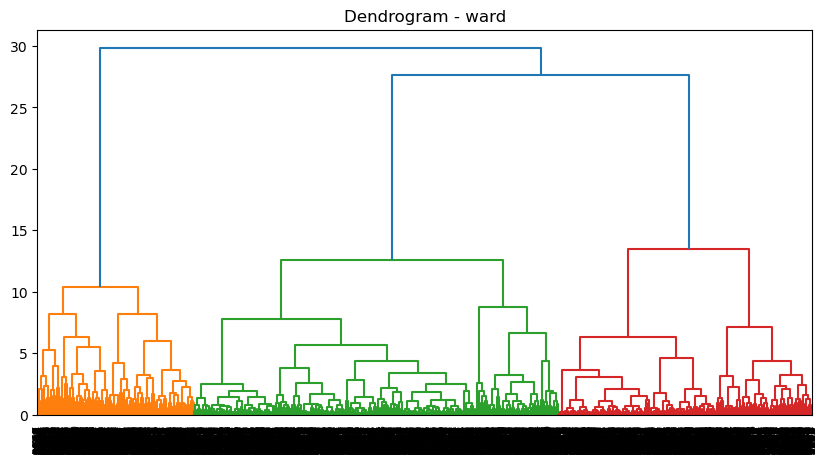

In [216]:
# Hierarchical Approach - ward
Z = linkage(campaign_cluster_second_order_scaled, method='ward', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
plt.title("Dendrogram - ward")
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
plt.show()

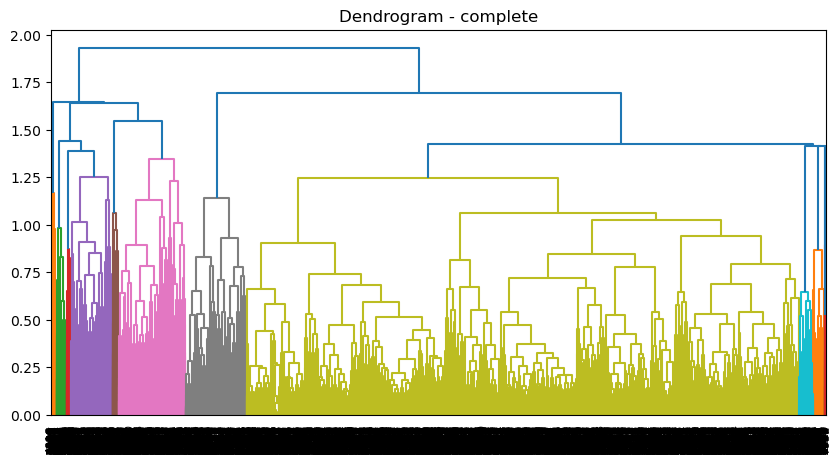

In [217]:
# Hierarchical Approach - complete
Z = linkage(campaign_cluster_second_order_scaled, method='complete', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
plt.title("Dendrogram - complete")
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
plt.show()

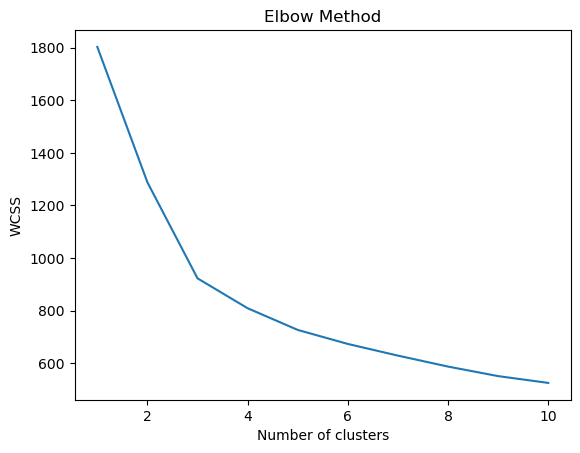

In [218]:
# Initialize empty list to store the WCSS values for each k
wcss = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(campaign_cluster_second_order_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(k_range, wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [219]:
#Calculating the optimal number of clusters with the silhouette method
X = campaign_cluster_second_order_scaled

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

best_k = silhouette_scores.index(max(silhouette_scores)) + 2  # add 2 because we started with k=2
print("Best number of clusters according to silhouette method:", best_k)

Best number of clusters according to silhouette method: 2


We proceed with 3 clusters. The Ward Dendogram is very clear about it.
We also tried with two clusters before and the information we could extract from the third cluster made a lot of sense and helped us to understand the data more.

In [220]:
campaign_cluster_second_order_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Perishables                   8504 non-null   float64
 1   Beverages                     8504 non-null   float64
 2   Frozen                        8504 non-null   float64
 3   Canned                        8504 non-null   float64
 4   Others                        8504 non-null   float64
 5   Perishables_divided_by_total  8504 non-null   float64
 6   Beverages_divided_by_total    8504 non-null   float64
 7   Frozen_divided_by_total       8504 non-null   float64
 8   Canned_divided_by_total       8504 non-null   float64
 9   Others_divided_by_total       8504 non-null   float64
dtypes: float64(10)
memory usage: 988.9 KB


In [221]:
# Set a random seed for reproducibility
random_seed = 42

# Set the number of clusters
n_clusters = 3

# Set the number of initial random seeds
n_init = 3

# Create a KMeans object
kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed, n_init=n_init)

# Perform clustering on campaign_cluster_scaled DataFrame
labels = kmeans.fit_predict(campaign_cluster_second_order_scaled)

# Create df_cluster_loadings DataFrame
df_cluster_second_order_loadings_all = pd.DataFrame(kmeans.cluster_centers_, columns=campaign_cluster_second_order_scaled.columns)

# Create df_with_clusters DataFrame
df_second_order_with_clusters_all = campaign_cluster_second_order_scaled.copy()
df_second_order_with_clusters_all['Cluster'] = labels

# Print df_cluster_loadings DataFrame
df_cluster_second_order_loadings_all.head().T


0         1         2
Perishables                   0.302432  0.037260  0.247845
Beverages                     0.375804  0.041642  0.108302
Frozen                        0.388894  0.076869  0.084750
Canned                        0.280953  0.041929  0.048642
Others                        0.316991  0.057453  0.062593
Perishables_divided_by_total  0.362534  0.306966  0.676137
Beverages_divided_by_total    0.217164  0.154108  0.134688
Frozen_divided_by_total       0.143272  0.234400  0.074321
Canned_divided_by_total       0.139991  0.126664  0.053160
Others_divided_by_total       0.137038  0.177861  0.061694

In [222]:
df_second_order_with_clusters_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Perishables                   8504 non-null   float64
 1   Beverages                     8504 non-null   float64
 2   Frozen                        8504 non-null   float64
 3   Canned                        8504 non-null   float64
 4   Others                        8504 non-null   float64
 5   Perishables_divided_by_total  8504 non-null   float64
 6   Beverages_divided_by_total    8504 non-null   float64
 7   Frozen_divided_by_total       8504 non-null   float64
 8   Canned_divided_by_total       8504 non-null   float64
 9   Others_divided_by_total       8504 non-null   float64
 10  Cluster                       8504 non-null   int32  
dtypes: float64(10), int32(1)
memory usage: 1022.1 KB


In [223]:
#Dropping all Columns, except for Cluster
df_second_order_with_clusters_all = df_second_order_with_clusters_all[['Cluster']]

In [224]:
#Now we need to rename the Second Grade Cluster to Cluster 2
df_second_order_with_clusters_all.rename(columns={'Cluster': 'Cluster 2'}, inplace=True)

In [225]:
df_second_order_with_clusters_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Cluster 2  8504 non-null   int32
dtypes: int32(1)
memory usage: 357.7 KB


In [226]:
df_with_clusters_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Cluster  8504 non-null   int32
dtypes: int32(1)
memory usage: 357.7 KB


In [227]:
df_with_clusters_all.head()

Cluster
CustID         
1             2
2             1
3             2
4             0
5             1

In [228]:
# Join the datasets using the index
ds_ca_concat_final = df_second_order_with_clusters_all.join(df_with_clusters_all, how='inner')

In [229]:
ds_ca_concat_final.head()

Cluster 2  Cluster
CustID                    
1               0        2
2               1        1
3               0        2
4               2        0
5               1        1

Now for the Bronze, Silver Cluster and gold Cluster, we are going to look for the sub clusters.

In [230]:
ds_ca_concat_final_gold = ds_ca_concat_final.copy()
ds_ca_concat_final_silver = ds_ca_concat_final.copy()
ds_ca_concat_final_bronze = ds_ca_concat_final.copy()

In [231]:
#Split the the Data set into 3 datasets based onthe silver,gold,
ds_ca_concat_final_gold = ds_ca_concat_final[ds_ca_concat_final['Cluster'] == 2]
ds_ca_concat_final_silver = ds_ca_concat_final[ds_ca_concat_final['Cluster'] == 0]
ds_ca_concat_final_bronze = ds_ca_concat_final[ds_ca_concat_final['Cluster'] == 1]

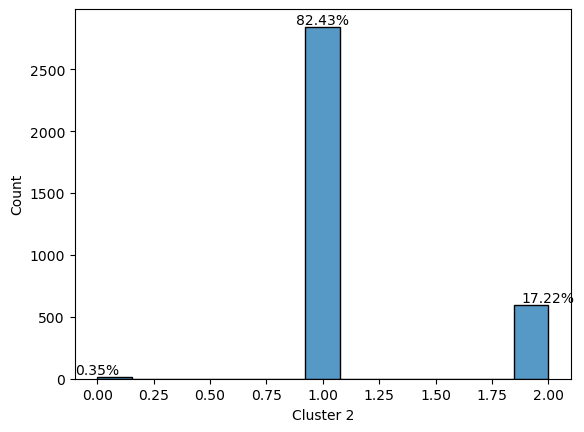

In [232]:
#Histogram
sns.histplot(data=ds_ca_concat_final_bronze, x='Cluster 2')

# Calculate percentage distribution
total_count = len(ds_ca_concat_final_bronze['Cluster 2'])
counts = ds_ca_concat_final_bronze['Cluster 2'].value_counts()
percentages = counts / total_count * 100

# Add text with percentage distribution on top of bars
for category, percentage in percentages.iteritems():
    plt.text(category, counts[category], f"{percentage:.2f}%", ha='center', va='bottom')

# Display the plot
plt.show()


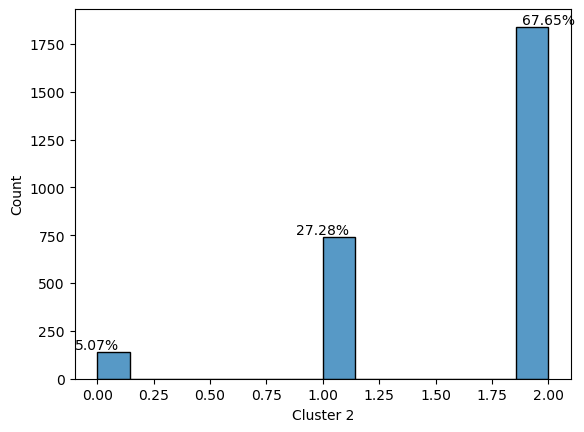

In [233]:
# Plot the histogram
sns.histplot(data=ds_ca_concat_final_silver, x='Cluster 2')

# Calculate percentage distribution
total_count = len(ds_ca_concat_final_silver['Cluster 2'])
counts = ds_ca_concat_final_silver['Cluster 2'].value_counts()
percentages = counts / total_count * 100

# Add text with percentage distribution on top of bars
for category, percentage in percentages.iteritems():
    plt.text(category, counts[category], f"{percentage:.2f}%", ha='center', va='bottom')

# Display the plot
plt.show()


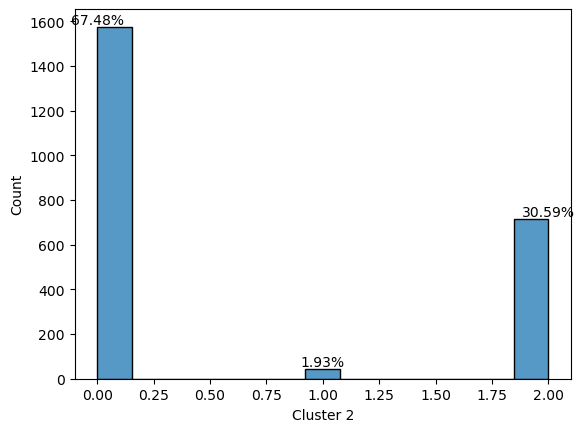

In [234]:
# Plot the histogram
sns.histplot(data=ds_ca_concat_final_gold, x='Cluster 2')

# Calculate percentage distribution
total_count = len(ds_ca_concat_final_gold['Cluster 2'])
counts = ds_ca_concat_final_gold['Cluster 2'].value_counts()
percentages = counts / total_count * 100

# Add text with percentage distribution on top of bars
for category, percentage in percentages.iteritems():
    plt.text(category, counts[category], f"{percentage:.2f}%", ha='center', va='bottom')

# Display the plot
plt.show()


# Predictive Analysis
Now we are going to start with the predictive Part of the Project. For this we need to 

In [235]:
campaign_predictive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             8504 non-null   object 
 1   Marital_Status                        8504 non-null   object 
 2   Age                                   8504 non-null   int64  
 3   Gender                                8504 non-null   object 
 4   Dependents                            8504 non-null   int64  
 5   Income                                8504 non-null   float64
 6   Frequency                             8504 non-null   float64
 7   Recency                               8504 non-null   float64
 8   Perishables                           8504 non-null   float64
 9   Beverages                             8504 non-null   float64
 10  Frozen                                8504 non-null   float64
 11  Canned           

In [236]:
campaign_predictive.describe().T

count          mean           std  \
Age                                   8504.0     48.465428     17.144054   
Dependents                            8504.0      0.698142      0.459091   
Income                                8504.0  46107.304892  18475.302759   
Frequency                             8504.0     20.458020     10.982677   
Recency                               8504.0     61.017521     58.070211   
Perishables                           8504.0   2091.709170   2145.297730   
Beverages                             8504.0    792.161675    958.696943   
Frozen                                8504.0    514.290865    611.124563   
Canned                                8504.0    460.587686    672.410078   
Others                                8504.0    482.129492    637.880324   
Internet                              8504.0     57.019638     18.553278   
NPS                                   8504.0      3.410748      1.013159   
Total_Amount_Spent                    8504.0   4340.878888   3982.858828   
total_amount_spent_divided_by_income  8504.0      0.082062      0.058815   

                                              min           25%          50%  \
Age                                     19.000000     34.000000     48.50000   
Dependents                               0.000000      0.000000      1.00000   
Income                                1394.400000  31338.600000  46158.10000   
Frequency                                1.000000     12.000000     18.00000   
Recency                                  1.000000     27.000000     53.00000   
Perishables                              0.000000    347.305000   1329.61000   
Beverages                                0.000000    161.130000    373.88000   
Frozen                                   0.000000    151.740000    260.94000   
Canned                                   0.000000     66.440000    178.90000   
Others                                   0.000000    110.400000    226.80000   
Internet                                10.000000     42.000000     54.00000   
NPS                                      1.000000      3.000000      4.00000   
Total_Amount_Spent                       8.800000   1140.380000   2773.88000   
total_amount_spent_divided_by_income     0.000176      0.035353      0.07189   

                                               75%           max  
Age                                      63.000000     79.000000  
Dependents                                1.000000      1.000000  
Income                                60594.100000  90735.200000  
Frequency                                28.000000     61.000000  
Recency                                  79.000000    365.000000  
Perishables                            3282.165000  12383.120000  
Beverages                              1058.500000   5911.000000  
Frozen                                  616.370000   3596.320000  
Canned                                  549.060000   4961.000000  
Others                                  584.640000   4307.040000  
Internet                                 71.000000    101.000000  
NPS                                       4.000000      5.000000  
Total_Amount_Spent                     7067.345000  19293.340000  
total_amount_spent_divided_by_income      0.122283      0.963172

In [237]:
campaign_predictive['Target'].unique()

array(['?', 1, 0], dtype=object)

# Splitting The Dataset based on the Target Variable

In [238]:
#Reset Button
campaign_predictive = campaign.copy()

In [239]:
campaign_predictive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8504 entries, 1 to 9000
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             8504 non-null   object 
 1   Marital_Status                        8504 non-null   object 
 2   Age                                   8504 non-null   int64  
 3   Gender                                8504 non-null   object 
 4   Dependents                            8504 non-null   int64  
 5   Income                                8504 non-null   float64
 6   Frequency                             8504 non-null   float64
 7   Recency                               8504 non-null   float64
 8   Perishables                           8504 non-null   float64
 9   Beverages                             8504 non-null   float64
 10  Frozen                                8504 non-null   float64
 11  Canned           

In [240]:
ds_with_target = campaign_predictive[campaign_predictive['Target'] != '?']
ds_without_target = campaign_predictive[campaign_predictive['Target'] == '?']

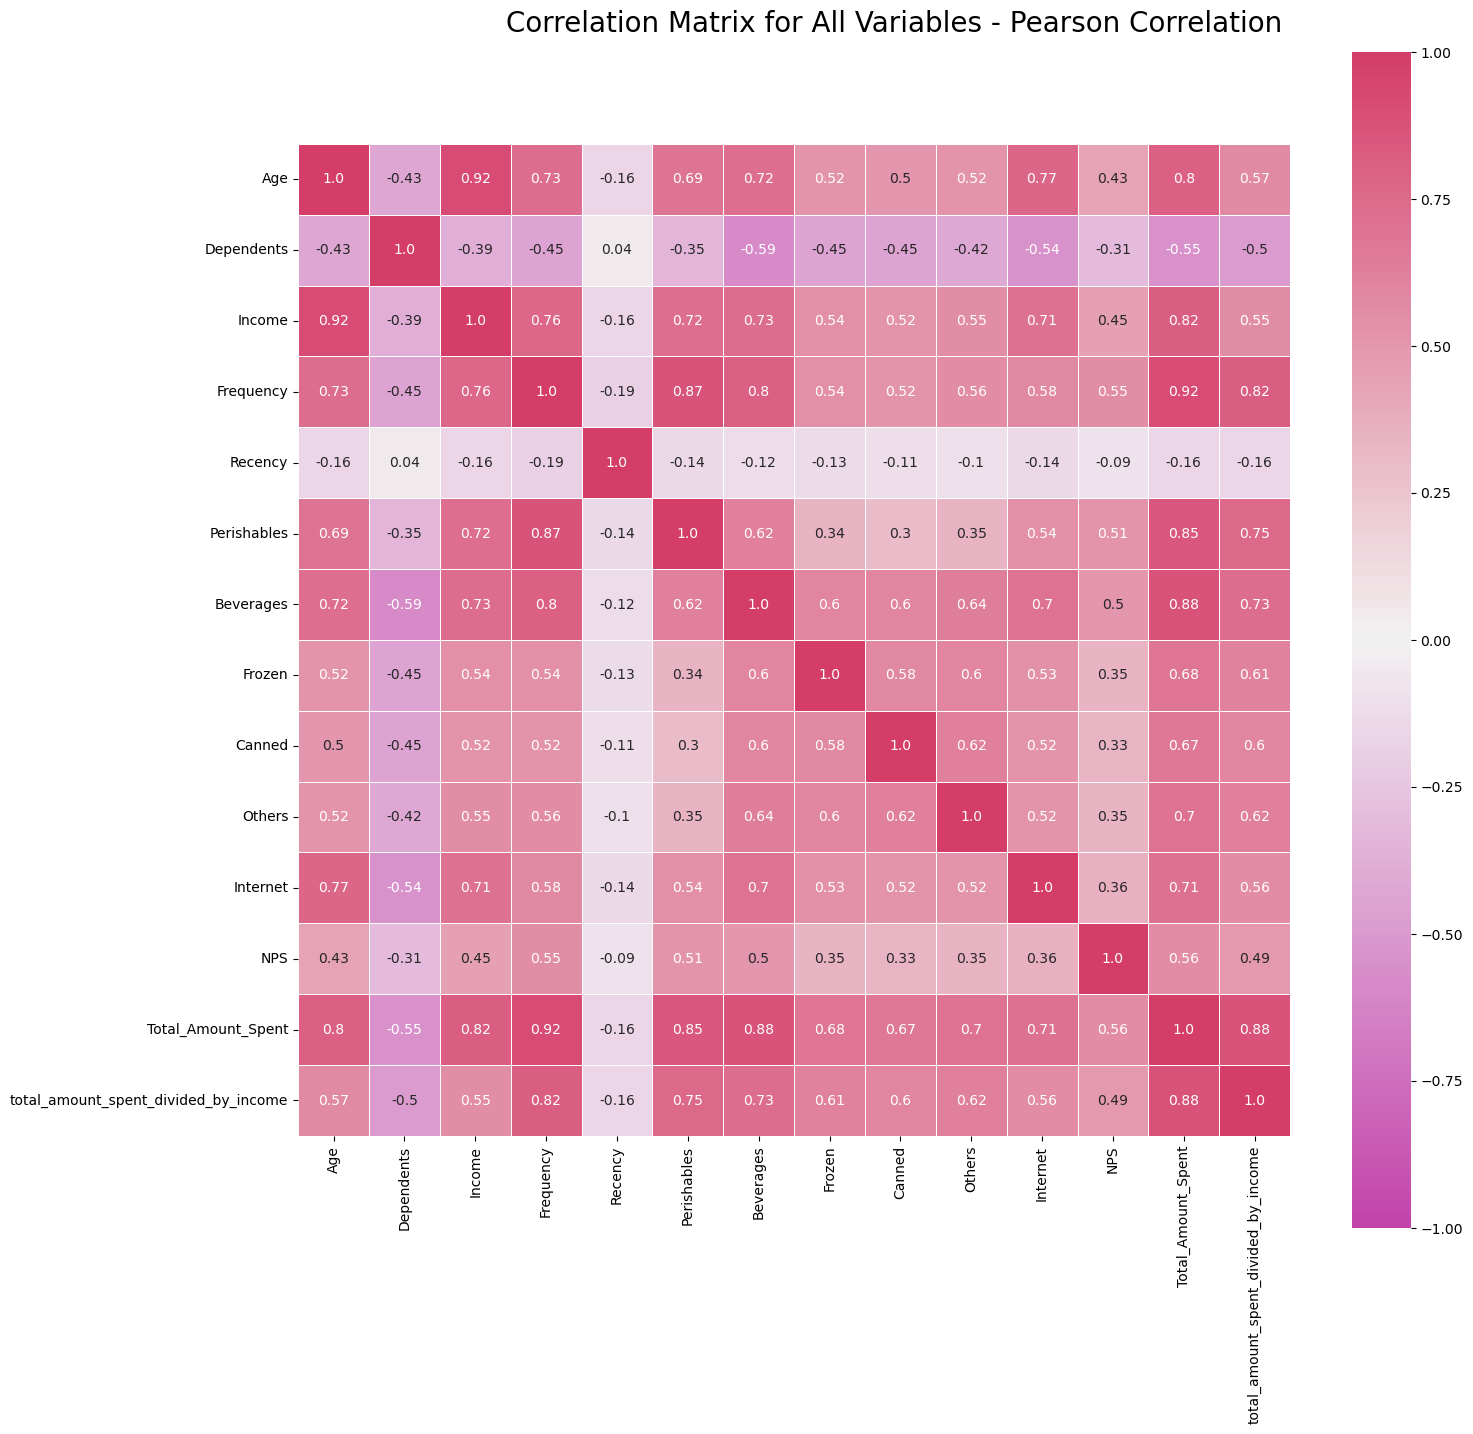

In [241]:
#ploting Pearson's Correlation Matrix for all variables
fig = plt.figure(figsize=(16, 14))

corr = np.round(ds_with_target.corr(method="pearson"), decimals=2)

mask_annot = np.absolute(corr.values) >= 0.01
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(320, 360, as_cmap=True), 
fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=0.5)
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix for All Variables - Pearson Correlation ", fontsize=20)

plt.show()

In [242]:
#Target is an object, so we need to transform it into an int data type.

In [243]:
ds_with_target.isna().sum()

Education                               0
Marital_Status                          0
Age                                     0
Gender                                  0
Dependents                              0
Income                                  0
Frequency                               0
Recency                                 0
Perishables                             0
Beverages                               0
Frozen                                  0
Canned                                  0
Others                                  0
Internet                                0
NPS                                     0
Target                                  0
Total_Amount_Spent                      0
total_amount_spent_divided_by_income    0
dtype: int64

In [244]:
ds_with_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1855 entries, 17 to 9000
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             1855 non-null   object 
 1   Marital_Status                        1855 non-null   object 
 2   Age                                   1855 non-null   int64  
 3   Gender                                1855 non-null   object 
 4   Dependents                            1855 non-null   int64  
 5   Income                                1855 non-null   float64
 6   Frequency                             1855 non-null   float64
 7   Recency                               1855 non-null   float64
 8   Perishables                           1855 non-null   float64
 9   Beverages                             1855 non-null   float64
 10  Frozen                                1855 non-null   float64
 11  Canned          

In [245]:
ds_without_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6649 entries, 1 to 8999
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             6649 non-null   object 
 1   Marital_Status                        6649 non-null   object 
 2   Age                                   6649 non-null   int64  
 3   Gender                                6649 non-null   object 
 4   Dependents                            6649 non-null   int64  
 5   Income                                6649 non-null   float64
 6   Frequency                             6649 non-null   float64
 7   Recency                               6649 non-null   float64
 8   Perishables                           6649 non-null   float64
 9   Beverages                             6649 non-null   float64
 10  Frozen                                6649 non-null   float64
 11  Canned           

In [246]:
ds_with_target2 = ds_with_target.copy()

## Variable Transformation for Predictive Methods

In [247]:
mapping = {
     'PhD' : 21,
     'MSc': 17,
     'BSc': 15,
     'High School': 12,
     'Primary': 9
}

ds_with_target2['Education'] = ds_with_target2['Education'].replace(mapping)

In [248]:
# Create dummy variables for 'Marital_status'
marital_dummies = pd.get_dummies(ds_with_target2['Marital_Status'], prefix='Marital')

# Concatenate the dummy variables with the original DataFrame
ds_with_marital_dummies = pd.concat([ds_with_target2, marital_dummies], axis=1)

In [249]:
# Create dummy variables for 'Marital_status'
gender_dummies = pd.get_dummies(ds_with_marital_dummies['Gender'], prefix='Gender')

# Concatenate the dummy variables with the original DataFrame
ds_with_dummies = pd.concat([ds_with_marital_dummies, gender_dummies], axis=1)

In [250]:
ds_with_dummies.drop('Marital_Status', axis=1, inplace= True)
ds_with_dummies.drop('Gender', axis=1, inplace= True)

In [251]:
ds_with_dummies['Target'] = ds_with_dummies['Target'].astype(int)

In [252]:
ds_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1855 entries, 17 to 9000
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             1855 non-null   int64  
 1   Age                                   1855 non-null   int64  
 2   Dependents                            1855 non-null   int64  
 3   Income                                1855 non-null   float64
 4   Frequency                             1855 non-null   float64
 5   Recency                               1855 non-null   float64
 6   Perishables                           1855 non-null   float64
 7   Beverages                             1855 non-null   float64
 8   Frozen                                1855 non-null   float64
 9   Canned                                1855 non-null   float64
 10  Others                                1855 non-null   float64
 11  Internet        

In [253]:
ds_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1855 entries, 17 to 9000
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             1855 non-null   int64  
 1   Age                                   1855 non-null   int64  
 2   Dependents                            1855 non-null   int64  
 3   Income                                1855 non-null   float64
 4   Frequency                             1855 non-null   float64
 5   Recency                               1855 non-null   float64
 6   Perishables                           1855 non-null   float64
 7   Beverages                             1855 non-null   float64
 8   Frozen                                1855 non-null   float64
 9   Canned                                1855 non-null   float64
 10  Others                                1855 non-null   float64
 11  Internet        

In [254]:
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Scale the values while preserving the index
scaled_values = scaler.fit_transform(ds_with_dummies)

# Create a new DataFrame with the scaled values and the original index
ds_with_dummies_scaled = pd.DataFrame(scaled_values, index=ds_with_dummies.index, columns=ds_with_dummies.columns)


# "RFM" approach

We wanted to try a RFM simplification, however further down the analysis, we realized we will have to drop frequency. What happens in the next step is creating a new feature, that is a weighted sum of all the monetary variables. The weight is calculated by their correlation to the target variable. And also we don't have more frequency, nor recency variables for further simplification.

So we can't really talk about a RFM analysis. Hence, from now on we will just call it approach 1, with the monetary variable and approach 2 without the monetary variable

In [255]:
ds_without_RFM = ds_with_dummies_scaled.copy()

In [256]:
calculate_spearman_corr_weights(ds_with_dummies_scaled, ['Total_Amount_Spent','Others','Canned','Frozen','Beverages','Perishables'], 'Target')








Total_Amount_Spent: 0.214
Others: 0.13
Canned: 0.136
Frozen: 0.126
Beverages: 0.199
Perishables: 0.195


In [257]:
# Define the weights
weights = [0.214, 0.13, 0.136, 0.126, 0.199, 0.195]

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
ds_with_dummies_copy = ds_with_dummies_scaled.copy()

# Define Numeric Columns
numeric_columns = ['Total_Amount_Spent', 'Others', 'Canned', 'Frozen', 'Beverages', 'Perishables']

# Convert columns to numeric types using .loc on the copied DataFrame, excluding non-numeric values
ds_with_dummies_copy.loc[:, numeric_columns] = ds_with_dummies_copy.loc[:, numeric_columns].apply(pd.to_numeric, errors='coerce')

# Calculate the weighted sum, excluding non-numeric values
weighted_sum = sum(ds_with_dummies_copy[column].fillna(0) * weight for column, weight in zip(numeric_columns, weights) if pd.api.types.is_numeric_dtype(ds_with_dummies_copy[column]))

# Create a new column 'monetary' with the weighted sum using .loc on the copied DataFrame
ds_with_dummies_copy.loc[:, 'monetary'] = weighted_sum

# Print the updated DataFrame
ds_with_dummies_copy.head()


Education       Age  Dependents    Income  Frequency   Recency  \
CustID                                                                   
17           0.50  0.466667         1.0  0.469185   0.315789  0.090909   
18           0.00  0.300000         1.0  0.326680   0.070175  0.088154   
20           0.50  0.900000         0.0  0.772471   0.421053  0.217631   
22           0.25  0.783333         0.0  0.759837   0.526316  0.201102   
27           0.50  0.500000         0.0  0.496509   0.561404  0.242424   

        Perishables  Beverages    Frozen    Canned    Others  Internet   NPS  \
CustID                                                                         
17         0.076094   0.022431  0.024571  0.014578  0.029035  0.340909  0.75   
18         0.018025   0.014878  0.042161  0.023776  0.043469  0.443182  0.50   
20         0.224993   0.386547  0.101835  0.400845  0.395118  0.852273  0.75   
22         0.262855   0.411897  0.656678  0.444622  0.316652  0.772727  1.00   
27         0.384155   0.116014  0.190647  0.037029  0.063475  0.431818  0.75   

        Target  Total_Amount_Spent  total_amount_spent_divided_by_income  \
CustID                                                                     
17         1.0            0.069719                              0.089379   
18         0.0            0.038925                              0.069071   
20         0.0            0.464978                              0.376024   
22         0.0            0.593130                              0.487275   
27         0.0            0.339517                              0.413923   

        Marital_Divorced  Marital_Married  Marital_Single  Marital_Together  \
CustID                                                                        
17                   0.0              1.0             0.0               0.0   
18                   0.0              1.0             0.0               0.0   
20                   0.0              1.0             0.0               0.0   
22                   0.0              0.0             1.0               0.0   
27                   0.0              0.0             1.0               0.0   

        Marital_Widow  Gender_F  Gender_M  Gender_Other  monetary  
CustID                                                             
17                0.0       0.0       1.0           0.0  0.043075  
18                0.0       0.0       1.0           0.0  0.029002  
20                0.0       0.0       1.0           0.0  0.339013  
22                0.0       0.0       1.0           0.0  0.444529  
27                0.0       1.0       0.0           0.0  0.207963

In [258]:
ds_with_dummies_copy.drop('Perishables', axis=1, inplace= True)
ds_with_dummies_copy.drop('Beverages', axis=1, inplace= True)
ds_with_dummies_copy.drop('Frozen', axis=1, inplace= True)
ds_with_dummies_copy.drop('Canned', axis=1, inplace= True)
ds_with_dummies_copy.drop('Others', axis=1, inplace= True)
ds_with_dummies_copy.drop('Total_Amount_Spent', axis=1, inplace= True)

In [259]:
#We need k-1 dummy variables to explain 3 options. this is important, because otherwise it leads to multicollinearity
ds_with_dummies_copy.drop('Gender_M', axis=1, inplace= True)
ds_with_dummies_copy.drop('Marital_Together', axis=1, inplace= True)

In [260]:
class_counts = ds_with_dummies_copy['Target'].value_counts()
print(class_counts)

0.0    1671
1.0     184
Name: Target, dtype: int64


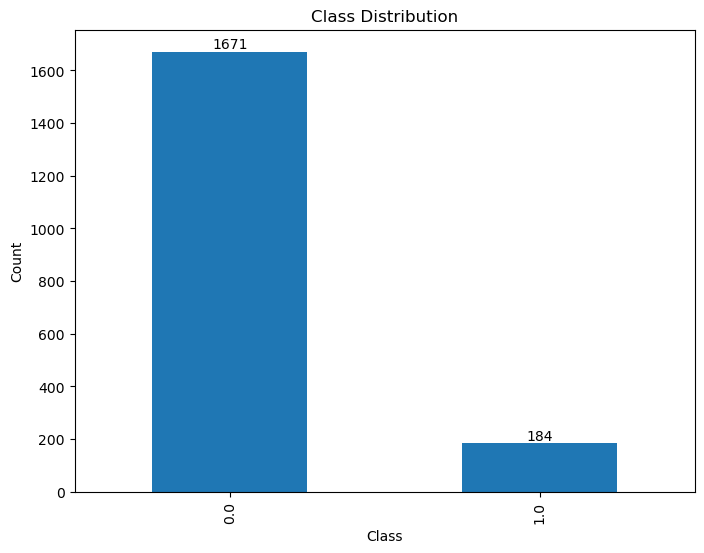

In [261]:
# Assuming 'class_counts' is a pandas Series containing the class counts
class_counts = class_counts.sort_index()

# Create the bar plot
ax = class_counts.plot(kind='bar', figsize=(8, 6))

# Add the numbers on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Set labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')

# Display the plot
plt.show()


In [262]:
imbalance_ratio = class_counts[1] / class_counts[0]
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

Imbalance ratio: 0.11


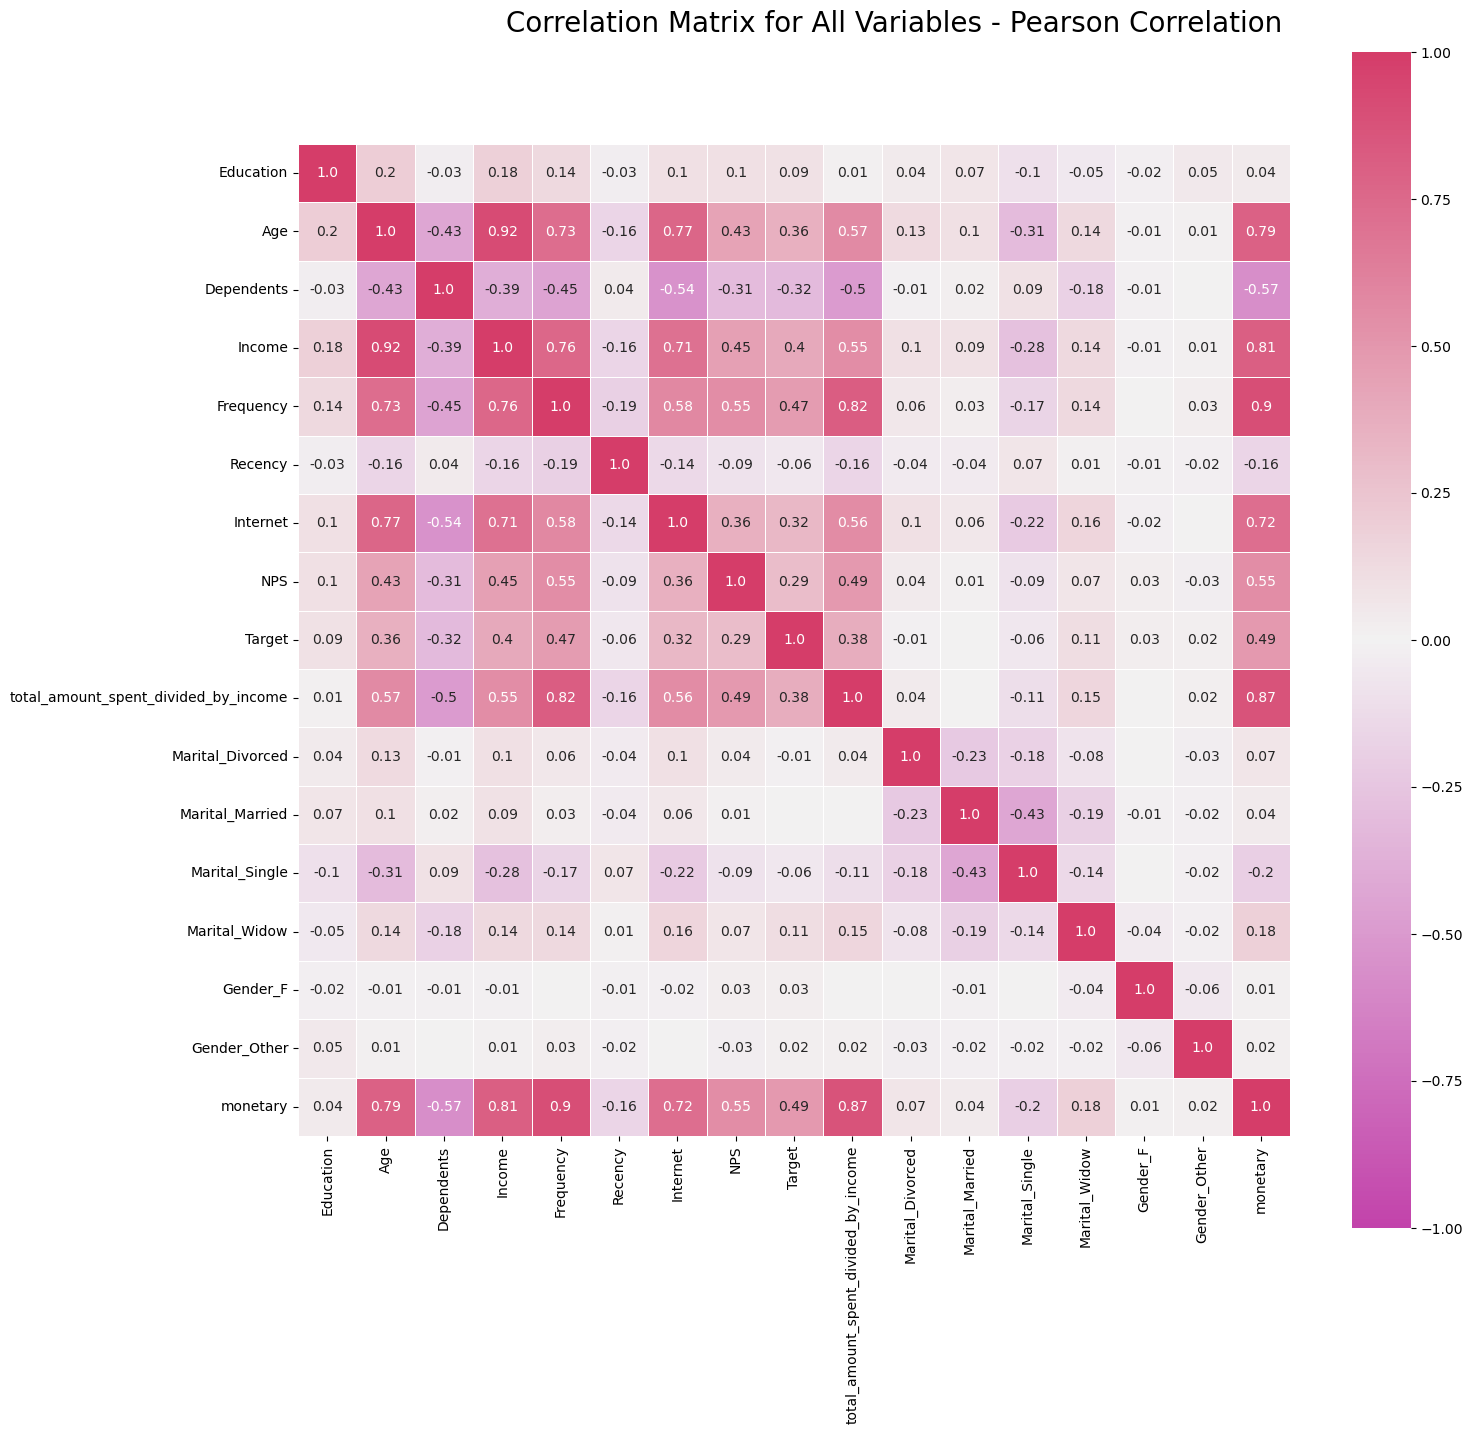

In [263]:
#ploting Pearson's Correlation Matrix for all variables
fig = plt.figure(figsize=(16, 14))

corr = np.round(ds_with_dummies_copy.corr(method="pearson"), decimals=2)

mask_annot = np.absolute(corr.values) >= 0.01
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(320, 360, as_cmap=True), 
fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=0.5)
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix for All Variables - Pearson Correlation ", fontsize=20)

plt.show()

We can see that Marital_divorced, Married, Together, Gender F and Gender Other have almost no impact, so we are going to drop them.

In [264]:
ds_with_dummies_copy.drop('Marital_Divorced', axis=1, inplace= True)

In [265]:
ds_with_dummies_copy.drop('Marital_Married', axis=1, inplace= True)

In [266]:
ds_with_dummies_copy.drop('Gender_F', axis=1, inplace= True)
ds_with_dummies_copy.drop('Gender_Other', axis=1, inplace= True)

In [267]:
#We decide to drop income, since it is pretty well explained by monetary and age. 
#also Frequency seems very well explained, so we drop it, too

In [268]:
ds_with_dummies_copy.drop('Income', axis=1, inplace= True)
ds_with_dummies_copy.drop('Frequency', axis=1, inplace= True)

# Models for Approach 1

### Balanced Random Forest

In [269]:
#Doing the Train Test for the RFM data set

# Define X as all variables except the target
X1 = ds_with_dummies_copy.drop('Target', axis=1)

# Define y as the target variable
y1 = ds_with_dummies_copy['Target']

# Perform train-test split on the data
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [270]:
class_counts = y_test1.value_counts()
print(class_counts)

0.0    340
1.0     31
Name: Target, dtype: int64


In [271]:
class_counts = y_train1.value_counts()
print(class_counts)

0.0    1331
1.0     153
Name: Target, dtype: int64


In [272]:
# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create the Balanced Random Forest Classifier object
BRFC1 = BalancedRandomForestClassifier(random_state=45)

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(BRFC1, param_grid, cv=5, scoring='f1')

# Train the classifier on the training data
grid_search1.fit(X_train1, y_train1)

# Get the best classifier from grid search
best_BRFC1 = grid_search1.best_estimator_
# Make predictions on the test data
BRFC_pred1 = best_BRFC1.predict(X_test1)

# Classification report definition
BRFC_cr1 = classification_report(y_test1, BRFC_pred1)

# Evaluate the accuracy, specificity, sensitivity, AUC, and F1 score of the model
BRFC_accuracy1, BRFC_auc1, BRFC_f11, BRFC_sensitivity1, BRFC_specificity1, BRFC_cm1 = evaluate_model(y_test1, BRFC_pred1)


## Random Forest

In [273]:
# Create the Random Forest Classifier object with 100 trees
RFC1 = RandomForestClassifier(random_state=45)

# Define the parameter grid for grid search
param_grid_RFC1 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Perform grid search with cross-validation
grid_search_RFC1 = GridSearchCV(RFC1, param_grid_RFC1, cv=5, scoring='f1')

# Train the classifier on the training data
grid_search_RFC1.fit(X_train1, y_train1)

# Get the best parameters found during grid search
best_params_RFC1 = grid_search_RFC1.best_params_

# Get the best estimator (classifier) found during grid search
best_estimator_RFC1 = grid_search_RFC1.best_estimator_

# Make predictions on the test data
RFC_pred1 = best_estimator_RFC1.predict(X_test1)

# Get the predicted probabilities for each class
probabilitiesRFC = best_estimator_RFC1.predict_proba(X_test1)

# Create a DataFrame with the probabilities and original index
probabilities_RFC_VALIDATION = pd.DataFrame(probabilitiesRFC, columns=best_estimator_RFC1.classes_, index=X_test1.index)

# Add the original target column to the DataFrame
probabilities_RFC_VALIDATION['Target'] = y_test1.values

# Classification report definition
RFC_cr1 = classification_report(y_test1, RFC_pred1)

# Evaluate the accuracy, specificity, sensitivity, AUC, and F1 score of the model
RFC_accuracy1, RFC_auc1, RFC_f11, RFC_sensitivity1, RFC_specificity1, RFC_cm1 = evaluate_model(y_test1, RFC_pred1)

## SVM 

In [274]:
# Define the hyperparameters to search over
parameters_SVM = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf',],
    'gamma': ['scale', 'auto']
}

# Create the SVM object
svm = SVC()

# Perform a grid search over the hyperparameters using 5-fold cross-validation
cl1 = GridSearchCV(svm, parameters_SVM, cv=5)
cl1.fit(X_train1, y_train1)

# Print the best hyperparameters and the corresponding score
print("Best parameters: ", cl1.best_params_)

# Define the SVM model with the best hyperparameters found through grid search
svm_best1 = SVC(C=cl1.best_params_['C'], kernel=cl1.best_params_['kernel'], gamma=cl1.best_params_['gamma'])

# Train the SVM model on the training data
svm_best1.fit(X_train1, y_train1)

# Use the fitted model to make predictions on the test data
predictions_svm1 = svm_best1.predict(X_test1)

# Classification report definition
cr_SVM1 = classification_report(y_test1, predictions_svm1)

# Evaluate the performance of the model
accuracy_SVM1, auc_SVM1, f1_SVM1, sensitivity_SVM1, specificity_SVM1, cm_SVM1 = evaluate_model(y_test1, predictions_svm1)




Best parameters:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


## Logistic Regression

In [275]:
# Define the parameter grid for grid search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
}

# Create the Logistic Regression object
logreg1 = LogisticRegression(solver='newton-cg', random_state=45)

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(logreg1, param_grid, cv=5, scoring='f1')

# Train the classifier on the training data
grid_search1.fit(X_train1, y_train1)

# Get the best classifier from grid search
best_logreg1 = grid_search1.best_estimator_

# Make predictions on the test data using the best classifier
logreg_pred1 = best_logreg1.predict(X_test1)

# Classification report definition
cr_logreg1 = classification_report(y_test1, logreg_pred1)

# Evaluate the accuracy, specificity, sensitivity, AUC, and F1 score of the model
accuracy_logreg1, auc_logreg1, f1_logreg1, sensitivity_logreg1, specificity_logreg1, cm_logreg1 = evaluate_model(y_test1, logreg_pred1)






## KNN

In [276]:
# Create the KNeighborsClassifier object
knn = KNeighborsClassifier()


# Define the hyperparameters to search over
parameters = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Create the GridSearchCV object
KNN1 = GridSearchCV(knn, parameters, scoring='roc_auc', cv=5)

# Fit the GridSearchCV object to the training data
KNN1.fit(X_train1, y_train1)

# Use the fitted model to make predictions on the test data
predictionsKNN1 = KNN1.predict(X_test1)

# Classification report definition
cr_KNN1 = classification_report(y_test1, predictionsKNN1)

# Evaluate the performance of the model
accuracy_KNN1, auc_KNN1, f1_KNN1, sensitivity_KNN1, specificity_KNN1, cm_KNN1 = evaluate_model(y_test1, predictionsKNN1)

## XGBOOST

In [277]:
# Create the XGBoost Classifier object
xgb = XGBClassifier()

# Define the hyperparameters to search over
parameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Create the GridSearchCV object
XGB1 = GridSearchCV(xgb, parameters, scoring='roc_auc', cv=5)

# Fit the GridSearchCV object to the training data
XGB1.fit(X_train1, y_train1)

# Use the fitted model to make predictions on the test data
predictionsXGB1 = XGB1.predict(X_test1)

# Get the predicted probabilities for each class
probabilitiesXGB1 = XGB1.predict_proba(X_test1)

# Create a DataFrame with the probabilities and original index
probabilities_XGBOOST_VALIDATION = pd.DataFrame(probabilitiesXGB1, columns=XGB1.classes_, index=X_test1.index)

# Add the original target column to the DataFrame
probabilities_XGBOOST_VALIDATION['Target'] = y_test1.values

# Classification report definition
cr_XGB1 = classification_report(y_test1, predictionsXGB1)

# Evaluate the performance of the model
accuracy_XGB1, auc_XGB1, f1_XGB1, sensitivity_XGB1, specificity_XGB1, cm_XGB1 = evaluate_model(y_test1, predictionsXGB1)


## Neural Networks

In [278]:
# Create the MLPClassifier object
mlp = MLPClassifier()

# Define the hyperparameters to search over
parameters = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
}

# Create the GridSearchCV object
mlp_grid1 = GridSearchCV(mlp, parameters, scoring='roc_auc', cv=5)

# Fit the GridSearchCV object to the training data
mlp_grid1.fit(X_train1, y_train1)

# Use the fitted model to make predictions on the test data
predictions_mlp1 = mlp_grid1.predict(X_test1)

# Classification report definition
cr_mlp1 = classification_report(y_test1, predictions_mlp1)

# Evaluate the performance of the model
accuracy_mlp1, auc_mlp1, f1_mlp1, sensitivity_mlp1, specificity_mlp1, cm_mlp1 = evaluate_model(y_test1, predictions_mlp1)


# Evaluation First Approach

### Balanced Random Forest

In [279]:
print (BRFC_cr1)

              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91       340
         1.0       0.32      0.77      0.46        31

    accuracy                           0.85       371
   macro avg       0.65      0.81      0.68       371
weighted avg       0.92      0.85      0.87       371



In [280]:
print (BRFC_accuracy1)
print (BRFC_auc1)
print (BRFC_f11)
print (BRFC_sensitivity1)
print (BRFC_specificity1)

0.8463611859838275
0.8135673624288424
0.45714285714285713
0.7741935483870968
0.8529411764705882


In [281]:
print (BRFC_cm1)

[[290  50]
 [  7  24]]


In [282]:
# Print the confusion matrix
TN = BRFC_cm1[0, 0]
FP = BRFC_cm1[0, 1]
FN = BRFC_cm1[1, 0]
TP = BRFC_cm1[1, 1]

print("Confusion Matrix:")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")


Confusion Matrix:
True Negatives (TN): 290
False Positives (FP): 50
False Negatives (FN): 7
True Positives (TP): 24


### Random Forest

In [283]:
print (RFC_cr1)

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       340
         1.0       0.86      0.39      0.53        31

    accuracy                           0.94       371
   macro avg       0.90      0.69      0.75       371
weighted avg       0.94      0.94      0.93       371



In [284]:
print (RFC_accuracy1)
print (RFC_auc1)
print (RFC_f11)
print (RFC_sensitivity1)
print (RFC_specificity1)

0.9433962264150944
0.690607210626186
0.5333333333333333
0.3870967741935484
0.9941176470588236


In [285]:
print (RFC_cm1)

[[338   2]
 [ 19  12]]


In [286]:
# Print the confusion matrix
TN = RFC_cm1[0, 0]
FP = RFC_cm1[0, 1]
FN = RFC_cm1[1, 0]
TP = RFC_cm1[1, 1]

print("Confusion Matrix:")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")


Confusion Matrix:
True Negatives (TN): 338
False Positives (FP): 2
False Negatives (FN): 19
True Positives (TP): 12


### SVM

In [287]:
print (cr_SVM1)

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       340
         1.0       0.86      0.39      0.53        31

    accuracy                           0.94       371
   macro avg       0.90      0.69      0.75       371
weighted avg       0.94      0.94      0.93       371



In [288]:
print (accuracy_SVM1)
print (auc_SVM1)
print (f1_SVM1)
print (sensitivity_SVM1)
print (specificity_SVM1)

0.9433962264150944
0.690607210626186
0.5333333333333333
0.3870967741935484
0.9941176470588236


In [289]:
print (cm_SVM1)

[[338   2]
 [ 19  12]]


### Logistic Regression

In [290]:
print (cr_logreg1)

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97       340
         1.0       0.77      0.32      0.45        31

    accuracy                           0.94       371
   macro avg       0.86      0.66      0.71       371
weighted avg       0.93      0.94      0.92       371



In [291]:
print (accuracy_logreg1)
print (auc_logreg1)
print (f1_logreg1)
print (sensitivity_logreg1)
print (specificity_logreg1)

0.9353099730458221
0.6568785578747628
0.45454545454545453
0.3225806451612903
0.9911764705882353


In [292]:
print (cm_logreg1)

[[337   3]
 [ 21  10]]


### KNN

In [293]:
print (cr_KNN1)

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       340
         1.0       0.60      0.29      0.39        31

    accuracy                           0.92       371
   macro avg       0.77      0.64      0.68       371
weighted avg       0.91      0.92      0.91       371



In [294]:
print (accuracy_KNN1)
print (auc_KNN1)
print (f1_KNN1)
print (sensitivity_KNN1)
print (specificity_KNN1)

0.9245283018867925
0.6363377609108158
0.3913043478260869
0.2903225806451613
0.9823529411764705


In [295]:
print (cm_KNN1)

[[334   6]
 [ 22   9]]


### XGBOOST

In [296]:
print (cr_XGB1)

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       340
         1.0       0.86      0.39      0.53        31

    accuracy                           0.94       371
   macro avg       0.90      0.69      0.75       371
weighted avg       0.94      0.94      0.93       371



In [297]:
print (accuracy_XGB1)
print (auc_XGB1)
print (f1_XGB1)
print (sensitivity_XGB1)
print (specificity_XGB1)

0.9433962264150944
0.690607210626186
0.5333333333333333
0.3870967741935484
0.9941176470588236


In [298]:
print (cm_XGB1)

[[338   2]
 [ 19  12]]


In [299]:
# Print the confusion matrix
TN = cm_XGB1[0, 0]
FP = cm_XGB1[0, 1]
FN = cm_XGB1[1, 0]
TP = cm_XGB1[1, 1]

print("Confusion Matrix:")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")


Confusion Matrix:
True Negatives (TN): 338
False Positives (FP): 2
False Negatives (FN): 19
True Positives (TP): 12


### Neural Network

In [300]:
print (cr_mlp1)

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       340
         1.0       0.90      0.29      0.44        31

    accuracy                           0.94       371
   macro avg       0.92      0.64      0.70       371
weighted avg       0.94      0.94      0.92       371



In [301]:
print (accuracy_mlp1)
print (auc_mlp1)
print (f1_mlp1)
print (sensitivity_mlp1)
print (specificity_mlp1)

0.9380053908355795
0.6436907020872865
0.4390243902439024
0.2903225806451613
0.9970588235294118


In [302]:
print (cm_mlp1)

[[339   1]
 [ 22   9]]


# Approach 2

In [303]:
#replay button
ds_without = ds_without_RFM.copy()

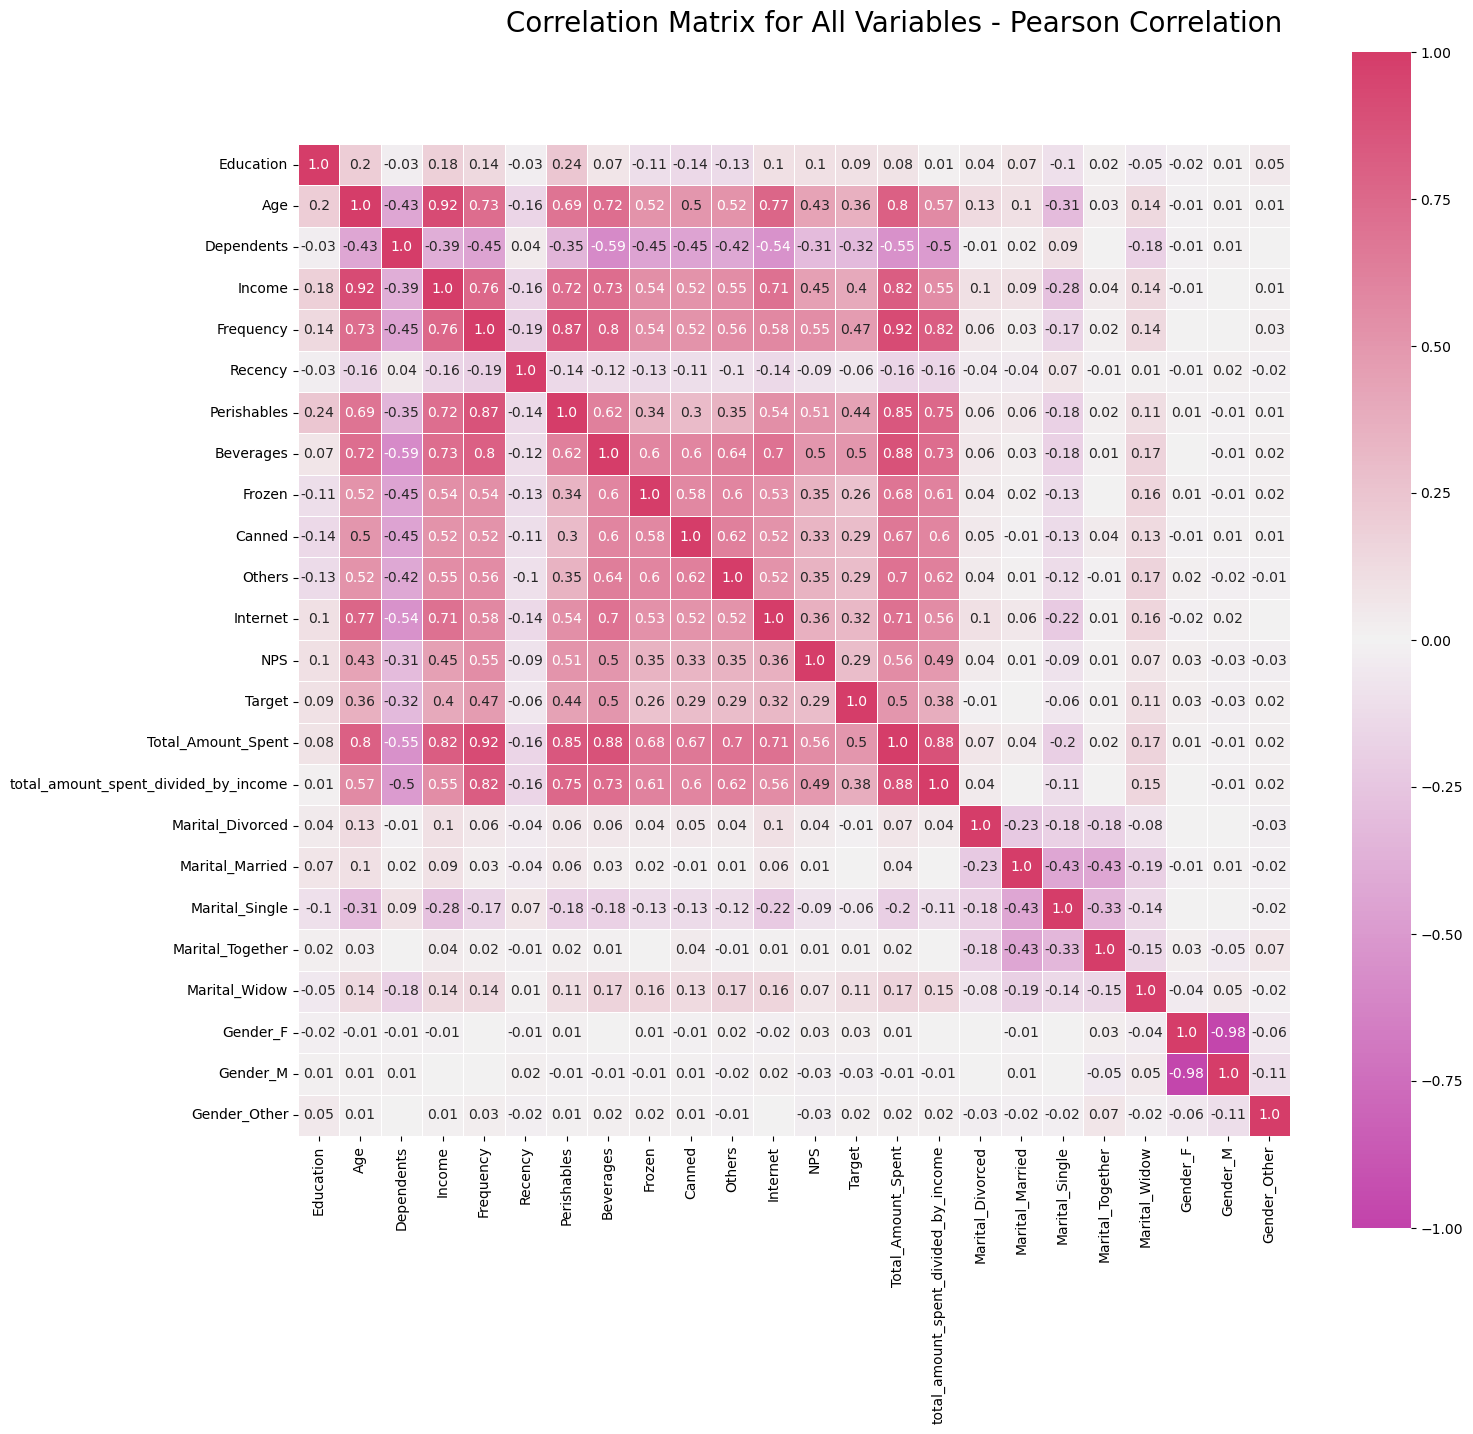

In [304]:
#ploting Pearson's Correlation Matrix for all variables
fig = plt.figure(figsize=(16, 14))

corr = np.round(ds_without.corr(method="pearson"), decimals=2)

mask_annot = np.absolute(corr.values) >= 0.01
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(320, 360, as_cmap=True), 
fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=0.5)
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix for All Variables - Pearson Correlation ", fontsize=20)

plt.show()

In [305]:
ds_without.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1855 entries, 17 to 9000
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             1855 non-null   float64
 1   Age                                   1855 non-null   float64
 2   Dependents                            1855 non-null   float64
 3   Income                                1855 non-null   float64
 4   Frequency                             1855 non-null   float64
 5   Recency                               1855 non-null   float64
 6   Perishables                           1855 non-null   float64
 7   Beverages                             1855 non-null   float64
 8   Frozen                                1855 non-null   float64
 9   Canned                                1855 non-null   float64
 10  Others                                1855 non-null   float64
 11  Internet        

In [306]:
ds_without.drop('Marital_Divorced', axis=1, inplace= True)
ds_without.drop('Marital_Married', axis=1, inplace= True)
ds_without.drop('Marital_Together', axis=1, inplace= True)
ds_without.drop('Gender_F', axis=1, inplace= True)
ds_without.drop('Gender_Other', axis=1, inplace= True)
ds_without.drop('Gender_M', axis=1, inplace= True)
ds_without.drop('Total_Amount_Spent', axis=1, inplace= True)

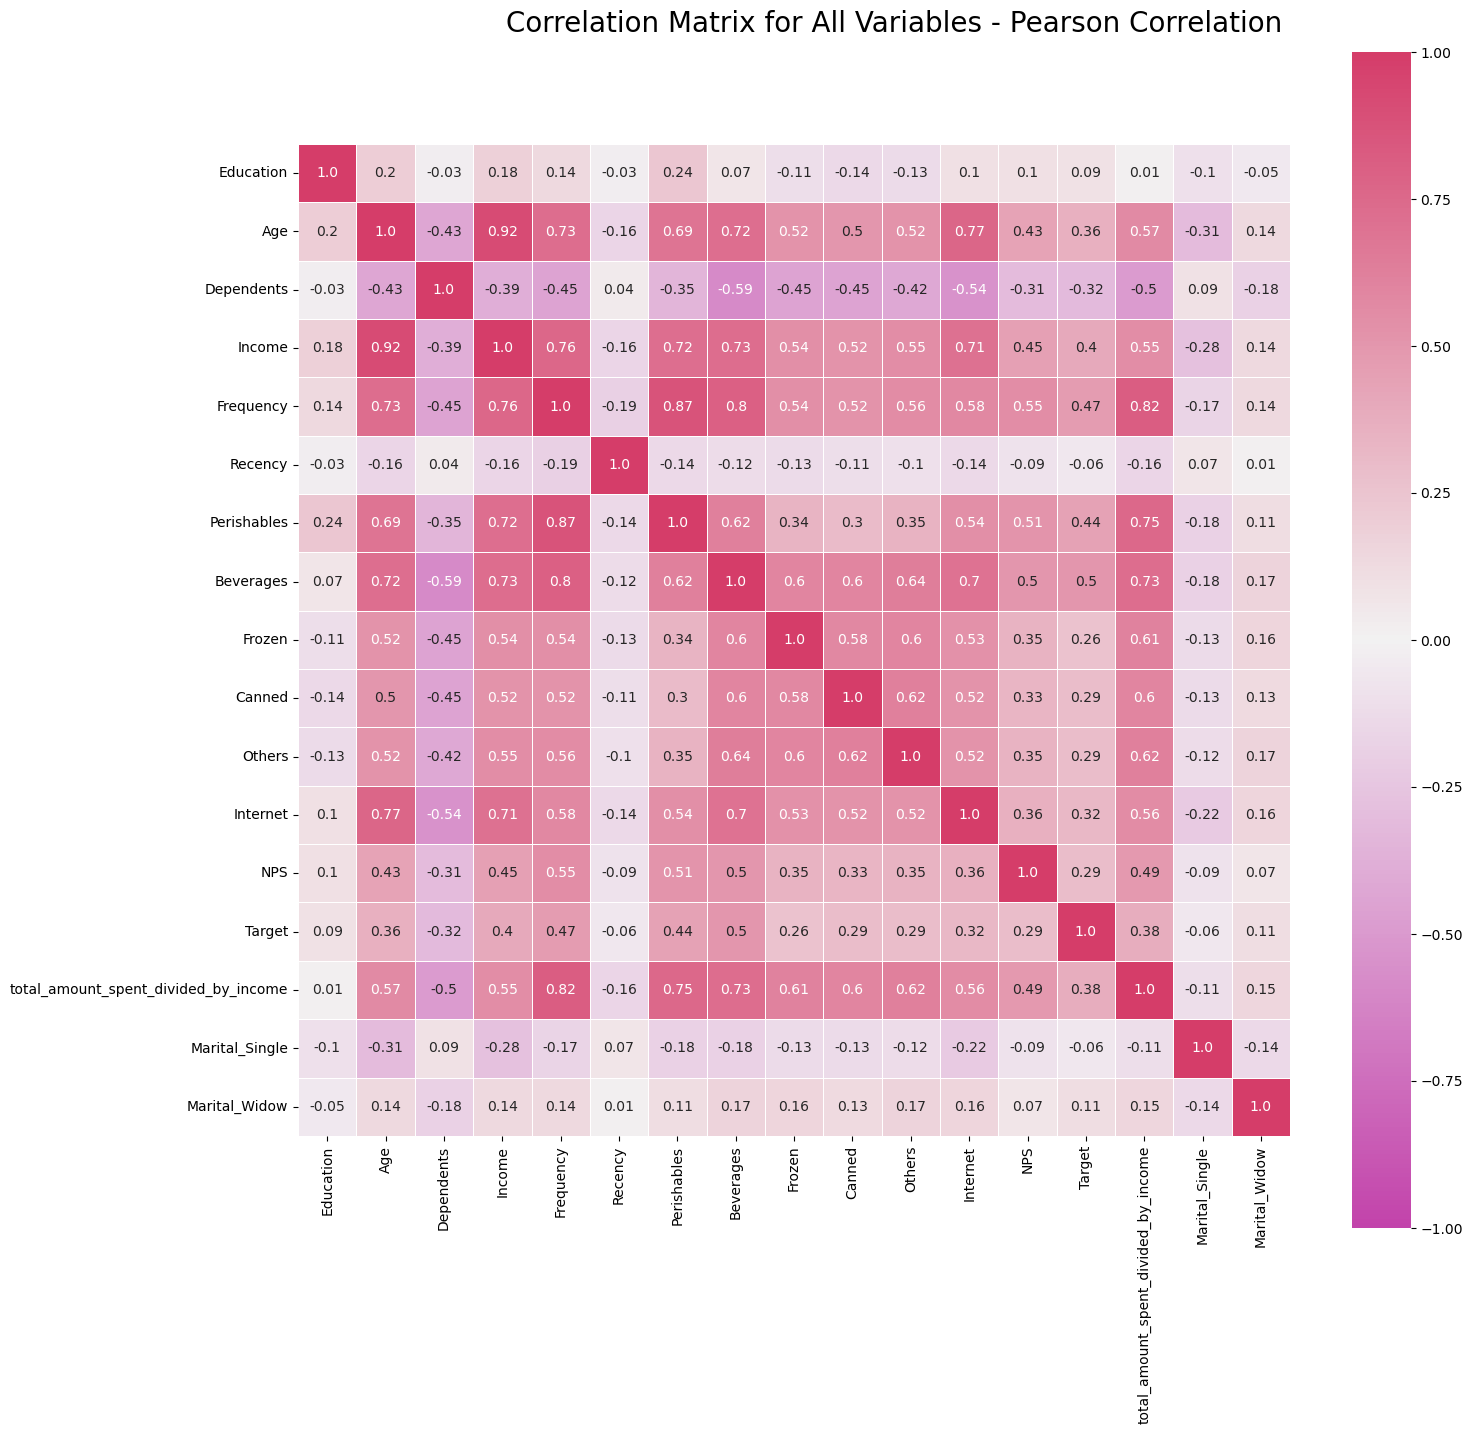

In [307]:
#ploting Pearson's Correlation Matrix for all variables
fig = plt.figure(figsize=(16, 14))

corr = np.round(ds_without.corr(method="pearson"), decimals=2)

mask_annot = np.absolute(corr.values) >= 0.01
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(320, 360, as_cmap=True), 
fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=0.5)
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix for All Variables - Pearson Correlation ", fontsize=20)

plt.show()

In [308]:
#We decide to drop income, since income and age seems to be very similar. We need to avoid problems of multicollinearity
ds_without.drop('Income', axis=1, inplace= True)

In [309]:
# We tried to drop Recency, since it looks well explained, but the results in the models were actually worse

In [310]:
#Doing the Train Test for the RFM data set

# Define X as all variables except the target
X2 = ds_without.drop('Target', axis=1)

# Define y as the target variable
y2 = ds_without['Target']

# Perform train-test split on the data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Models for Approach 2

## Balanced Random Forest 2

In [311]:
# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create the Balanced Random Forest Classifier object
BRFC2 = BalancedRandomForestClassifier(random_state=45)

# Perform grid search with cross-validation
grid_search2 = GridSearchCV(BRFC2, param_grid, cv=5, scoring='f1')

# Train the classifier on the training data
grid_search2.fit(X_train2, y_train2)

# Get the best classifier from grid search
best_BRFC2 = grid_search2.best_estimator_

# Make predictions on the test data using the best classifier
BRFC_pred2 = best_BRFC2.predict(X_test2)

# Get the predicted probabilities for each class
probabilitiesBRF2 = best_BRFC2.predict_proba(X_test2)

# Create a DataFrame with the probabilities and original index
probabilities_BRF2_VALIDATION = pd.DataFrame(probabilitiesBRF2, columns=best_BRFC2.classes_, index=X_test2.index)

# Add the original target column to the DataFrame
probabilities_BRF2_VALIDATION['Target'] = y_test2.values

# Classification report
BRFC_cr2 = classification_report(y_test2, BRFC_pred2)

# Evaluate the accuracy, specificity, sensitivity, AUC, and F1 score of the model
BRFC_accuracy2, BRFC_auc2, BRFC_f12, BRFC_sensitivity2, BRFC_specificity2, BRFC_cm2 = evaluate_model(y_test2, BRFC_pred2)



## Random Forest 2

In [312]:
# Create the Random Forest Classifier object with 100 trees
RFC2 = RandomForestClassifier(n_estimators=100, random_state=45)

# Train the classifier on the training data
RFC2.fit(X_train2, y_train2)

# Make predictions on the test data
RFC_pred2 = RFC2.predict(X_test2)

# Classification report definition
RFC_cr2 = classification_report(y_test2, RFC_pred2)

# Evaluate the accuracy, specificity, sensitivity, AUC, and F1 score of the model
RFC_accuracy2, RFC_auc2, RFC_f12, RFC_sensitivity2, RFC_specificity2, RFC_cm2 = evaluate_model(y_test2, RFC_pred2)

## SVM2

In [313]:
# Define the hyperparameters to search over
parameters = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf',],
    'gamma': ['scale', 'auto']
}

# Create the SVM object
svm = SVC()

# Perform a grid search over the hyperparameters using 5-fold cross-validation
cl2 = GridSearchCV(svm, parameters, cv=5)
cl2.fit(X_train2, y_train2)

# Print the best hyperparameters and the corresponding score
print("Best parameters: ", cl2.best_params_)

# Define the SVM model with the best hyperparameters found through grid search
svm_best2 = SVC(C=cl2.best_params_['C'], kernel=cl2.best_params_['kernel'], gamma=cl2.best_params_['gamma'])

# Train the SVM model on the training data
svm_best2.fit(X_train2, y_train2)

# Use the fitted model to make predictions on the test data
predictions_svm2 = svm_best2.predict(X_test2)

# Classification report definition
cr_SVM2 = classification_report(y_test2, predictions_svm2)

# Evaluate the performance of the model
accuracy_SVM2, auc_SVM2, f1_SVM2, sensitivity_SVM2, specificity_SVM2, cm_SVM2 = evaluate_model(y_test2, predictions_svm2)




Best parameters:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


## Logistic Regression 2

In [314]:
# Define the parameter grid for grid search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
}

# Create the Logistic Regression object
logreg2 = LogisticRegression(solver='newton-cg', random_state=45)

# Perform grid search with cross-validation
grid_search2 = GridSearchCV(logreg2, param_grid, cv=5, scoring='f1')

# Train the classifier on the training data
grid_search2.fit(X_train2, y_train2)

# Get the best classifier from grid search
best_logreg2 = grid_search2.best_estimator_

# Make predictions on the test data using the best classifier
logreg_pred2 = best_logreg2.predict(X_test2)

# Classification report definition
cr_logreg2 = classification_report(y_test2, logreg_pred2)

# Evaluate the accuracy, specificity, sensitivity, AUC, and F1 score of the model
accuracy_logreg2, auc_logreg2, f1_logreg2, sensitivity_logreg2, specificity_logreg2, cm_logreg2 = evaluate_model(y_test2, logreg_pred2)






In [315]:
print (cr_logreg2)

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96       340
         1.0       0.69      0.29      0.41        31

    accuracy                           0.93       371
   macro avg       0.82      0.64      0.69       371
weighted avg       0.92      0.93      0.92       371



In [316]:
print (accuracy_logreg2)
print (auc_logreg2)
print (f1_logreg2)
print (sensitivity_logreg2)
print (specificity_logreg2)

0.9299191374663073
0.6392789373814042
0.4090909090909091
0.2903225806451613
0.9882352941176471


In [317]:
print (cm_logreg2)

[[336   4]
 [ 22   9]]


## KNN 2

In [318]:
# Create the KNeighborsClassifier object
knn = KNeighborsClassifier()

# Define the hyperparameters to search over
parameters = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Create the GridSearchCV object
KNN2 = GridSearchCV(knn, parameters, scoring='roc_auc', cv=5)

# Fit the GridSearchCV object to the training data
KNN2.fit(X_train2, y_train2)

# Use the fitted model to make predictions on the test data
predictionsKNN2 = KNN2.predict(X_test2)

# Classification report definition
cr_KNN2 = classification_report(y_test2, predictionsKNN2)

# Evaluate the performance of the model
accuracy_KNN2, auc_KNN2, f1_KNN2, sensitivity_KNN2, specificity_KNN2, cm_KNN2 = evaluate_model(y_test2, predictionsKNN2)

## XGBOOST 2

In [319]:
# Create the XGBoost Classifier object
xgb = XGBClassifier()

# Define the hyperparameters to search over
parameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Create the GridSearchCV object
XGB2 = GridSearchCV(xgb, parameters, scoring='roc_auc', cv=5)

# Fit the GridSearchCV object to the training data
XGB2.fit(X_train2, y_train2)

# Use the fitted model to make predictions on the test data
predictionsXGB2 = XGB2.predict(X_test2)

# Classification report definition
cr_XGB2 = classification_report(y_test2, predictionsXGB2)

# Evaluate the performance of the model
accuracy_XGB2, auc_XGB2, f1_XGB2, sensitivity_XGB2, specificity_XGB2, cm_XGB2 = evaluate_model(y_test2, predictionsXGB2)


## Neural Networks 2

In [320]:
# Create the MLPClassifier object
mlp = MLPClassifier()

# Define the hyperparameters to search over
parameters = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
}

# Create the GridSearchCV object
mlp_grid2 = GridSearchCV(mlp, parameters, scoring='roc_auc', cv=5)

# Fit the GridSearchCV object to the training data
mlp_grid2.fit(X_train2, y_train2)

# Use the fitted model to make predictions on the test data
predictions_mlp2 = mlp_grid2.predict(X_test2)

# Classification report definition
cr_mlp2 = classification_report(y_test2, predictions_mlp2)

# Evaluate the performance of the model
accuracy_mlp2, auc_mlp2, f1_mlp2, sensitivity_mlp2, specificity_mlp2, cm_mlp2 = evaluate_model(y_test2, predictions_mlp2)


# Evaluation Approach 2

### Balanced Random Forest 2

In [321]:
print (BRFC_cr2)

              precision    recall  f1-score   support

         0.0       0.98      0.86      0.91       340
         1.0       0.33      0.77      0.47        31

    accuracy                           0.85       371
   macro avg       0.65      0.82      0.69       371
weighted avg       0.92      0.85      0.88       371



In [322]:
print (BRFC_accuracy2)
print (BRFC_auc2)
print (BRFC_f12)
print (BRFC_sensitivity2)
print (BRFC_specificity2)

0.8517520215633423
0.8165085388994309
0.46601941747572817
0.7741935483870968
0.8588235294117647


In [323]:
print (BRFC_cm2)

[[292  48]
 [  7  24]]


In [324]:
# Print the confusion matrix
TN = BRFC_cm2[0, 0]
FP = BRFC_cm2[0, 1]
FN = BRFC_cm2[1, 0]
TP = BRFC_cm2[1, 1]

print("Confusion Matrix:")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")


Confusion Matrix:
True Negatives (TN): 292
False Positives (FP): 48
False Negatives (FN): 7
True Positives (TP): 24


### Random Forest 2

In [325]:
print (RFC_cr2)

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96       340
         1.0       0.71      0.32      0.44        31

    accuracy                           0.93       371
   macro avg       0.83      0.66      0.70       371
weighted avg       0.92      0.93      0.92       371



In [326]:
print (RFC_accuracy2)
print (RFC_auc2)
print (RFC_f12)
print (RFC_sensitivity2)
print (RFC_specificity2)

0.9326145552560647
0.6554079696394688
0.4444444444444444
0.3225806451612903
0.9882352941176471


In [327]:
print (RFC_cm2)

[[336   4]
 [ 21  10]]


### SVM 2

In [328]:
print (cr_SVM2)

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97       340
         1.0       0.82      0.29      0.43        31

    accuracy                           0.94       371
   macro avg       0.88      0.64      0.70       371
weighted avg       0.93      0.94      0.92       371



In [329]:
print (accuracy_SVM2)
print (auc_SVM2)
print (f1_SVM2)
print (sensitivity_SVM2)
print (specificity_SVM2)

0.9353099730458221
0.6422201138519924
0.4285714285714286
0.2903225806451613
0.9941176470588236


In [330]:
print (cm_SVM2)

[[338   2]
 [ 22   9]]


### Logistic Regression 2

In [331]:
print (cr_logreg2)

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96       340
         1.0       0.69      0.29      0.41        31

    accuracy                           0.93       371
   macro avg       0.82      0.64      0.69       371
weighted avg       0.92      0.93      0.92       371



In [332]:
print (accuracy_logreg2)
print (auc_logreg2)
print (f1_logreg2)
print (sensitivity_logreg2)
print (specificity_logreg2)

0.9299191374663073
0.6392789373814042
0.4090909090909091
0.2903225806451613
0.9882352941176471


In [333]:
print (cm_logreg2)

[[336   4]
 [ 22   9]]


### KNN 2

In [334]:
print (cr_KNN2)

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       340
         1.0       0.78      0.23      0.35        31

    accuracy                           0.93       371
   macro avg       0.86      0.61      0.66       371
weighted avg       0.92      0.93      0.91       371



In [335]:
print (accuracy_KNN2)
print (auc_KNN2)
print (f1_KNN2)
print (sensitivity_KNN2)
print (specificity_KNN2)

0.9299191374663073
0.6099620493358634
0.35000000000000003
0.22580645161290322
0.9941176470588236


In [336]:
print (cm_KNN2)

[[338   2]
 [ 24   7]]


### XGBOOST 2

In [337]:
print (cr_XGB2)

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96       340
         1.0       0.69      0.35      0.47        31

    accuracy                           0.93       371
   macro avg       0.82      0.67      0.72       371
weighted avg       0.92      0.93      0.92       371



In [338]:
print (accuracy_XGB2)
print (auc_XGB2)
print (f1_XGB2)
print (sensitivity_XGB2)
print (specificity_XGB2)

0.9326145552560647
0.6700664136622392
0.4680851063829787
0.3548387096774194
0.9852941176470589


In [339]:
print (cm_XGB2)

[[335   5]
 [ 20  11]]


### Neural Network 2

In [340]:
print (cr_mlp2)

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96       340
         1.0       0.75      0.29      0.42        31

    accuracy                           0.93       371
   macro avg       0.84      0.64      0.69       371
weighted avg       0.92      0.93      0.92       371



In [341]:
print (accuracy_mlp2)
print (auc_mlp2)
print (f1_mlp2)
print (sensitivity_mlp2)
print (specificity_mlp2)

0.9326145552560647
0.6407495256166983
0.4186046511627908
0.2903225806451613
0.9911764705882353


In [342]:
print (cm_mlp2)

[[337   3]
 [ 22   9]]


# Final Result

The best performing model is the XGBoost 1.
We use it to impute the missing values in Target for the whole dataset.

In [343]:
campaign_target = ds_without_target.copy()

In [344]:
campaign_model = ds_without_target.copy()

In [345]:
campaign_BRF2 = ds_without_target.copy()

## Approach 1 - Random Forest 1

In [346]:
campaign_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6649 entries, 1 to 8999
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             6649 non-null   object 
 1   Marital_Status                        6649 non-null   object 
 2   Age                                   6649 non-null   int64  
 3   Gender                                6649 non-null   object 
 4   Dependents                            6649 non-null   int64  
 5   Income                                6649 non-null   float64
 6   Frequency                             6649 non-null   float64
 7   Recency                               6649 non-null   float64
 8   Perishables                           6649 non-null   float64
 9   Beverages                             6649 non-null   float64
 10  Frozen                                6649 non-null   float64
 11  Canned           

In [347]:
campaign_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6649 entries, 1 to 8999
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             6649 non-null   object 
 1   Marital_Status                        6649 non-null   object 
 2   Age                                   6649 non-null   int64  
 3   Gender                                6649 non-null   object 
 4   Dependents                            6649 non-null   int64  
 5   Income                                6649 non-null   float64
 6   Frequency                             6649 non-null   float64
 7   Recency                               6649 non-null   float64
 8   Perishables                           6649 non-null   float64
 9   Beverages                             6649 non-null   float64
 10  Frozen                                6649 non-null   float64
 11  Canned           

In [348]:
mapping = {
     'PhD' : 21,
     'MSc': 17,
     'BSc': 15,
     'High School': 12,
     'Primary': 9
}

campaign_target['Education'] = campaign_target['Education'].replace(mapping)

In [349]:
# Create dummy variables for 'Marital_status'
marital_dummies = pd.get_dummies(campaign_target['Marital_Status'], prefix='Marital')

# Concatenate the dummy variables with the original DataFrame
ds_semi_final = pd.concat([campaign_target, marital_dummies], axis=1)

In [350]:
# Create dummy variables for 'Marital_status'
gender_dummies = pd.get_dummies(ds_semi_final['Gender'], prefix='Gender')

# Concatenate the dummy variables with the original DataFrame
ds_final = pd.concat([ds_semi_final, gender_dummies], axis=1)

In [351]:
ds_final.drop('Marital_Status', axis=1, inplace= True)
ds_final.drop('Gender', axis=1, inplace= True)

In [352]:
#Replacing all the '?' with missing values
ds_final['Target'] = ds_final['Target'].replace('?', np.nan)

In [353]:
ds_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6649 entries, 1 to 8999
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             6649 non-null   int64  
 1   Age                                   6649 non-null   int64  
 2   Dependents                            6649 non-null   int64  
 3   Income                                6649 non-null   float64
 4   Frequency                             6649 non-null   float64
 5   Recency                               6649 non-null   float64
 6   Perishables                           6649 non-null   float64
 7   Beverages                             6649 non-null   float64
 8   Frozen                                6649 non-null   float64
 9   Canned                                6649 non-null   float64
 10  Others                                6649 non-null   float64
 11  Internet         

In [354]:
# Define the weights
weights = [0.214, 0.13, 0.136, 0.126, 0.199, 0.195]

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
ds_final_copy = ds_final.copy()

# Convert columns to numeric types using .loc on the copied DataFrame, excluding non-numeric values
ds_final_copy.loc[:, numeric_columns] = ds_final_copy.loc[:, numeric_columns].apply(pd.to_numeric, errors='coerce')

# Calculate the weighted sum, excluding non-numeric values
weighted_sum = sum(ds_final_copy[column].fillna(0) * weight for column, weight in zip(numeric_columns, weights) if pd.api.types.is_numeric_dtype(ds_final_copy[column]))

# Create a new column 'monetary' with the weighted sum using .loc on the copied DataFrame
ds_final_copy.loc[:, 'monetary'] = weighted_sum

# Print the updated DataFrame
ds_final_copy.head()


Education  Age  Dependents   Income  Frequency  Recency  Perishables  \
CustID                                                                         
1              17   67           0  67696.2       33.0     74.0      4865.80   
2              15   40           1  43446.0       15.0     17.0       323.76   
3              17   75           0  64193.2       37.0     93.0      5467.00   
4              15   40           1  55898.2       28.0     31.0      3598.00   
5              15   26           1  14414.4       13.0     84.0       263.52   

        Beverages   Frozen   Canned  Others  Internet  NPS  Target  \
CustID                                                               
1         2649.32  2152.80  1715.64  244.08        96    5     NaN   
2          215.24   170.24   107.68   72.84        52    3     NaN   
3         3218.00  1736.40  1460.20  614.40        92    5     NaN   
4          958.20   259.80   147.80  121.80        59    4     NaN   
5          161.52   228.56    57.32  407.52        45    2     NaN   

        Total_Amount_Spent  total_amount_spent_divided_by_income  \
CustID                                                             
1                 11627.64                              0.171762   
2                   889.76                              0.020480   
3                 12496.00                              0.194662   
4                  5085.60                              0.090980   
5                  1118.44                              0.077592   

        Marital_Divorced  Marital_Married  Marital_Single  Marital_Together  \
CustID                                                                        
1                      0                0               0                 1   
2                      0                0               0                 1   
3                      0                0               1                 0   
4                      0                0               1                 0   
5                      0                1               0                 0   

        Marital_Widow  Gender_F  Gender_M  Gender_Other    monetary  
CustID                                                               
1                   0         1         0             0  4500.67088  
2                   0         0         1             0   341.93852  
3                   0         0         1             0  4877.83660  
4                   0         0         1             0  2049.27980  
5                   0         1         0             0   412.44672

In [355]:
ds_final_copy.drop('Perishables', axis=1, inplace= True)
ds_final_copy.drop('Beverages', axis=1, inplace= True)
ds_final_copy.drop('Frozen', axis=1, inplace= True)
ds_final_copy.drop('Canned', axis=1, inplace= True)
ds_final_copy.drop('Others', axis=1, inplace= True)
ds_final_copy.drop('Total_Amount_Spent', axis=1, inplace= True)

In [356]:
#We need k-1 dummy variables to explain 3 options. this is important, because otherwise it leads to multicollinearity
ds_final_copy.drop('Income', axis=1, inplace= True)
ds_final_copy.drop('Frequency', axis=1, inplace= True)
ds_final_copy.drop('Marital_Divorced', axis=1, inplace= True)
ds_final_copy.drop('Marital_Married', axis=1, inplace= True)
ds_final_copy.drop('Gender_F', axis=1, inplace= True)
ds_final_copy.drop('Gender_Other', axis=1, inplace= True)

In [357]:
ds_final_copy.drop('Gender_M', axis=1, inplace= True)
ds_final_copy.drop('Marital_Together', axis=1, inplace= True)

In [358]:
ds_final_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6649 entries, 1 to 8999
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             6649 non-null   int64  
 1   Age                                   6649 non-null   int64  
 2   Dependents                            6649 non-null   int64  
 3   Recency                               6649 non-null   float64
 4   Internet                              6649 non-null   int64  
 5   NPS                                   6649 non-null   int64  
 6   Target                                0 non-null      float64
 7   total_amount_spent_divided_by_income  6649 non-null   float64
 8   Marital_Single                        6649 non-null   uint8  
 9   Marital_Widow                         6649 non-null   uint8  
 10  monetary                              6649 non-null   float64
dtypes: float64(4), in

In [359]:
ds_final_copy['Target'].unique()

array([nan])

In [360]:
# Compute the frequency table for the 'Target' variable
frequency_table = ds_final_copy['Target'].value_counts()

# Print the frequency table
print(frequency_table)


Series([], Name: Target, dtype: int64)


In [361]:
ds_final_copy.isnull().sum()

Education                                  0
Age                                        0
Dependents                                 0
Recency                                    0
Internet                                   0
NPS                                        0
Target                                  6649
total_amount_spent_divided_by_income       0
Marital_Single                             0
Marital_Widow                              0
monetary                                   0
dtype: int64

In [362]:
ds_final_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6649 entries, 1 to 8999
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             6649 non-null   int64  
 1   Age                                   6649 non-null   int64  
 2   Dependents                            6649 non-null   int64  
 3   Recency                               6649 non-null   float64
 4   Internet                              6649 non-null   int64  
 5   NPS                                   6649 non-null   int64  
 6   Target                                0 non-null      float64
 7   total_amount_spent_divided_by_income  6649 non-null   float64
 8   Marital_Single                        6649 non-null   uint8  
 9   Marital_Widow                         6649 non-null   uint8  
 10  monetary                              6649 non-null   float64
dtypes: float64(4), in

In [363]:
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Scale the values while preserving the index
scaled_values_final = scaler.fit_transform(ds_final_copy)

# Create a new DataFrame with the scaled values and the original index
ds_final_copy_scaled = pd.DataFrame(scaled_values_final, index=ds_final_copy.index, columns=ds_final_copy.columns)


In [364]:
ds_RFC = ds_final_copy_scaled.copy()
ds_XGBoost = ds_final_copy_scaled.copy()

In [365]:
# Identify the missing values in the 'Target' column
missing_values_RFC = ds_RFC['Target'].isnull()

# Select the rows with missing values in the 'Target' column
missing_rows_RFC = ds_RFC[missing_values_RFC]

# Drop the 'Target' column from the missing rows
missing_rows_RFC = missing_rows_RFC.drop('Target', axis=1)

# Impute the missing values in the 'Target' column using the trained RFC1 model
imputed_values_RFC = best_estimator_RFC1.predict(missing_rows_RFC)

# Replace the missing values in the 'Target' column with the imputed values
ds_RFC.loc[missing_values_RFC, 'Target'] = imputed_values_RFC

# Create a dataframe with probabilities of the classification for missing rows
probabilities_RFC = pd.DataFrame(best_estimator_RFC1.predict_proba(missing_rows_RFC), columns=best_estimator_RFC1.classes_)

# Set the index of the probabilities_RFC dataframe to match the missing_rows_RFC dataframe
probabilities_RFC.index = missing_rows_RFC.index

# Add the 'Target' column to probabilities_BRF
probabilities_RFC['Target'] = imputed_values_RFC

# Add the columns from campaign_BRF2_with_marital_dummies_scaled to probabilities_BRF
probabilities_RFC = pd.concat([missing_rows_RFC, probabilities_RFC], axis=1)

In [366]:
# Compute the frequency table for the 'Target' variable
frequency_table_RFC = ds_RFC['Target'].value_counts()

# Print the frequency table
print(frequency_table_RFC)


0.0    6151
1.0     498
Name: Target, dtype: int64


In [367]:
probabilities_RFC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6649 entries, 1 to 8999
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             6649 non-null   float64
 1   Age                                   6649 non-null   float64
 2   Dependents                            6649 non-null   float64
 3   Recency                               6649 non-null   float64
 4   Internet                              6649 non-null   float64
 5   NPS                                   6649 non-null   float64
 6   total_amount_spent_divided_by_income  6649 non-null   float64
 7   Marital_Single                        6649 non-null   float64
 8   Marital_Widow                         6649 non-null   float64
 9   monetary                              6649 non-null   float64
 10  0.0                                   6649 non-null   float64
 11  1.0              

In [368]:
#To download add /download
app = Flask(__name__)

@app.route('/download', methods=['GET'])
def download():

    # Save the DataFrame as an Excel file
    probabilities_RFC.to_excel('randomforest_probabilities_FINAL.xlsx')

    # Send the file for download
    return send_file('randomforest_probabilities_FINAL.xlsx', as_attachment=True)

if __name__ == '__main__':
    app.run(host='127.0.0.1', port=6520)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:6520/ (Press CTRL+C to quit)


In [369]:
probabilities_RFC_VALIDATION.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371 entries, 1077 to 857
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0.0     371 non-null    float64
 1   1.0     371 non-null    float64
 2   Target  371 non-null    float64
dtypes: float64(3)
memory usage: 11.6 KB


In [370]:
#To download add /download
app = Flask(__name__)

@app.route('/download', methods=['GET'])
def download():

    # Save the DataFrame as an Excel file
    probabilities_RFC_VALIDATION.to_excel('randomforest_probabilities_validations_FINAL.xlsx')

    # Send the file for download
    return send_file('randomforest_probabilities_validations_FINAL.xlsx', as_attachment=True)

if __name__ == '__main__':
    app.run(host='127.0.0.1', port=6515)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:6515/ (Press CTRL+C to quit)


## Approach 2 XGBoost 1

In [371]:
ds_XGBoost.isnull().sum()

Education                                  0
Age                                        0
Dependents                                 0
Recency                                    0
Internet                                   0
NPS                                        0
Target                                  6649
total_amount_spent_divided_by_income       0
Marital_Single                             0
Marital_Widow                              0
monetary                                   0
dtype: int64

In [372]:
ds_XGBoost.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6649 entries, 1 to 8999
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             6649 non-null   float64
 1   Age                                   6649 non-null   float64
 2   Dependents                            6649 non-null   float64
 3   Recency                               6649 non-null   float64
 4   Internet                              6649 non-null   float64
 5   NPS                                   6649 non-null   float64
 6   Target                                0 non-null      float64
 7   total_amount_spent_divided_by_income  6649 non-null   float64
 8   Marital_Single                        6649 non-null   float64
 9   Marital_Widow                         6649 non-null   float64
 10  monetary                              6649 non-null   float64
dtypes: float64(11)
me

In [373]:
# Identify the missing values in the 'Target' column
missing_values_XGB = ds_XGBoost['Target'].isnull()

# Select the rows with missing values in the 'Target' column
missing_rows_XGB = ds_XGBoost[missing_values_XGB]

# Drop the 'Target' column from the missing rows
missing_rows_XGB = missing_rows_XGB.drop('Target', axis=1)

# Impute the missing values in the 'Target' column using the trained RFC1 model
imputed_values_XGB = XGB1.predict(missing_rows_XGB)

# Replace the missing values in the 'Target' column with the imputed values
ds_XGBoost.loc[missing_values_XGB, 'Target'] = imputed_values_XGB

# Create a dataframe with probabilities of the classification for missing rows
probabilities_XGB = pd.DataFrame(XGB1.predict_proba(missing_rows_XGB), columns=XGB1.classes_)

# Set the index of the probabilities_RFC dataframe to match the missing_rows_RFC dataframe
probabilities_XGB.index = missing_rows_XGB.index

# Add the 'Target' column to probabilities_BRF
probabilities_XGB['Target'] = imputed_values_XGB

# Add the columns from campaign_BRF2_with_marital_dummies_scaled to probabilities_BRF
probabilities_XGB = pd.concat([missing_rows_XGB, probabilities_XGB], axis=1)

In [374]:
# Compute the frequency table for the 'Target' variable
frequency_table_XGB = ds_XGBoost['Target'].value_counts()

# Print the frequency table
print(frequency_table_XGB)

0.0    5410
1.0    1239
Name: Target, dtype: int64


In [375]:
ds_XGBoost.head()

Education       Age  Dependents   Recency  Internet   NPS  Target  \
CustID                                                                      
1        0.666667  0.800000         0.0  0.200549  0.943820  1.00     1.0   
2        0.500000  0.350000         1.0  0.043956  0.449438  0.50     0.0   
3        0.666667  0.933333         0.0  0.252747  0.898876  1.00     1.0   
4        0.500000  0.350000         1.0  0.082418  0.528090  0.75     0.0   
5        0.500000  0.116667         1.0  0.228022  0.370787  0.25     0.0   

        total_amount_spent_divided_by_income  Marital_Single  Marital_Widow  \
CustID                                                                        
1                                   0.178180             0.0            0.0   
2                                   0.021084             0.0            0.0   
3                                   0.201960             1.0            0.0   
4                                   0.094293             1.0            0.0   
5                                   0.080391             0.0            0.0   

        monetary  
CustID            
1       0.631359  
2       0.047518  
3       0.684309  
4       0.287210  
5       0.057416

In [376]:
probabilities_XGBOOST_VALIDATION.head()

0.0       1.0  Target
CustID                            
1077    0.960933  0.039067     0.0
2128    0.942567  0.057433     0.0
5749    0.960939  0.039061     0.0
5942    0.960933  0.039067     0.0
1938    0.694388  0.305612     1.0

In [377]:
#To download add /download
app = Flask(__name__)

@app.route('/download', methods=['GET'])
def download():

    # Save the DataFrame as an Excel file
    probabilities_XGBOOST_VALIDATION.to_excel('XGBoost_probabilities_VALIDATION_FINAL.xlsx')

    # Send the file for download
    return send_file('XGBoost_probabilities_VALIDATION_FINAL.xlsx', as_attachment=True)

if __name__ == '__main__':
    app.run(host='127.0.0.1', port=1350)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:1350/ (Press CTRL+C to quit)


In [378]:
probabilities_XGB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6649 entries, 1 to 8999
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             6649 non-null   float64
 1   Age                                   6649 non-null   float64
 2   Dependents                            6649 non-null   float64
 3   Recency                               6649 non-null   float64
 4   Internet                              6649 non-null   float64
 5   NPS                                   6649 non-null   float64
 6   total_amount_spent_divided_by_income  6649 non-null   float64
 7   Marital_Single                        6649 non-null   float64
 8   Marital_Widow                         6649 non-null   float64
 9   monetary                              6649 non-null   float64
 10  0.0                                   6649 non-null   float32
 11  1.0              

In [379]:
#To download add /download
app = Flask(__name__)

@app.route('/download', methods=['GET'])
def download():

    # Save the DataFrame as an Excel file
    probabilities_XGB.to_excel('XGBoost_probabilities_FINAL.xlsx')

    # Send the file for download
    return send_file('XGBoost_probabilities_FINAL.xlsx', as_attachment=True)

if __name__ == '__main__':
    app.run(host='127.0.0.1', port=3515)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:3515/ (Press CTRL+C to quit)


## Approach 3 Balanced Random Forest

In [380]:
campaign_BRF2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6649 entries, 1 to 8999
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             6649 non-null   object 
 1   Marital_Status                        6649 non-null   object 
 2   Age                                   6649 non-null   int64  
 3   Gender                                6649 non-null   object 
 4   Dependents                            6649 non-null   int64  
 5   Income                                6649 non-null   float64
 6   Frequency                             6649 non-null   float64
 7   Recency                               6649 non-null   float64
 8   Perishables                           6649 non-null   float64
 9   Beverages                             6649 non-null   float64
 10  Frozen                                6649 non-null   float64
 11  Canned           

In [381]:
mapping = { 'PhD' : 21,
     'MSc': 17,
     'BSc': 15,
     'High School': 12,
     'Primary': 9
}
campaign_BRF2['Education'] = campaign_BRF2['Education'].replace(mapping)

In [382]:
# Create dummy variables for 'Marital_status'
marital_dummies = pd.get_dummies(campaign_BRF2['Marital_Status'], prefix='Marital')

# Concatenate the dummy variables with the original DataFrame
campaign_BRF2_with_marital_dummies = pd.concat([campaign_BRF2, marital_dummies], axis=1)

In [383]:
campaign_BRF2_with_marital_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6649 entries, 1 to 8999
Data columns (total 23 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             6649 non-null   int64  
 1   Marital_Status                        6649 non-null   object 
 2   Age                                   6649 non-null   int64  
 3   Gender                                6649 non-null   object 
 4   Dependents                            6649 non-null   int64  
 5   Income                                6649 non-null   float64
 6   Frequency                             6649 non-null   float64
 7   Recency                               6649 non-null   float64
 8   Perishables                           6649 non-null   float64
 9   Beverages                             6649 non-null   float64
 10  Frozen                                6649 non-null   float64
 11  Canned           

In [384]:
campaign_BRF2_with_marital_dummies.drop('Marital_Status', axis=1, inplace= True)
campaign_BRF2_with_marital_dummies.drop('Gender', axis=1, inplace= True)
campaign_BRF2_with_marital_dummies.drop('Total_Amount_Spent', axis=1, inplace= True)
campaign_BRF2_with_marital_dummies.drop('Marital_Divorced', axis=1, inplace= True)
campaign_BRF2_with_marital_dummies.drop('Marital_Married', axis=1, inplace= True)
campaign_BRF2_with_marital_dummies.drop('Marital_Together', axis=1, inplace= True)
campaign_BRF2_with_marital_dummies.drop('Income', axis=1, inplace= True)

In [385]:
#Replacing all the '?' with missing values
campaign_BRF2_with_marital_dummies['Target'] = campaign_BRF2_with_marital_dummies['Target'].replace('?', np.nan)

In [386]:
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Scale the values while preserving the index
scaled_values_BRF2 = scaler.fit_transform(campaign_BRF2_with_marital_dummies)

# Create a new DataFrame with the scaled values and the original index
campaign_BRF2_with_marital_dummies_scaled = pd.DataFrame(scaled_values_BRF2, index=campaign_BRF2_with_marital_dummies.index, columns=campaign_BRF2_with_marital_dummies.columns)


In [387]:
# Identify the missing values in the 'Target' column
missing_values_BRF2 = campaign_BRF2_with_marital_dummies_scaled['Target'].isnull()

# Select the rows with missing values in the 'Target' column
missing_rows_BRF2 = campaign_BRF2_with_marital_dummies_scaled[missing_values_BRF2]

# Drop the 'Target' column from the missing rows
missing_rows_BRF2 = missing_rows_BRF2.drop('Target', axis=1)

# Impute the missing values in the 'Target' column using the trained RFC1 model
imputed_values_BRF2 = best_BRFC2.predict(missing_rows_BRF2)

# Replace the missing values in the 'Target' column with the imputed values
campaign_BRF2_with_marital_dummies_scaled.loc[missing_values_BRF2, 'Target'] = imputed_values_BRF2

# Create a dataframe with probabilities of the classification for missing rows
probabilities_BRF2 = pd.DataFrame(best_BRFC2.predict_proba(missing_rows_BRF2), columns=best_BRFC2.classes_)

# Set the index of the probabilities_BRF dataframe to match the missing_rows_BRF dataframe
probabilities_BRF2.index = missing_rows_BRF2.index

# Add the 'Target' column to probabilities_BRF
probabilities_BRF2['Target'] = imputed_values_BRF2

# Add the columns from campaign_BRF2_with_marital_dummies_scaled to probabilities_BRF
probabilities_BRF2 = pd.concat([missing_rows_BRF2, probabilities_BRF2], axis=1)

In [388]:
# Compute the frequency table for the 'Target' variable
frequency_table = campaign_BRF2_with_marital_dummies_scaled['Target'].value_counts()

# Print the frequency table
print(frequency_table)

0.0    5227
1.0    1422
Name: Target, dtype: int64


In [389]:
probabilities_BRF2_VALIDATION.head()

0.0       1.0  Target
CustID                            
1077    0.930850  0.069150     0.0
2128    0.789766  0.210234     0.0
5749    0.924653  0.075347     0.0
5942    0.870635  0.129365     0.0
1938    0.288661  0.711339     1.0

In [390]:
#To download add /download
app = Flask(__name__)

@app.route('/download', methods=['GET'])
def download():

    # Save the DataFrame as an Excel file
    probabilities_BRF2_VALIDATION.to_excel('BRF2_probabilities_VALIDATION_FINAL.xlsx')

    # Send the file for download
    return send_file('BRF2_probabilities_VALIDATION_FINAL.xlsx', as_attachment=True)

if __name__ == '__main__':
    app.run(host='127.0.0.1', port=1465)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:1465/ (Press CTRL+C to quit)


In [391]:
probabilities_BRF2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6649 entries, 1 to 8999
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Education                             6649 non-null   float64
 1   Age                                   6649 non-null   float64
 2   Dependents                            6649 non-null   float64
 3   Frequency                             6649 non-null   float64
 4   Recency                               6649 non-null   float64
 5   Perishables                           6649 non-null   float64
 6   Beverages                             6649 non-null   float64
 7   Frozen                                6649 non-null   float64
 8   Canned                                6649 non-null   float64
 9   Others                                6649 non-null   float64
 10  Internet                              6649 non-null   float64
 11  NPS              

In [392]:
#To download add /download
app = Flask(__name__)

@app.route('/download', methods=['GET'])
def download():

    # Save the DataFrame as an Excel file
    probabilities_BRF2.to_excel('BRF2_probabilities_FINAL.xlsx')

    # Send the file for download
    return send_file('BRF2_probabilities_FINAL.xlsx', as_attachment=True)

if __name__ == '__main__':
    app.run(host='127.0.0.1', port=3575)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:3575/ (Press CTRL+C to quit)
